In [1]:
!export OMP_NUM_THREADS=8
from mkl import set_num_threads
set_num_threads(8)

24

In [2]:
# %matplotlib inline
%matplotlib inline
from matplotlib import pylab as plt

# import os, sys
# sys.path.insert(0, './build/_deps/rascal-build/')
import os, sys
sys.path.insert(0,'/home/musil/git/librascal/build')
from ase.io import read
from ase.constraints import full_3x3_to_voigt_6_stress

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
from tqdm.notebook import tqdm
#import nglview
import pandas as pd
from itertools import product

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model, SparsePoints
from rascal.neighbourlist import AtomsList
from rascal.utils import from_dict, CURFilter, FPSFilter, BaseIO, to_dict
from rascal.utils.io import dump_obj,load_obj
# from rascal.lib import compute_forces

In [3]:
from rascal.utils.io import load_obj
from rascal.models import KRR

from ase.calculators.calculator import Calculator,all_changes
from copy import deepcopy
import signac

In [4]:
sys.path.insert(0, './scripts/')
from utils.io import fromfile, tofile, frompickle, topickle, _decode
import utils.lattice_cubic as lattice_cubic
import utils.lattice_tetragonal as lattice_tetragonal
# from utils.model import KnmPool, train_gap_model

In [5]:
fpfx = './figures/v2/mlip/'

# Utility functions

In [6]:
def extract_ref(frames,info_key='energy',array_key='forces'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

In [7]:
from scipy.stats import spearmanr

def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_spearman(ypred,y):
    corr,_ = spearmanr(ypred,y)
    return corr

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
    CORR=get_spearman
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores
def print_score(ypred,y):
    scores = get_score(ypred,y)
    print(' '.join(map(lambda x:'{}={:.2e}'.format(*x), scores.items())))


In [8]:
from sklearn.model_selection._split import ShuffleSplit, KFold
from abc import ABCMeta, abstractmethod
import collections
from sklearn.model_selection._split import (_BaseKFold,
        BaseCrossValidator,_validate_shuffle_split,BaseShuffleSplit)
from sklearn.utils.validation import _num_samples
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod

class LCSplit(object):
    def __init__(self, cv, n_repeats=[10],train_sizes=[10],test_size="default", random_state=None, **cvargs):

        self.cv = cv
        self.n_repeats = n_repeats
        self.train_sizes = train_sizes
        self.random_state = random_state
        self.cvargs = cvargs
        self.test_size = test_size
        self.n_splits = np.sum(n_repeats)
    
    def get_params(self):
        params = dict(cv=self.cv.get_params(),n_repeats=self.n_repeats,train_sizes=self.train_sizes,
                     test_size=self.test_size,random_state=self.random_state,cvargs=self.cvargs)
        return params

    def split(self, X, y=None, groups=None):
        """Generates indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, of length n_samples
            The target variable for supervised learning problems.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """

        rng = check_random_state(self.random_state)
        
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            for train_index, test_index in cv.split(X, y, groups):
                yield train_index, test_index
                
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        y : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        rng = check_random_state(self.random_state)
        n_splits = 0
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            n_splits += cv.get_n_splits(X, y, groups)
        return n_splits
    

In [9]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")
    
def view_ngl(frames):
    iwdg = nglview.show_asetraj(frames)
    # set up the visualization
    iwdg.add_unitcell()
    iwdg.add_spacefill()
    iwdg.remove_ball_and_stick()
    iwdg.camera = 'orthographic'
    iwdg.parameters = { "clipDist": 0 }
    iwdg.center()
    iwdg.update_spacefill(radiusType='covalent',
                                       scale=0.6,
                                       color_scheme='element')
    iwdg._remote_call('setSize', target='Widget',
                                   args=['%dpx' % (600,), '%dpx' % (400,)])
    iwdg.player.delay = 200.0
    return iwdg

def interactive_scatter(frames, pos):
    iwdg = view_ngl(frames)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    link_ngl_wdgt_to_ax_pos(ax, pos, iwdg)
    ax.scatter(pos[:,0],pos[:,1],s=3)
    return fig, ax, iwdg

In [10]:
sys.path.insert(0,'./scripts/')
from utils.colormap import get_energyCmap

cmap = get_energyCmap()

from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
def plot_contour_overlay(df, x, y, values , row, col, **kwargs):
    vmin=df[values].min()
    vmax=df[values].max()
    g = sns.FacetGrid(df, col=col, row=row, height=5, dropna=False, **kwargs)
    g.map_dataframe(draw_heatmap, x, y, values, annot=True, fmt=".0f", cmap=cmap, square=True, cbar=False,
                    vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.17, 0.05, 0.7])
    norm = Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label= values)
    return g

def plot_contour(df, x, y, values , row, col, **kwargs):
    vmin=df[values].min()
    vmax=df[values].max()
    g = sns.FacetGrid(df, col=col, row=row, height=5, dropna=False, **kwargs)
    g.map_dataframe(draw_heatmap, x, y, values, cmap=cmap, square=True, cbar=False,
                    vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.17, 0.05, 0.7])
    norm = Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label= values)
    return g

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d.sort_index('index',ascending=False) 
    sns.heatmap(d, **kwargs)

# Build a Force Field

In [15]:
# Total number of structure to load
N = 2474
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = fromfile('./structures/silicon_bulk.json')[1:]

for ff in frames:
    ff.wrap(eps=1e-10)

global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# split the structures in 2 sets
ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    14:-158.54496821,
}
global_species

array([14])

In [16]:
PATH = './results/mlip_Si_rc5_n10_l12_g0.5_gto/'

In [17]:
n_sparses = [100, 200, 500, 1000, 2000, 5000, 7000, 9000]
n_sparses = [1000, 2000, 5000]
n_features = [int(715*f) for f in [0.02, 0.05, 0.1, 0.2,0.4, 0.5, 0.7, 1]]
n_features = [130]
n_features,n_sparses

([130], [1000, 2000, 5000])

## test stress

In [14]:
from rascal.models.IP_ase_interface import ASEMLCalculator

In [8]:
lambdas=[0.005,0.5]
zeta, n_feature, n_sparse = 4, 715, 1000
fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
model = load_obj(fn)

In [9]:
hypers = model.X_train.representation._get_init_params()
hypers['compute_gradients'] = False
soap = SphericalInvariants(**hypers)
hypers_k = model.kernel._get_init_params()
hypers_k.pop('representation')
kernel = Kernel(soap, **hypers_k)

In [17]:
V_ref = 20.34*8 # a**3
alat_ref = np.power(V_ref, 1/3)

In [10]:
from rascal.models.kernels import compute_numerical_kernel_gradients


In [49]:
from rascal.models import KRR
from rascal.utils import BaseIO
from ase.calculators.calculator import Calculator, all_changes
from copy import deepcopy
from rascal.neighbourlist.structure_manager import AtomsList, unpack_ase

def displace_cell(atoms, i, h, original_cell, original_positions):
    voigt_ids = [ (0,0), (1,1), (2,2), (1,2), (0,2), (0,1)]
    # e.g. epsilon_xy means add h_disp of y dimension to x dimension
    # alpha dimension + h*beta dimension
#     original_positions = np.copy(original_positions)
#     original_positions[voigt_ids[i][0]] += h*original_positions[voigt_ids[i][1]]
#     atoms.set_positions( original_positions.T )

    displaced_cell = np.copy( original_cell )
    displaced_cell[voigt_ids[i][0]] += h*original_cell [voigt_ids[i][1]]
    atoms.set_cell(displaced_cell,scale_atoms=True)
#     atoms.set_cell(displaced_cell)
    atoms.wrap(eps=1e-11)
    return atoms

class ASEMLCalculator(Calculator, BaseIO):
    """Wrapper class to use a rascal model as an interatomic potential in ASE

    Parameters
    ----------
    model : class
        a trained model of the rascal library that can predict the energy and
        derivaties of the energy w.r.t. atomic positions
    representation : class
        a representation calculator of rascal compatible with the trained model
    """

    implemented_properties = ['energy', 'forces', 'stress','free_energy']
    'Properties calculator can handle (energy, forces, ...)'

    default_parameters = {}
    'Default parameters'

    nolabel = True

    def __init__(self, model, representation, **kwargs):
        super(ASEMLCalculator, self).__init__(**kwargs)
        self.model = model
        self.representation = representation
        self.kwargs = kwargs
        self.manager = None

    def calculate(self, atoms=None, properties=['energy', 'forces', 'stress','free_energy'],
                  system_changes=all_changes):
        Calculator.calculate(self, atoms, properties, system_changes)

        if self.manager is None:
            # happens at the begining of the MD run
            at = self.atoms.copy()
            at.wrap(eps=1e-11)
            self.manager = [at]
        elif isinstance(self.manager, AtomsList):
            structure = unpack_ase(self.atoms, wrap_pos=True)
            structure.pop('center_atoms_mask')
            self.manager[0].update(**structure)

        self.manager = self.representation.transform(self.manager)

        energy = self.model.predict(self.manager)
        self.results['energy'] = energy
        self.results['free_energy'] = energy
        # compute_stress = True if 'stress' in properties else False
        compute_stress = True
        forces_and_stress = -self.model.predict(self.manager,
                                    compute_gradients=True,
                                    compute_stress=compute_stress)
        
        self.results['forces'] = forces_and_stress[:-2]
        self.results['stress'] = forces_and_stress[-2:].flatten()
        
    def compute_numerical_stress(self):
        hypers = self.model.X_train.representation._get_init_params()
        hypers['compute_gradients'] = False
        soap = SphericalInvariants(**hypers)
        hypers_k = self.model.kernel._get_init_params()
        hypers_k.pop('representation')
        kernel = Kernel(soap, **hypers_k)
        atoms = self.atoms.copy()
        
        original_cell = atoms.get_cell().array
        original_positions = atoms.get_positions().T
        volume = atoms.get_volume()
        voigt_ids = [ (0,0), (1,1), (2,2), (1,2), (0,2), (0,1)]
        h = 1e-4

        numerical_kernel_stress = np.zeros( (6, self.model.X_train.size()) )
        for i in range(6):
            atoms_p  = displace_cell(atoms, i,  h, original_cell, original_positions)
            manager_p = soap.transform([atoms_p])
            dkdr_plus = kernel(manager_p, model.X_train)
            atoms_m = displace_cell(atoms, i, -h, original_cell, original_positions)
            manager_m = soap.transform([atoms_m])
            dkdr_minus = kernel(manager_m, self.model.X_train)
            numerical_kernel_stress[i] = np.sum((dkdr_plus - dkdr_minus) / (2*h), axis=0)
            
        numerical_kernel_stress /= volume

        stress =  np.dot(numerical_kernel_stress, self.model.weights)
        
        return stress.flatten()
    
    def _get_init_params(self):
        init_params = dict(model=self.model, representation=self.representation)
        init_params.update(**self.kwargs)
        return init_params

    def _set_data(self, data):
        self.manager = None
        super()._set_data(data)

    def _get_data(self):
        return super()._get_data()

In [47]:
from ase.optimize import FIRE,BFGS
from ase import constraints
from ase.constraints import StrainFilter
from ase.build import bulk

hypers = model.X_train.representation._get_init_params()
hypers['compute_gradients'] = True
soap_ = SphericalInvariants(**hypers)
calc = ASEMLCalculator(model, soap_)

latticeconstant = 3.
atoms = bulk('Si', 'diamond', a=alat_ref*1.1, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-2)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(), volRef, np.power(volRef, 1/3)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 15:42:28    -1302.118080*       0.0000


(Cell([6.0053685283845075, 6.0053685283845075, 6.0053685283845075]),
 216.58031999999992,
 6.005368528384507)

## utils

In [14]:
def displace_cell(atoms, i, h, original_cell, original_positions):
    # e.g. epsilon_xy means add h_disp of y dimension to x dimension
    # alpha dimension + h*beta dimension
#     original_positions = np.copy(original_positions)
#     original_positions[voigt_ids[i][0]] += h*original_positions[voigt_ids[i][1]]
#     atoms.set_positions( original_positions.T )

    displaced_cell = np.copy( original_cell )
    displaced_cell[voigt_ids[i][0]] += h*original_cell [voigt_ids[i][1]]
    atoms.set_cell(displaced_cell,scale_atoms=True)
#     atoms.set_cell(displaced_cell)
    atoms.wrap(eps=1e-11)
    return atoms

In [15]:
from rascal.utils import BaseIO

class KRR(BaseIO):
    """Kernel Ridge Regression model. Only compatible fully with sparse GPR
    training for the moment.

    Parameters
    ----------
    weights : np.array
        weights of the model

    kernel : Kernel
        kernel class used to train the model

    X_train : PseudoPoints
        reference samples used for the training

    self_contributions : dictionary
        map atomic number to the property baseline, e.g. isolated atoms
        energies when the model has been trained on total energies.
    """

    def __init__(self, weights, kernel, X_train, self_contributions):
        super(KRR, self).__init__()
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
        self.self_contributions = self_contributions
        self.target_type = kernel.target_type

    def _get_property_baseline(self, managers):
        """build total baseline contribution for each prediction"""
        if self.target_type == 'Structure':
            Y0 = np.zeros(len(managers))
            for i_manager, manager in enumerate(managers):
                if isinstance(manager, ase.Atoms):
                    numbers = manager.get_atomic_numbers()
                    for sp in numbers:
                        Y0[i_manager] += self.self_contributions[sp]
                else:
                    for at in manager:
                        Y0[i_manager] += self.self_contributions[at.atom_type]
        elif self.target_type == 'Atom':
            n_centers = 0
            for manager in managers:
                n_centers += len(manager)
            Y0 = np.zeros(n_centers)
            i_center = 0
            for manager in managers:
                for sp in manager.get_atomic_numbers():
                    Y0[i_center] = self.self_contributions[sp]
                    i_center += 1
        return Y0

    def _preprocess_input(self, managers, KNM, compute_gradients=False, compute_stress=False):
        """compute prediction kernel and total baseline contributions"""
        from rascal.utils.io import is_npy

        if KNM is not None: # if the KNM matrix is provided
            kernel = KNM
        else: # if the representation is provided
            kernel = self.kernel(managers, self.X_train, (compute_gradients, False),)
        Y0 = self._get_property_baseline(managers)
        return kernel, Y0

    def predict(self, managers, KNM=None, compute_gradients=False, compute_stress=False):
        """Predict properties associated with the atomic structures in managers
        or their derivative w.r.t. atomic positions (if compute_gradients==True).

        Parameters
        ----------
        managers : AtomsList
            list of atomic structures with already computed features compatible
            with representation in kernel
        compute_gradients : bool, optional
            predict the gradients of the property w.r.t atomic positions,
            by default False

        Returns
        -------
        np.array
            predictions
        """
#         if compute_gradients is False:
#             KNM, Y0 = self._preprocess_input(managers, KNM, compute_gradients)
#             y = Y0 + np.dot(KNM, self.weights).reshape((-1))
#             return y
#         else:
#             rep = self.kernel._representation
#             gradients = -compute_forces(rep, self.kernel._kernel, managers.managers, 
#                                         self.X_train._sparse_points, self.weights.reshape((1, -1)))

#             return gradients
        KNM, Y0 = self._preprocess_input(managers, KNM, compute_gradients)
        if compute_gradients is False:
            y = Y0 + np.dot(KNM, self.weights).reshape((-1))
            return y
        else:
            gradients = np.dot(KNM, self.weights).reshape((-1,3))
            return gradients
        
    def get_weigths(self):
        return self.weights

    def _get_init_params(self):
        init_params = dict(weights=self.weights, kernel=self.kernel,
                           X_train=self.X_train, self_contributions=self.self_contributions)
        return init_params

    def _set_data(self, data):
        pass

    def _get_data(self):
        return dict()

def train_gap_model_0(kernel, frames, KNM_, X_pseudo, y_train, self_contributions, grad_train=None, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y = y_train.reshape((-1, 1)).copy()
    KNM = KNM_.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, frame in enumerate(frames):
        Natoms[iframe] = len(frame)
        numbers = frame.get_atomic_numbers()
        for sp in numbers:
            Y0[iframe] += self_contributions[sp]
    Y = Y - Y0
    delta = np.std(Y)
    # print(delta)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
#     print(Natoms)
    KNM[:n_centers] /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]

    if grad_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = grad_train.reshape((-1, 1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])
    
    K = KMM + np.dot(KNM.T, KNM)
    eig,_ = np.linalg.eig(K)
    if eig.min() < 0:
        jitter = 1.05*abs(eig.min())
    
    # print('jitter ',jitter, eig.min())
    K[np.diag_indices_from(K)] += jitter
    
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
#     weights,_,_,_ = np.linalg.lstsq(K, Y, rcond=None)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def train_gap_model_1(kernel, frames, KNM_, X_pseudo, self_contributions, grad_train, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    n_centers = len(frames)
    KNM = KNM_[n_centers:].copy()
    
    
    KNM[n_centers:] /= lambdas[0] 
    F = grad_train.reshape((-1, 1)).copy()
    F /= lambdas[0]
    Y = F
    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    eig,_ = np.linalg.eig(K)
    print(eig.min())
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def get_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    for frame in frames:
        n_at = len(frame)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures
    return Nstructures,Ngrads,Ngrad_stride

def _split_KNM(ids, frames, KNM, grad_strides):
    Nstruct, Ngrad, _ = get_strides(frames)
    KNM_ = np.zeros((Nstruct+Ngrad, KNM.shape[1]))
    i_struct,i_grad = 0, Nstruct
    for idx in ids:
        KNM_[i_struct] = KNM[idx]
        kk = KNM[grad_strides[idx]:grad_strides[idx+1]]
        KNM_[i_grad:i_grad+kk.shape[0]] = kk
        i_struct += 1
        i_grad += kk.shape[0]
    return KNM_

def split_data(frames,KNM,f,seed=10):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    ids = list(range(Nstruct))
    np.random.seed(seed)
    np.random.shuffle(ids)
    
    frames_train = [frames[ii] for ii in ids[:int(f*Nstruct)]]
    frames_test = [frames[ii] for ii in ids[int(f*Nstruct):]]
    y_train, f_train = extract_ref(frames_train,'dft_energy','dft_force')
    y_test, f_test = extract_ref(frames_test,'dft_energy','dft_force')
    
    KNM_train = _split_KNM(ids[:int(f*Nstruct)], frames_train, KNM, grad_strides)
    KNM_test = _split_KNM(ids[int(f*Nstruct)::], frames_test, KNM, grad_strides)
    return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)

from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
        feat = soap.transform([frame])
        en_row = kernel(feat, X_pseudo)
        grad_rows = kernel(feat, X_pseudo, grad=(True, False))
        return en_row, grad_rows

def compute_KNM(frames,X_pseudo,kernel,soap):    
    Nstructures,Ngrads,Ngrad_stride = get_strides(frames)
    KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
    pbar = tqdm(frames,desc='kernel',leave=False)
    with ProcessPoolExecutor(max_workers=20) as executor:
        future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                     for i_frame,frame in enumerate(frames)}
        for future in as_completed(future_to_compute):
            i_frame = future_to_compute[future]
            en_row, grad_rows = future.result()
            KNM[i_frame] = en_row
            KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
            pbar.update()
    return KNM

In [16]:
from rascal.utils import BaseIO
from ase.calculators.calculator import Calculator, all_changes
from copy import deepcopy
from rascal.neighbourlist.structure_manager import AtomsList, unpack_ase


class ASEMLCalculator(Calculator, BaseIO):
    """Wrapper class to use a rascal model as an interatomic potential in ASE

    Parameters
    ----------
    model : class
        a trained model of the rascal library that can predict the energy and
        derivaties of the energy w.r.t. atomic positions
    representation : class
        a representation calculator of rascal compatible with the trained model
    """

    implemented_properties = ['energy', 'forces', 'stress']
    'Properties calculator can handle (energy, forces, ...)'

    default_parameters = {}
    'Default parameters'

    nolabel = True

    def __init__(self, model, representation, **kwargs):
        super(ASEMLCalculator, self).__init__(**kwargs)
        self.model = model
        self.representation = representation
        self.kwargs = kwargs
        self.manager = None

    def calculate(self, atoms=None, properties=['energy', 'forces','stress'],
                  system_changes=all_changes):
        Calculator.calculate(self, atoms, properties, system_changes)

        if self.manager is None:
            # happens at the begining of the MD run
            at = self.atoms.copy()
            at.wrap(eps=1e-11)
            self.manager = [at]
        elif isinstance(self.manager, AtomsList):
            structure = unpack_ase(self.atoms, wrap_pos=True)
            structure.pop('center_atoms_mask')
            self.manager[0].update(**structure)
        self.manager = self.representation.transform(self.manager)

        energy = self.model.predict(self.manager)
        self.results['energy'] = energy
        self.results['free_energy'] = energy

        forces = -self.model.predict(self.manager, compute_gradients=True)
        self.results['forces'] = forces
        self.results['stress'] = self.compute_numerical_stress()
    
    def compute_numerical_stress(self):
        hypers = self.model.X_train.representation._get_init_params()
        hypers['compute_gradients'] = False
        soap = SphericalInvariants(**hypers)
        hypers_k = self.model.kernel._get_init_params()
        hypers_k.pop('representation')
        kernel = Kernel(soap, **hypers_k)
        atoms = self.atoms.copy()
        
        original_cell = atoms.get_cell().array
        original_positions = atoms.get_positions().T
        volume = atoms.get_volume()
        voigt_ids = [ (0,0), (1,1), (2,2), (1,2), (0,2), (0,1)]
        h = 1e-4

        numerical_kernel_stress = np.zeros( (6, self.model.X_train.size()) )
        for i in range(6):
            atoms_p  = displace_cell(atoms, i,  h, original_cell, original_positions)
            manager_p = soap.transform([atoms_p])
            dkdr_plus = kernel(manager_p, model.X_train)
            atoms_m = displace_cell(atoms, i, -h, original_cell, original_positions)
            manager_m = soap.transform([atoms_m])
            dkdr_minus = kernel(manager_m, self.model.X_train)
            numerical_kernel_stress[i] = np.sum((dkdr_plus - dkdr_minus) / (2*h), axis=0)
            
        numerical_kernel_stress /= volume

        stress = np.dot(numerical_kernel_stress, self.model.weights)
        return stress.flatten()
    
    def _get_init_params(self):
        init_params = dict(model=self.model, representation=self.representation)
        init_params.update(**self.kwargs)
        return init_params

    def _set_data(self, data):
        self.manager = None
        super()._set_data(data)

    def _get_data(self):
        return super()._get_data()

In [119]:
lambdas=[0.005,0.5]
zeta, n_feature, n_sparse = 4, 715, 1000
fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
model = load_obj(fn)

In [56]:
hypers = model.X_train.representation._get_init_params()
hypers['compute_gradients'] = False
soap = SphericalInvariants(**hypers)
hypers_k = model.kernel._get_init_params()
hypers_k.pop('representation')
kernel = Kernel(soap, **hypers_k)

In [79]:
V_ref = 20.34*8 # a**3
alat_ref = np.power(V_ref, 1/3)

In [80]:
atoms.get_potential_energy().shape

(1000,)

In [120]:
from ase.optimize import FIRE,BFGS
from ase import constraints
from ase.constraints import StrainFilter

hypers = model.X_train.representation._get_init_params()
hypers['compute_gradients'] = True
soap_ = SphericalInvariants(**hypers)
calc = ASEMLCalculator(model, soap_)

latticeconstant = 3.
atoms = bulk('Si', 'diamond', a=alat_ref*0.90, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-2)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(), volRef, np.power(volRef, 1/3)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:37:07    -1299.729229*      69.5254
FIRE:    1 17:37:08    -1305.402706*       1.9827
FIRE:    2 17:37:08    -1305.408976*       0.8303
FIRE:    3 17:37:09    -1305.408900*       0.8654
FIRE:    4 17:37:09    -1305.409290*       0.7324
FIRE:    5 17:37:10    -1305.409839*       0.4881
FIRE:    6 17:37:11    -1305.410226*       0.1712
FIRE:    7 17:37:11    -1305.410227*       0.1688
FIRE:    8 17:37:12    -1305.410231*       0.1625
FIRE:    9 17:37:13    -1305.410238*       0.1501
FIRE:   10 17:37:13    -1305.410248*       0.1320
FIRE:   11 17:37:14    -1305.410258*       0.1090
FIRE:   12 17:37:15    -1305.410268*       0.0818
FIRE:   13 17:37:15    -1305.410276*       0.0516
FIRE:   14 17:37:16    -1305.410280*       0.0194


(Cell([[5.457136056884017, 1.677049152093212e-11, -4.1967997699764547e-11], [1.677049152093212e-11, 5.457136058344499, 3.974773552677061e-11], [-4.1967997699764547e-11, 3.974773552677061e-11, 5.45713605498185]]),
 162.515334135114,
 5.457136056736788)

In [63]:
atoms = bulk('Si', 'diamond', a=alat_ref, cubic=True)
original_cell = atoms.get_cell().array
original_positions = atoms.get_positions().T
volume = atoms.get_volume()
voigt_ids = [ (0,0), (1,1), (2,2), (1,2), (0,2), (0,1)]
h = 1e-4

numerical_kernel_stress = np.zeros( (6, model.X_train.size()) )
for i in range(6):
    atoms_p  = displace_cell(atoms, i,  h, original_cell, original_positions)
    manager_p = soap.transform([atoms_p])
    dkdr_plus = kernel(manager_p, model.X_train)
    atoms_m = displace_cell(atoms, i, -h, original_cell, original_positions)
    manager_m = soap.transform([atoms_m])
    dkdr_minus = kernel(manager_m, model.X_train)
    numerical_kernel_stress[i] = np.sum((dkdr_plus - dkdr_minus) / (2*h), axis=0)

numerical_kernel_stress /= volume

stress = np.dot(numerical_kernel_stress, model.weights)
stress

array([[ 7.57154387e-04],
       [ 7.57154610e-04],
       [ 7.57154565e-04],
       [ 1.63642728e-10],
       [ 3.11242843e-10],
       [-1.70839709e-10]])

In [17]:
def get_grad_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    n_atoms = []
    for frame in frames:
        n_at = len(frame)
        n_atoms.append(n_at)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride)
    return np.array(n_atoms).reshape((-1,1)),Ngrad_stride

def split_data_(train, val, data, energy=False):
    data_t,data_v = {}, {}
    data_t['y'] = data['y'][train]
    data_v['y'] = data['y'][val]
    data_t['KNM'] = data['KNM'][train]
    data_v['KNM'] = data['KNM'][val]
    if energy:
        # data_t['y'] += y_baseline[train]
        # data_v['y'] += y_baseline[val]
        data_t['n_atoms'] = data['n_atoms'][train]
        data_v['n_atoms'] = data['n_atoms'][val]
    return data_t,data_v

def frameid2frocesid(frame_ids,grad_strides):
    ids_f = []
    for i_frame in frame_ids:
        st,nd = grad_strides[i_frame],grad_strides[i_frame+1]
        ids_f.extend(list(range(st,nd)))
    return ids_f

def split(train,val,data,grad_strides):
    data_t,data_v = {},{}
    data_t['energy'], data_v['energy'] = split_data_(train, val, data['energy'],energy=True)
    train_f,val_f = frameid2frocesid(train,grad_strides),frameid2frocesid(val,grad_strides)
    data_t['grads'], data_v['grads'] = split_data_(train_f,val_f, data['grads'])
    return data_t, data_v

def test_krr(frames,kernel,X_pseudo, train, val, data,self_contributions, lambdas, jitter=1e-7):
    n_atoms, grad_strides = get_grad_strides(frames)
    data['energy']['n_atoms'] = n_atoms
    data['grads']['n_atoms'] = n_atoms
    data_t, data_v = split(train, val, data, grad_strides)
#     model = train_gap_model(kernel, X_pseudo, data_t['energy'], self_contributions, 
#                             grads=data_t['grads'], lambdas=lambdas, jitter=jitter)
    model = train_gap_model(kernel, X_pseudo, data_t['energy'], self_contributions, 
                            grads=None, lambdas=lambdas, jitter=jitter)
    frames_v = [frames[ids] for ids in val]
    y_pred = model.predict(frames_v, KNM=data_v['energy']['KNM'])
    f_pred = model.predict(frames_v, KNM=data_v['grads']['KNM'], compute_gradients=True)
    
    return y_pred,data_v['energy']['y'],f_pred.flatten(), data_v['grads']['y'].flatten()

In [18]:
def get_cv_scores(cv,kk, frames, kernel, X_pseudo,self_contributions,lamda_es,lamda_fs, **kwargs):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        y_baseline.append(len(frame)*self_contributions[14]) 
    Natoms = np.array(Natoms).reshape(-1)   
    y_baseline = np.array(y_baseline).reshape((-1,1))  
    
    scores = []
    for lamda_e in tqdm(lamda_es,leave=False):
        for lamda_f in tqdm(lamda_fs,leave=False):
            if lamda_e>lamda_f: continue        
            for train, val in tqdm(cv.split(kk['energy']['y']), leave=False, total=cv.n_splits):
                yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, kk, self_contributions, 
                                 lambdas=[lamda_e,lamda_f], jitter=1e-7)
                en_score = get_score((yp.flatten()-y_baseline[val].flatten())/Natoms[val].flatten(), 
                                     yt.flatten()/Natoms[val].flatten())
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), ft.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f, **kwargs)
                scores.append(score)
    return scores

In [19]:
def split_KNM(frames,KNM,train_ids, test_ids):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    
    frames_train = [frames[ii] for ii in train_ids]
    frames_test = [frames[ii] for ii in test_ids]
    y_train, f_train = extract_ref(frames_train,'dft_energy','dft_force')
    y_test, f_test = extract_ref(frames_test,'dft_energy','dft_force')
    
    KNM_train = _split_KNM(train_ids, frames_train, KNM, grad_strides)
    KNM_test = _split_KNM(test_ids, frames_test, KNM, grad_strides)
    return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)


def test_krr(frames,kernel,X_pseudo, train, val, KNM, self_contributions, lambdas, jitter=1e-7):
    n_atoms, grad_strides = get_grad_strides(frames)
    (frames_train, y_train, f_train, KNM_train), (frames_test, 
                    y_test, f_test, KNM_test) = split_KNM(frames,KNM, train, val)

    model = train_gap_model_0(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=lambdas, jitter=jitter)
    frames_v = [frames[ids] for ids in val]
    y_pred = model.predict(frames_v, KNM=KNM_test[:len(frames_test)])
    f_pred = -model.predict(frames_v, KNM=KNM_test[len(frames_test):], compute_gradients=True)
    return y_pred,y_test,f_pred.flatten(), f_test.flatten()
def get_cv_scores(cv,KNM, frames, kernel, X_pseudo,self_contributions,lamda_es,lamda_fs, **kwargs):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        y_baseline.append(len(frame)*self_contributions[14]) 
    Natoms = np.array(Natoms).reshape(-1)   
    y_baseline = np.array(y_baseline).reshape(-1)  
    scores = []
    for lamda_e in tqdm(lamda_es,leave=False):
        for lamda_f in tqdm(lamda_fs,leave=False):
            if lamda_e>lamda_f: continue        
            for train, val in tqdm(cv.split(np.ones((len(frames),1))), leave=False, total=cv.n_splits):
                yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, KNM, self_contributions, 
                                 lambdas=[lamda_e,lamda_f], jitter=1e-7)
                en_score = get_score((yp.flatten()-y_baseline[val])/Natoms[val], 
                                     (yt.flatten()-y_baseline[val])/Natoms[val])
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), ft.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f, **kwargs)
                scores.append(score)
    return scores
def get_cv_scores(cv,KNM, frames, kernel, X_pseudo,self_contributions,lamda_es,lamda_fs,jitter=1e-7, **kwargs):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        y_baseline.append(len(frame)*self_contributions[14]) 
    Natoms = np.array(Natoms).reshape(-1)   
    y_baseline = np.array(y_baseline).reshape(-1)  
    n_atoms, grad_strides = get_grad_strides(frames)
    scores = []
    for train, val in tqdm(cv.split(np.ones((len(frames),1))), leave=False, total=cv.n_splits):
        (frames_train, y_train, f_train, KNM_train), (frames_test, 
                                    y_test, f_test, KNM_test) = split_KNM(frames,KNM, train, val)
        for lamda_e in tqdm(lamda_es,leave=False):
            for lamda_f in tqdm(lamda_fs,leave=False):
                if lamda_e>lamda_f: continue        
                model = train_gap_model_0(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[lamda_e,lamda_f], jitter=jitter)
                frames_v = [frames[ids] for ids in val]
                yp = model.predict(frames_v, KNM=KNM_test[:len(frames_test)])
                fp = -model.predict(frames_v, KNM=KNM_test[len(frames_test):], compute_gradients=True)
                
                #yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, KNM, self_contributions, 
                #                 lambdas=[lamda_e,lamda_f], jitter=1e-7)
                en_score = get_score((yp.flatten()-y_baseline[val])/Natoms[val], 
                                     (y_test.flatten()-y_baseline[val])/Natoms[val])
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), f_test.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f, **kwargs)
                scores.append(score)
    return scores

In [17]:
# from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
# def init_proc(sparse_points_fn, zeta):
#     global X_pseudo
#     global soap_nograd,soap_grad
#     global kernel_grad,kernel_nograd
#     # compute_gradient = True
#     # zeta = 4
#     # sparse_points_fn = sp_fn
#     X_pseudo = load_obj(sparse_points_fn)
#     hypers = X_pseudo.representation._get_init_params()
#     hypers['compute_gradients'] = False
#     soap_nograd = SphericalInvariants(**hypers)
#     hypers['compute_gradients'] = True
#     soap_grad = SphericalInvariants(**hypers)
#     kernel_grad = Kernel(soap_grad, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
#     kernel_nograd = Kernel(soap_nograd, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

# def compute_gap(frame, compute_gradient, compute_stress, zeta):
#     if compute_gradient:
#         feat = soap_grad.transform([frame])
#         en_row = kernel_grad(feat, X_pseudo)
#     else:
#         feat = soap_nograd.transform([frame])
#         en_row = kernel_nograd(feat, X_pseudo)
#     grad_rows = None
#     virial_rows = None
#     # if compute_gradient and compute_stress:
#     #     grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=True)
#     #     virial_rows = grad_rows[-6:]
#     #     grad_rows = grad_rows[:-6]
#     if compute_gradient and not compute_stress:
#         # grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=False)
#         grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False))
#     feat = []
#     return en_row, grad_rows, virial_rows


# class KnmPool(object):
#     def __init__(self, ncpu=1, energy_tag=None, forces_tag=None, stress_tag=None):
#         self.ncpu = ncpu
#         self.energy_tag = energy_tag
#         self.forces_tag = forces_tag
#         self.stress_tag = stress_tag
        
#         if self.energy_tag is None:
#             raise ValueError('energy_tag should be provided')
    
#     def prepare_run(self,frames,self_contributions,n_sparse,n_frames,n_stress):
#         self.Y0 = np.zeros((n_frames,1))
#         self.n_atoms = np.zeros((n_frames,1))
#         self.n_atoms_v = []
#         self.compute_gradient = []
#         self.compute_virial = []
#         self.energies = []
#         self.forces = []
#         self.stress = []
#         self.n_grad_stride = [0]
#         self.n_virial_stride = [0]
#         self.frame_ids = {'energy':[],'forces':[],'stress':[]}
#         for i_frame, frame in enumerate(frames):
#             numbers = frame.get_atomic_numbers()
#             self.n_atoms[i_frame] = len(frame)
            
#             for sp in numbers:
#                 self.Y0[i_frame] += self_contributions[sp]
                
#             if self.energy_tag not in frame.info:
#                 raise ValueError(
#                     'Could not find: "{}" in frame {}'.format(self.energy_tag, i_frame))
            
#             self.energies.append(frame.info[self.energy_tag])
#             self.frame_ids['energy'].append(i_frame)
#             if self.forces_tag in frame.arrays:
#                 self.compute_gradient.append(True)
#                 self.forces.extend(frame.get_array(self.forces_tag).flatten()[:, None])
#                 self.n_grad_stride.append(len(frame)*3)
#                 self.frame_ids['forces'].append(i_frame)
#                 if self.stress_tag in frame.info:
#                     self.compute_virial.append(True)
#                     stress = -frame.get_volume()* full_3x3_to_voigt_6_stress(frame.info[self.stress_tag])
#                     self.stress.extend(stress.reshape((n_stress, 1)))
#                     self.n_virial_stride.append(n_stress)
#                     self.n_atoms_v.extend([len(frame)]*n_stress)
#                     self.frame_ids['stress'].append(i_frame)
#                 else:
#                     self.compute_virial.append(False)
#                     self.n_virial_stride.append(0)
                    
#             else:
#                 self.compute_gradient.append(False)
#                 self.n_grad_stride.append(0)
        
#         self.n_grad_stride = np.cumsum(self.n_grad_stride)
#         self.n_virial_stride = np.cumsum(self.n_virial_stride)
        
#         self.energies = np.asarray(self.energies)[:,None]-self.Y0
#         self.grads = -np.asarray(self.forces)
#         self.m_virials = -np.asarray(self.stress)
#         self.n_atoms_v = np.asarray(self.n_atoms_v).reshape((-1,1))
        
#     def run(self, frames, zeta, sparse_points_fn, self_contributions):
#         X_pseudo = load_obj(sparse_points_fn)
#         n_sparse = X_pseudo.size()
#         n_frames = len(frames)
#         n_stress = 6
#         self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)
        
#         KNM_e = np.ones((n_frames, n_sparse))
#         if self.forces_tag is not None:
#             KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
#         if self.stress_tag is not None:
#             KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
#         # compute_gradient = True
#         with ThreadPoolExecutor(max_workers=self.ncpu, initializer=init_proc, 
#                                  initargs=(sparse_points_fn, zeta)) as executor:
#             future_to_compute = {executor.submit(
#                         compute_gap, frame, compute_gradient, compute_virial, zeta) : i_frame
#                         for i_frame,(frame, compute_gradient, compute_virial) in enumerate(zip(
#                                                     frames, self.compute_gradient, self.compute_virial))}
#             pbar = tqdm(total=len(future_to_compute))
#             for future in as_completed(future_to_compute):
#                 i_frame = future_to_compute[future]
#                 en_row, grad_rows, virial_rows = future.result()
#                 KNM_e[i_frame] = en_row
#                 if grad_rows is not None:
#                     KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
#                 if virial_rows is not None:
#                     KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows
                
#                 pbar.update()
#         result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
#         if self.forces_tag is not None:
#             result['grads'] = {'KNM':KNM_f, 'y':self.grads}
#         if self.stress_tag is not None:
#             result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
#         return result
    
#     def srun(self, frames, zeta, sparse_points_fn, self_contributions):
#         init_proc(sparse_points_fn, zeta)
#         global X_pseudo
#         X_pseudo = load_obj(sparse_points_fn)
#         n_sparse = X_pseudo.size()
#         n_frames = len(frames)
#         n_stress = 6
#         self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)
        
#         KNM_e = np.ones((n_frames, n_sparse))
#         if self.forces_tag is not None:
#             KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
#         if self.stress_tag is not None:
#             KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
#         pbar = tqdm(total=n_frames)
#         for i_frame, frame in enumerate(frames):
#             en_row, grad_rows, virial_rows = compute_gap(frame, self.compute_gradient[i_frame], 
#                                                          self.compute_virial[i_frame], zeta)
#             KNM_e[i_frame] = en_row
#             if grad_rows is not None:
#                 KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
#             if virial_rows is not None:
#                 KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows
#             pbar.update()
#         result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
#         if self.forces_tag is not None:
#             result['grads'] = {'KNM':KNM_f, 'y':self.grads}
#         if self.stress_tag is not None:
#             result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
#         return result
    
# def train_gap_model(kernel, X_pseudo, energy, self_contributions, grads=None, stress=None,
#                     lambdas=None, jitter=1e-8):
#     KMM = kernel(X_pseudo)
#     Y_e = energy['y'].reshape((-1, 1))
#     KNM_e = energy['KNM']
#     Natoms = energy['n_atoms']
    
#     delta = np.std(Y_e)
#     # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
#     # the first n_centers rows of KNM are expected to refer to the
#     # property
#     reg = 1 / (lambdas[0] / delta * np.sqrt(Natoms))
#     Y = np.dot(KNM_e.T, Y_e * reg**2) 
#     K = KMM + np.dot(KNM_e.T , KNM_e* reg**2) 
    
#     if grads is not None:
#         reg = 1 / (lambdas[1] / delta)
#         Y_f = grads['y'].reshape((-1, 1))
#         KNM_f = grads['KNM']
#         Y += np.dot(KNM_f.T, Y_f* reg**2) 
#         K += np.dot(KNM_f.T, KNM_f* reg**2) 
#     if stress is not None:
#         n_atoms = stress['n_atoms'].copy()
#         reg = 1 / (lambdas[2] / delta * np.sqrt(n_atoms))
#         Y_v = stress['y'].reshape((-1, 1)) 
#         KNM_v = stress['KNM']
#         Y += np.dot(KNM_v.T, Y_v* reg**2) 
#         K += np.dot(KNM_v.T, KNM_v* reg**2) 
    
#     # eig,_ = np.linalg.eig(K)
#     # print('jitter ',jitter, eig.min())
#     K[np.diag_indices_from(K)] += jitter
    
#     # weights = np.linalg.solve(K, Y)
#     weights,_,_,_ = np.linalg.lstsq(K, Y, rcond=None)
#     model = KRR(weights, kernel, X_pseudo, self_contributions)

#     return model


## find some sparse points

In [16]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5, 
              max_radial=10, 
              max_angular=12, 
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=1.,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              optimization_args={
                  "type": "Spline", "accuracy": 1e-08, "range": [0, 5]
                },
              )
soap = SphericalInvariants(**hypers)

managers = soap.transform(frames)

The number of pseudo points selected by central atom species is: {14: 5000}
Selecting species: 14
CPU times: user 14min 58s, sys: 11.7 s, total: 15min 10s
Wall time: 15min 1s


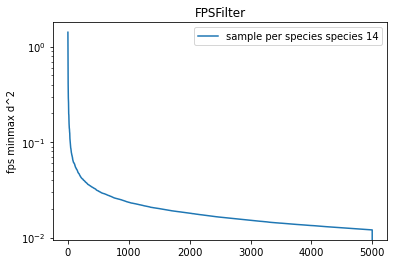

In [28]:
%%time
Nselect = {14:5000}

compressor = FPSFilter(soap, Nselect, act_on='sample per species')

compressor.select(managers)
compressor.plot_fps_error()
# dump_obj(PATH+'fps_samples.json', compressor)

CPU times: user 3min 31s, sys: 5.59 s, total: 3min 36s
Wall time: 3min 34s


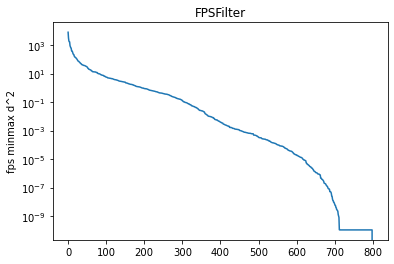

In [61]:
%%time
Nselect = 800

fcompressor = FPSFilter(soap, Nselect, act_on='feature')

fcompressor.select(managers)
fcompressor.plot_fps_error()

In [34]:
# dump_obj(PATH+'fps_features.json', fcompressor)
# dump_obj(PATH+'fps_samples.json', compressor)

In [63]:
# import pickle
# with open(PATH+'fps_features.pck', 'wb') as f:
#     pickle.dump(fcompressor, f)
# with open(PATH+'fps_samples.pck', 'wb') as f:
#     pickle.dump(compressor, f)

In [19]:
fcompressor = frompickle(PATH+'fps_features.pck')
compressor = frompickle(PATH+'fps_samples.pck')

In [16]:
# fcompressor = load_obj(PATH+'fps_features.json')
# compressor = load_obj(PATH+'fps_samples.json')

In [22]:
fcompressor.act_on = 'feature'

In [20]:
for n_feature in  tqdm(n_features):
    sel = fcompressor.filter(managers, n_feature)
    hypers.update(**sel)
    fsoap = SphericalInvariants(**hypers)
    fmanagers = fsoap.transform(frames)
    compressor._representation = fsoap
    for n_sparse in tqdm(n_sparses, leave=False):
        X_sparse = compressor.filter(fmanagers, {14: n_sparse})
        print(n_feature, n_sparse)
        dump_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature), X_sparse)

14 100
14 200
14 500
14 1000
14 2000
14 5000
14 7000
14 9000


35 100
35 200
35 500
35 1000
35 2000
35 5000
35 7000
35 9000


71 100
71 200
71 500
71 1000
71 2000
71 5000
71 7000
71 9000


143 100
143 200
143 500
143 1000
143 2000
143 5000
143 7000
143 9000


286 100
286 200
286 500
286 1000
286 2000
286 5000
286 7000
286 9000


357 100
357 200
357 500
357 1000
357 2000
357 5000
357 7000
357 9000


500 100
500 200
500 500
500 1000
500 2000
500 5000
500 7000
500 9000


715 100
715 200
715 500
715 1000
715 2000
715 5000
715 7000
715 9000



In [31]:
feat_map = soap.get_feature_index_mapping(managers)
diag_feat_map = {key: [] for key in feat_map[0].keys()}
for k,v in feat_map.items():
    if v['n1'] == v['n2']:
        for kk, vv in v.items():
            diag_feat_map[kk].append(int(vv))
n_feature = len(diag_feat_map[kk])
hypers.update(coefficient_subselection=diag_feat_map)
fsoap = SphericalInvariants(**hypers)
fmanagers = fsoap.transform(frames)
compressor._representation = fsoap

for n_sparse in tqdm(n_sparses, leave=False):
    X_sparse = compressor.filter(fmanagers, {14: n_sparse})
    print(n_feature, n_sparse)
    dump_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature), X_sparse)

130 1000
130 2000
130 5000


In [21]:
del managers,fmanagers

## compute KNM

In [45]:
Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures

In [46]:
zeta = 4

In [31]:
(100*300)**2*8/1e9

7.2

In [ ]:
from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(kernel, soap, frames_row, frames_col=None):
    feat_row = soap.transform(frames_row)
    if frames_col not None:
        feat_col = soap.transform(frames_col)
    else:
        feat_col = None
    gahp_kernel = kernel(feat_row, feat_col)
    return gahp_kernel

myK = np.zeros((len(frames),len(frames)))
with ProcessPoolExecutor(max_workers=4) as executor:
    future_to_compute = {}
    # here you need to make split the computation in blocks kernel matrix
    for i_block,frame_i in enumerate(frames):
        for j_block,frame_j in enumerate(frames):
            # pick only the lower diag
            if i_block == j_block:
                future_to_compute[(i_block,j_block)] = executor.submit(compute, kernel, soap, frame_i)
            elif i_block > j_block:
                future_to_compute[(i_block,j_block)] = executor.submit(compute, kernel, soap, frame_i, frame_j)
    # get the results as they come
    pbar = tqdm(total=len(future_to_compute))
    for future in as_completed(future_to_compute):
        (i_block,j_block) = future_to_compute[future]
        # move the block into the kernel matrix
        myK[...] = future.result()
        pbar.update()
    pbar.close()
    

In [ ]:
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
def init_proc():
    global X_pseudos
    X_pseudos = {}
    for n_feature in n_features:
        X_pseudos[n_feature] = {}
        for n_sparse in n_sparses:    
            X_pseudos[n_feature][n_sparse] = load_obj(
                    PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))

a
    X_pseudo = X_pseudos[n_feature][n_sparse]
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    return en_row, grad_rows


ii = 0
with ProcessPoolExecutor(max_workers=24, initializer=init_proc) as executor:
    for n_feature, n_sparse in tqdm(list(product(n_features, n_sparses))):
        print(n_feature, n_sparse)
        KNM = np.zeros((Nstructures+Ngrads, n_sparse))
        
        future_to_compute = {executor.submit(compute, i_frame, frame, n_feature, n_sparse):i_frame
                                                     for i_frame,frame in enumerate(frames)}
        pbar = tqdm(total=len(future_to_compute))
        for future in as_completed(future_to_compute):
            i_frame = future_to_compute[future]
            en_row, grad_rows = future.result()
            KNM[i_frame] = en_row
            KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
            pbar.update()
        pbar.close()
        np.save(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), KNM)


        

130 1000



130 2000


In [14]:
!ls $PATH

fps_features.json     sparse_points_np2000_nf130.json
fps_features.pck      sparse_points_np2000_nf13.json
fps_samples.json      sparse_points_np2000_nf260.json
fps_samples.pck       sparse_points_np2000_nf26.json
KNM_np2000_nf130.npy  sparse_points_np2000_nf650.json
KNM_np2000_nf13.npy   sparse_points_np2000_nf65.json
KNM_np2000_nf260.npy  sparse_points_np2000_nf780.json
KNM_np2000_nf26.npy   sparse_points_np4000_nf130.json
KNM_np2000_nf650.npy  sparse_points_np4000_nf13.json
KNM_np2000_nf65.npy   sparse_points_np4000_nf260.json
KNM_np2000_nf780.npy  sparse_points_np4000_nf26.json
KNM_np4000_nf130.npy  sparse_points_np4000_nf650.json
KNM_np4000_nf13.npy   sparse_points_np4000_nf65.json
KNM_np4000_nf260.npy  sparse_points_np4000_nf780.json
KNM_np4000_nf26.npy   sparse_points_np6000_nf130.json
KNM_np4000_nf650.npy  sparse_points_np6000_nf13.json
KNM_np4000_nf65.npy   sparse_points_np6000_nf260.json
KNM_np4000_nf780.npy  sparse_points_np6000_nf26.json
KNM_np6000_nf130.npy  sparse_points_

## test knm computation

In [19]:
en_field = {
    'qm9': 'dHf_peratom',
    'molecular_crystals': 'ENERGY',
    'silicon_bulk': 'dft_energy',
    'methane_liquid': 'energy',
    'methane_sulfonic': 'energy',
}

force_field = {
    'silicon_bulk': 'dft_force',
}

In [16]:
n_features, n_sparses

([130], [2000])

In [23]:
project = project = signac.get_project('./results/train_model/')
data = []
data_ = []
for job in tqdm(project.find_jobs()):
    aa = {}
    aa['n_features'] = job.sp.feature_subselection['Nselect']
    aa['n_sparse'] = job.sp.sparse_point_subselection['Nselect']['14']
    if not (aa['n_features'] in n_features and aa['n_sparse'] in n_sparses): continue
    sp = _decode(job.statepoint())
    X_pseudo = load_obj(job.fn('sparse_point.json'))
    soap = X_pseudo.representation
    kernel = Kernel(soap,**job.sp['kernel'])
    sp_fn = job.fn('sparse_point.json')

    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = job.sp.train_with_grad
    
    pool = KnmPool(ncpu=24, energy_tag=en_field[job.sp.name], forces_tag=force_field[job.sp.name])
    
    zeta = job.sp['kernel']['zeta']
    knm = pool.run(frames, zeta=zeta, sparse_points_fn=sp_fn, self_contributions=sp['self_contributions'])
    
    knm_p = frompickle(job.fn('knm.pck'))

KNM: 100%|██████████| 2474/2474 [01:19<00:00, 167.52it/s]

In [27]:
np.allclose(knm['energy']['y'],knm_p['energy']['y']),np.allclose(knm['energy']['KNM'],knm_p['energy']['KNM'])

(True, False)

In [28]:
np.allclose(knm['grads']['y'],knm_p['grads']['y']),np.allclose(knm['grads']['KNM'],knm_p['grads']['KNM'])

(True, False)

In [121]:
frames = fromfile('structures/silicon_bulk.json')[1:]

In [40]:
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = job.sp.train_with_grad
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap,**job.sp['kernel'])

In [57]:
lamda_es = [1e-3]
lamda_fs = [1e-2]
cv = KFold(n_splits=4, shuffle=True, random_state=10)

scores = get_cv_scores(cv, knm, frames, kernel, X_pseudo, self_contributions, lamda_es, lamda_fs)


jitter  1e-07 (-16.44690818383953-0.8358528463604248j)
jitter  1e-07 (-18.994797406300318-0.6939255421726221j)
jitter  1e-07 (-17.038101849885926+0j)
jitter  1e-07 (-15.809992356463184+0j)


In [58]:
scores = pd.DataFrame(scores)
scores.groupby(['lambda_e','lambda_f']).mean().sort_values('MAE_e')

MAE_e    RMSE_e     SUP_e      R2_e    CORR_e  \
lambda_e lambda_f                                                     
0.001    0.01      0.872726  1.378507  8.234981 -3.728715  0.252006   

                       MAE_f     RMSE_f         SUP_f          R2_f    CORR_f  
lambda_e lambda_f                                                              
0.001    0.01      17.478087  77.147373  11740.077278 -11108.488585  0.072864

In [122]:
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor


def init_proc(sparse_points_fn, zeta):
    global X_pseudo
    global soap_nograd,soap_grad
    global kernel_grad,kernel_nograd
    # compute_gradient = True
    # zeta = 4
    # sparse_points_fn = sp_fn
    X_pseudo = load_obj(sparse_points_fn)
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = False
    soap_nograd = SphericalInvariants(**hypers)
    hypers['compute_gradients'] = True
    soap_grad = SphericalInvariants(**hypers)
    kernel_grad = Kernel(soap_grad, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    kernel_nograd = Kernel(soap_nograd, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

def compute_gap(frame, compute_gradient, compute_stress, zeta):
    if compute_gradient:
        feat = soap_grad.transform([frame])
        en_row = kernel_grad(feat, X_pseudo)
    else:
        feat = soap_nograd.transform([frame])
        en_row = kernel_nograd(feat, X_pseudo)
    grad_rows = None
    virial_rows = None
    # if compute_gradient and compute_stress:
    #     grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=True)
    #     virial_rows = grad_rows[-6:]
    #     grad_rows = grad_rows[:-6]
    if compute_gradient and not compute_stress:
        # grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=False)
        grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False))
    feat = []
    return en_row, grad_rows, virial_rows


class KnmPool(object):
    def __init__(self, ncpu=1, energy_tag=None, forces_tag=None, stress_tag=None):
        self.ncpu = ncpu
        self.energy_tag = energy_tag
        self.forces_tag = forces_tag
        self.stress_tag = stress_tag

        if self.energy_tag is None:
            raise ValueError('energy_tag should be provided')

    def prepare_run(self,frames,self_contributions,n_sparse,n_frames,n_stress):
        self.Y0 = np.zeros((n_frames,1))
        self.n_atoms = np.zeros((n_frames,1))
        self.n_atoms_v = []
        self.compute_gradient = []
        self.compute_virial = []
        self.energies = []
        self.forces = []
        self.stress = []
        self.n_grad_stride = [0]
        self.n_virial_stride = [0]
        self.frame_ids = {'energy':[],'forces':[],'stress':[]}
        for i_frame, frame in enumerate(frames):
            numbers = frame.get_atomic_numbers()
            self.n_atoms[i_frame] = len(frame)

            for sp in numbers:
                self.Y0[i_frame] += self_contributions[sp]

            if self.energy_tag not in frame.info:
                raise ValueError(
                    'Could not find: "{}" in frame {}'.format(self.energy_tag, i_frame))

            self.energies.append(frame.info[self.energy_tag])
            self.frame_ids['energy'].append(i_frame)
            if self.forces_tag in frame.arrays:
                self.compute_gradient.append(True)
                self.forces.extend(frame.get_array(self.forces_tag).flatten()[:, None])
                self.n_grad_stride.append(len(frame)*3)
                self.frame_ids['forces'].append(i_frame)

            else:
                self.compute_gradient.append(False)
                self.n_grad_stride.append(0)

            if self.stress_tag in frame.info and self.forces_tag in frame.arrays:
                self.compute_virial.append(True)
                stress = -frame.get_volume()* full_3x3_to_voigt_6_stress(frame.info[self.stress_tag])
                self.stress.extend(stress.reshape((n_stress, 1)))
                self.n_virial_stride.append(n_stress)
                self.n_atoms_v.extend([len(frame)]*n_stress)
                self.frame_ids['stress'].append(i_frame)
            else:
                self.compute_virial.append(False)
                self.n_virial_stride.append(0)

        self.n_grad_stride = np.cumsum(self.n_grad_stride)
        self.n_virial_stride = np.cumsum(self.n_virial_stride)

        self.energies = np.asarray(self.energies)[:,None]-self.Y0
        self.grads = -np.asarray(self.forces)
        self.m_virials = -np.asarray(self.stress)
        self.n_atoms_v = np.asarray(self.n_atoms_v).reshape((-1,1))

    def run(self, frames, zeta, sparse_points_fn, self_contributions):
        X_pseudo = load_obj(sparse_points_fn)
        n_sparse = X_pseudo.size()
        n_frames = len(frames)
        n_stress = 6
        self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)

        KNM_e = np.ones((n_frames, n_sparse))
        if self.forces_tag is not None:
            KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
        if self.stress_tag is not None:
            KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
        # compute_gradient = True
        with ThreadPoolExecutor(max_workers=self.ncpu, initializer=init_proc,
                                 initargs=(sparse_points_fn, zeta)) as executor:
            future_to_compute = {executor.submit(
                        compute_gap, frame, compute_gradient, compute_virial, zeta) : i_frame
                        for i_frame,(frame, compute_gradient, compute_virial) in enumerate(zip(
                                                    frames, self.compute_gradient, self.compute_virial))}
            pbar = tqdm(total=len(future_to_compute),leave=False, desc='KNM')
            for future in as_completed(future_to_compute):
                i_frame = future_to_compute[future]
                en_row, grad_rows, virial_rows = future.result()
                KNM_e[i_frame] = en_row
                if grad_rows is not None:
                    KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
                if virial_rows is not None:
                    KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows

                pbar.update()
        result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
        if self.forces_tag is not None:
            result['grads'] = {'KNM':KNM_f, 'y':self.grads}
        if self.stress_tag is not None:
            result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
        return result

    def srun(self, frames, zeta, sparse_points_fn, self_contributions):
        init_proc(sparse_points_fn, zeta)
        # global X_pseudo
        X_pseudo = load_obj(sparse_points_fn)
        n_sparse = X_pseudo.size()
        n_frames = len(frames)
        n_stress = 6
        self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)

        KNM_e = np.ones((n_frames, n_sparse))
        if self.forces_tag is not None:
            KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
        if self.stress_tag is not None:
            KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
        pbar = tqdm(total=n_frames,leave=False, desc='KNM')
        for i_frame, frame in enumerate(frames):
            en_row, grad_rows, virial_rows = compute_gap(frame, self.compute_gradient[i_frame],
                                                         self.compute_virial[i_frame], zeta)
            KNM_e[i_frame] = en_row
            if grad_rows is not None:
                KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
            if virial_rows is not None:
                KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows
            pbar.update()
        result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
        if self.forces_tag is not None:
            result['grads'] = {'KNM':KNM_f, 'y':self.grads}
        if self.stress_tag is not None:
            result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
        return result

In [123]:
sp_fn = PATH+'sparse_points_np{}_nf{}.json'.format(n_sparses[0], n_features[0])
# X_pseudo = load_obj(sp_fn)
# soap = X_pseudo.representation

# hypers = X_pseudo.representation._get_init_params()
# hypers['compute_gradients'] = True

pool = KnmPool(ncpu=18, energy_tag='dft_energy', forces_tag=None)

zeta = 4
knm = pool.srun(frames, zeta=zeta, sparse_points_fn=sp_fn, self_contributions=self_contributions)

In [124]:
np.allclose(knm['energy']['KNM'],KNM[:len(frames)])

False

In [97]:
np.allclose(knm['grads']['KNM'],KNM[len(frames):])



KNM: 100%|██████████| 2474/2474 [14:28<00:00, 19.15it/s]

False

In [126]:
X_pseudo = load_obj(sp_fn)
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = False
soap_nograd = SphericalInvariants(**hypers)
hypers['compute_gradients'] = True
soap_grad = SphericalInvariants(**hypers)
kernel_grad = Kernel(soap_grad, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
kernel_nograd = Kernel(soap_nograd, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [129]:
KNM_e = np.ones((len(frames), X_pseudo.size()))
for i_frame,frame in enumerate(frames):
#     KNM_e[i_frame], grad_rows, virial_rows = compute_gap(frame, False, False, zeta=4)
    feat = soap_grad.transform([frame])
    KNM_e[i_frame] = kernel_grad(feat, X_pseudo)
np.allclose(KNM_e,KNM[:len(frames)])

False

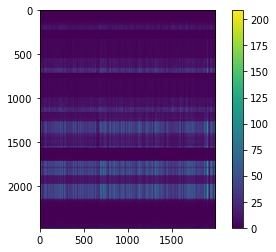

In [118]:
plt.imshow(np.abs(knm['energy']['KNM']-KNM[:len(frames)]))
plt.colorbar()

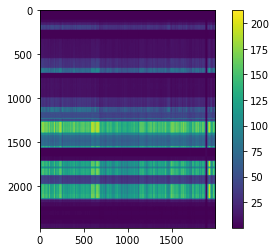

In [119]:
plt.imshow(KNM[:len(frames)])
plt.colorbar()

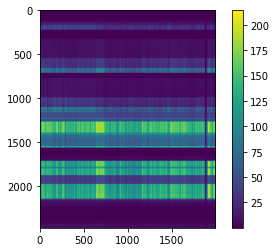

In [120]:
plt.imshow(knm['energy']['KNM'])
plt.colorbar()

## train some models

In [20]:
n_features, n_sparses

([130], [1000, 2000, 5000])

In [21]:
n_feature,n_sparse = n_features[1],n_sparses[3]
zeta = 4

IndexError: list index out of range

In [ ]:
X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
# KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), mmap_mode=None)
KNM = np.load(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), mmap_mode=None)

In [83]:
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [38]:
(frames_train, y_train, f_train, KNM_train), (frames_test, 
                    y_test, f_test, KNM_test) = split_data(frames,KNM, 0.8, seed=200)

In [21]:
Natoms = []
y_baseline = []
for frame in frames_test:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1) 

### energy only

In [83]:
model = train_gap_model_0(kernel, frames_train, KNM_train[:len(frames_train)], X_pseudo, y_train, self_contributions, 
                        grad_train=None, lambdas=[1e-3, 1e-2], jitter=1e-9)
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

jitter  1e-09 (-137.6354054719606+0j)


MAE=7.35e-02 RMSE=1.88e-01 SUP=1.69e+00 R2=9.14e-01 CORR=9.13e-01
MAE=3.23e+00 RMSE=6.74e+00 SUP=2.83e+02 R2=-6.99e+01 CORR=2.16e-01


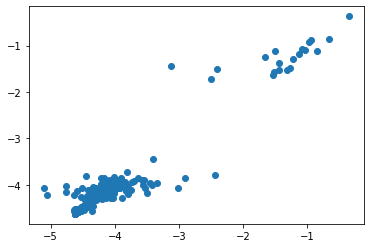

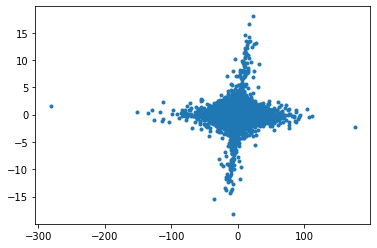

In [84]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

MAE=8.14e-03 RMSE=1.74e-02 SUP=1.68e-01 R2=9.99e-01 CORR=9.98e-01
MAE=2.18e-01 RMSE=3.35e-01 SUP=8.24e+00 R2=8.25e-01 CORR=8.62e-01


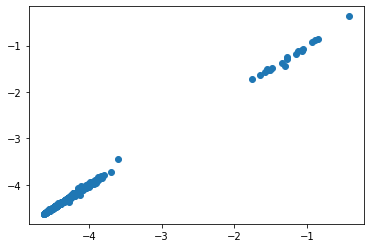

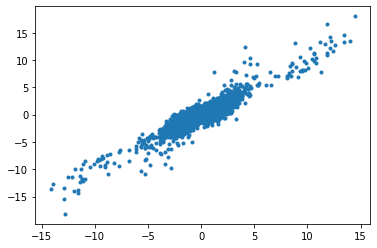

In [46]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

### with forces

In [41]:
model = train_gap_model_0(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[1e-2, 1e-1], jitter=1e-6)
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

(-22.752136852594642+0j)
jitter  23.889743695224375 (-22.752136852594642+0j)


MAE=1.91e-02 RMSE=3.28e-02 SUP=2.70e-01 R2=9.97e-01 CORR=9.93e-01
MAE=2.20e-01 RMSE=3.63e-01 SUP=7.02e+00 R2=7.95e-01 CORR=8.32e-01


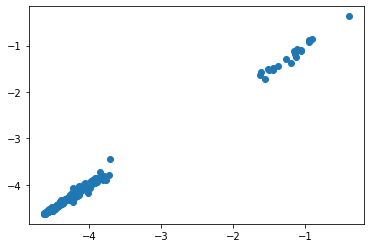

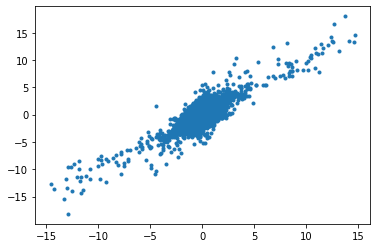

In [42]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

In [106]:
y_baseline.shape

(495,)

MAE=1.02e-02 RMSE=2.20e-02 SUP=2.92e-01 R2=9.99e-01 CORR=9.97e-01


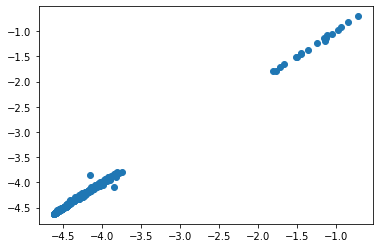

In [108]:
print_score((y_pred-y_baseline)/Natoms, (y_ref-y_baseline)/Natoms)

plt.plot((y_pred-y_baseline)/Natoms, (y_ref-y_baseline)/Natoms, 'o')
plt.show()


### train all the models with fixed regularization

In [45]:
Natoms = []
y_baseline = []

for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
    
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

zeta = 4

y, f = extract_ref(frames,info_key='dft_energy',array_key='dft_force')


In [ ]:
lambdas=[1e-2, 1e-1]
for n_sparse, n_feature  in tqdm(list(product(n_sparses,n_features))):
    X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
    # KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), mmap_mode=None)
    KNM = np.load(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), mmap_mode='r')
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    model = train_gap_model_0(kernel, frames, KNM, X_pseudo, y, self_contributions, 
                        grad_train=-f, lambdas=lambdas, jitter=1e-5)
    dump_obj(PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, 
                                                                          lambdas[0], lambdas[1]),
            model)

29.157933294646156
jitter  1e-05 29.157933294646156
2923.8054366407414
jitter  1e-05 2923.8054366407414
94167.21321505579
jitter  1e-05 94167.21321505579
1008310.0664952439
jitter  1e-05 1008310.0664952439
2318203.811061513
jitter  1e-05 2318203.811061513
2425600.3117751107
jitter  1e-05 2425600.3117751107
2428472.322781496
jitter  1e-05 2428472.322781496
2249189.4667514316
jitter  1e-05 2249189.4667514316
(-0.34793812173653+0j)
jitter  0.36533502782335653 (-0.34793812173653+0j)
19.365204336762517
jitter  1e-05 19.365204336762517
2574.1069112381297
jitter  1e-05 2574.1069112381297
66657.39785571535
jitter  1e-05 66657.39785571535
203458.01314825722
jitter  1e-05 203458.01314825722
219895.21729253986
jitter  1e-05 219895.21729253986
221104.01045076305
jitter  1e-05 221104.01045076305
205967.95590383132
jitter  1e-05 205967.95590383132
(-6.4833947833714385+0j)
jitter  6.8075645225400105 (-6.4833947833714385+0j)
(-3.4980437025577573+0j)
jitter  3.6729458876856453 (-3.4980437025577573+0j)


### find optimal regularization

In [22]:
frames = fromfile('structures/silicon_bulk.json')[1:]

In [23]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape((-1,1))   

In [ ]:
cv = KFold(n_splits=4, shuffle=True, random_state=10)
scores = [] 
zeta = 4
lamda_es = [1e-1,5e-2,1e-2,5e-3,1e-3]
lamda_fs = [0.5,1e-1,5e-2,1e-2,5e-3,1e-3]
ii = 0
for n_sparse, n_feature  in tqdm(list(product(n_sparses,n_features))):
    X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
    KNM = np.load(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), mmap_mode=None)
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    
    scores_ = get_cv_scores(cv, KNM, frames, kernel, X_pseudo,
                           self_contributions, lamda_es, lamda_fs, **{'n_sparse':n_sparse, 'n_feature':n_feature})
    scores.extend(scores_)
    topickle(PATH+'cv-scores.pck', scores)
scores = pd.DataFrame(scores)

In [116]:
inps = []
for idp, (n_sparse, n_feature) in enumerate(product(n_sparses,n_features)):
    aa = scores.query("tag=={}".format(idp))
    if np.unique(aa['n_sparse'])[0] != n_sparse or np.unique(aa['n_feature'])[0] != n_feature:
        inps.append((idp,n_feature,n_sparse,zeta))
inps

[(1, 35, 100, 4),
 (6, 500, 100, 4),
 (7, 715, 100, 4),
 (11, 143, 200, 4),
 (12, 286, 200, 4),
 (24, 14, 1000, 4),
 (25, 35, 1000, 4),
 (26, 71, 1000, 4),
 (31, 715, 1000, 4),
 (32, 14, 2000, 4),
 (33, 35, 2000, 4),
 (34, 71, 2000, 4),
 (40, 14, 5000, 4),
 (41, 35, 5000, 4),
 (42, 71, 5000, 4),
 (43, 143, 5000, 4),
 (48, 14, 7000, 4),
 (49, 35, 7000, 4),
 (56, 14, 9000, 4),
 (57, 35, 9000, 4),
 (60, 286, 9000, 4)]

In [24]:
zeta = 4
lamda_es = [1e-1,5e-2,1e-2,5e-3,1e-3]
lamda_fs = [0.5,1e-1,5e-2,1e-2,5e-3,1e-3]

scores = []
computed_ids = []
# scores = frompickle(PATH+'/cv-scores.pck')
# computed_ids = np.unique([sc['tag'] for sc in scores])

def compute_score(n_feature, n_sparse, zeta):
    frames = fromfile('structures/silicon_bulk.json')[1:]
    cv = KFold(n_splits=4, shuffle=True, random_state=10)
    X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
    KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), mmap_mode=None)
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    
    scores_ = get_cv_scores(cv, KNM, frames, kernel, X_pseudo,
                           self_contributions, lamda_es, lamda_fs, **{'n_sparse':n_sparse, 'n_feature':n_feature})
    return scores_


inps = []
for idp, (n_sparse, n_feature) in enumerate(product(n_sparses, n_features)):
    if idp in computed_ids: continue
    inps.append((idp,n_feature, n_sparse, zeta))
np.random.seed(100)
np.random.shuffle(inps)

with ProcessPoolExecutor(max_workers=3) as executor:
    with tqdm(total=len(inps)) as pbar:
        future_to_compute = {}
        for idp,n_feature, n_sparse, zeta in inps:
            if idp in computed_ids: continue
            future = executor.submit(compute_score, n_feature, n_sparse, zeta)
            future.add_done_callback(lambda p: pbar.update())
            future_to_compute[future] = idp

        for future in as_completed(future_to_compute):
            idp = future_to_compute[future]
            scores_ = future.result()
            for sc in scores_:
                sc.update(tag=idp)
            scores.extend(scores_)
            topickle(PATH+'cv-scores-2.pck', scores)
        
scores = pd.DataFrame(scores)

In [37]:
# scores = pd.read_json(PATH+'cv-score-2.json')
scores = pd.DataFrame(frompickle(PATH+'cv-scores-2.pck'))
best_scores = scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).drop(columns=['tag'])
best_scores

MAE_e    RMSE_e     SUP_e  \
tag n_feature n_sparse lambda_e lambda_f                                 
0   130       1000     0.005    0.5       0.003747  0.008675  0.092764   
1   130       2000     0.005    0.5       0.002841  0.006692  0.087304   
2   130       5000     0.001    0.1       0.002598  0.006433  0.077823   

                                              R2_e    CORR_e     MAE_f  \
tag n_feature n_sparse lambda_e lambda_f                                 
0   130       1000     0.005    0.5       0.999805  0.999524  0.108387   
1   130       2000     0.005    0.5       0.999888  0.999690  0.090831   
2   130       5000     0.001    0.1       0.999896  0.999708  0.083282   

                                            RMSE_f     SUP_f      R2_f  \
tag n_feature n_sparse lambda_e lambda_f                                 
0   130       1000     0.005    0.5       0.174555  3.352726  0.952157   
1   130       2000     0.005    0.5       0.147695  2.663433  0.965783   
2   130       5000     0.001    0.1       0.134511  2.507984  0.971591   

                                            CORR_f  
tag n_feature n_sparse lambda_e lambda_f            
0   130       1000     0.005    0.5       0.944806  
1   130       2000     0.005    0.5       0.956187  
2   130       5000     0.001    0.1       0.961664

In [28]:
scores = pd.read_json(PATH+'cv-score-all.json')
best_scores = scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).drop(columns=['tag']).sort_values(['RMSE_e'])
best_scores

index     MAE_e    RMSE_e     SUP_e  \
tag n_feature n_sparse lambda_e lambda_f                                        
62  500       9000     0.005    0.10       3000  0.002448  0.004934  0.051579   
61  357       9000     0.001    0.05       3166  0.002218  0.004939  0.055229   
60  286       9000     0.001    0.05       1646  0.002232  0.004978  0.059575   
63  715       9000     0.001    0.05       1806  0.002213  0.004982  0.059631   
53  357       7000     0.005    0.10       5000  0.002490  0.005043  0.053928   
...                                         ...       ...       ...       ...   
48  14        7000     0.005    0.50       1319  0.014907  0.030314  0.290094   
56  14        9000     0.005    0.50       1479  0.014981  0.030541  0.293228   
16  14        500      0.005    0.50       4439  0.014897  0.030553  0.299634   
8   14        200      0.001    0.05       3486  0.015673  0.031129  0.315129   
0   14        100      0.001    0.50        524  0.017611  0.035748  0.377615   

                                              R2_e    CORR_e     MAE_f  \
tag n_feature n_sparse lambda_e lambda_f                                 
62  500       9000     0.005    0.10      0.999939  0.999775  0.053928   
61  357       9000     0.001    0.05      0.999939  0.999807  0.060122   
60  286       9000     0.001    0.05      0.999938  0.999808  0.060543   
63  715       9000     0.001    0.05      0.999938  0.999810  0.060226   
53  357       7000     0.005    0.10      0.999937  0.999773  0.054403   
...                                            ...       ...       ...   
48  14        7000     0.005    0.50      0.997630  0.995279  0.286676   
56  14        9000     0.005    0.50      0.997589  0.995239  0.286745   
16  14        500      0.005    0.50      0.997583  0.995297  0.288689   
8   14        200      0.001    0.05      0.997525  0.994776  0.257520   
0   14        100      0.001    0.50      0.996737  0.993973  0.368807   

                                            RMSE_f      SUP_f      R2_f  \
tag n_feature n_sparse lambda_e lambda_f                                  
62  500       9000     0.005    0.10      0.089699   2.194564  0.987361   
61  357       9000     0.001    0.05      0.099772   2.497076  0.984360   
60  286       9000     0.001    0.05      0.100200   2.400151  0.984228   
63  715       9000     0.001    0.05      0.099868   2.519951  0.984334   
53  357       7000     0.005    0.10      0.090442   2.173296  0.987151   
...                                            ...        ...       ...   
48  14        7000     0.005    0.50      0.455539  10.728220  0.674448   
56  14        9000     0.005    0.50      0.455449  10.481806  0.674569   
16  14        500      0.005    0.50      0.458562  11.393713  0.670117   
8   14        200      0.001    0.05      0.417061  12.231719  0.727299   
0   14        100      0.001    0.50      0.576853  12.938144  0.476331   

                                            CORR_f  
tag n_feature n_sparse lambda_e lambda_f            
62  500       9000     0.005    0.10      0.980453  
61  357       9000     0.001    0.05      0.976649  
60  286       9000     0.001    0.05      0.976370  
63  715       9000     0.001    0.05      0.976559  
53  357       7000     0.005    0.10      0.980215  
...                                            ...  
48  14        7000     0.005    0.50      0.760537  
56  14        9000     0.005    0.50      0.760426  
16  14        500      0.005    0.50      0.757969  
8   14        200      0.001    0.05      0.788077  
0   14        100      0.001    0.50      0.674042  

[64 rows x 11 columns]

In [38]:
frames = fromfile('structures/silicon_bulk.json')[1:]
y_train, f_train = extract_ref(frames,'dft_energy','dft_force')
zeta = 4
for (tag, n_feature , n_sparse , lambda_e , lambda_f) in tqdm(best_scores.transpose().to_dict()):
    fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(
                                        zeta, n_feature, n_sparse,lambda_e , lambda_f)
    if os.path.exists(fn): continue
    
    X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
    KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta,n_sparse, n_feature), mmap_mode='r')
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    
    model = train_gap_model_0(kernel, frames, KNM, X_pseudo, y_train, self_contributions, grad_train=-f_train, 
                    lambdas=[lambda_e , lambda_f], jitter=1e-8)
    dump_obj(fn, model)

In [97]:
!ls $PATH/model_z4_np35_nf100*

./results/mlip_Si_rc5_n10_l12_g0.5_gto//model_z4_np35_nf1000_lmde1e-03_lmdf1e-01.json


In [ ]:
scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).min

In [30]:
scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().sort_values('RMSE_e').head(50)

MAE_e    RMSE_e     SUP_e      R2_e  \
n_feature n_sparse lambda_e lambda_f                                           
715       9000     0.001    0.050     0.002213  0.004982  0.059631  0.999938   
                   0.010    0.500     0.002208  0.005035  0.063986  0.999937   
                   0.005    0.100     0.002480  0.005078  0.056360  0.999936   
357       5000     0.010    0.500     0.002254  0.005123  0.063060  0.999934   
715       9000     0.001    0.100     0.002189  0.005169  0.063804  0.999932   
357       5000     0.001    0.050     0.002257  0.005175  0.062858  0.999933   
715       9000     0.010    0.100     0.002801  0.005209  0.049893  0.999933   
                   0.050    0.500     0.002781  0.005210  0.050504  0.999932   
                   0.005    0.500     0.002166  0.005214  0.066916  0.999931   
                   0.001    0.010     0.002804  0.005221  0.048513  0.999932   
                   0.005    0.050     0.002833  0.005307  0.054074  0.999930   
357       5000     0.001    0.100     0.002232  0.005448  0.075764  0.999926   
                   0.005    0.100     0.002586  0.005543  0.068935  0.999923   
                            0.500     0.002245  0.005594  0.077730  0.999922   
715       2000     0.005    0.500     0.002519  0.005647  0.058995  0.999920   
143       9000     0.010    0.500     0.002559  0.005699  0.070538  0.999919   
357       5000     0.050    0.500     0.003032  0.005841  0.061861  0.999915   
                   0.001    0.010     0.003027  0.005855  0.057871  0.999914   
                   0.005    0.050     0.003092  0.005868  0.064216  0.999915   
143       9000     0.005    0.500     0.002523  0.005879  0.067383  0.999914   
715       9000     0.001    0.005     0.003345  0.005881  0.054221  0.999914   
                   0.100    0.500     0.003364  0.005907  0.050118  0.999913   
          2000     0.001    0.100     0.002507  0.005915  0.071861  0.999913   
143       9000     0.001    0.050     0.002586  0.005928  0.077572  0.999912   
357       5000     0.010    0.100     0.003024  0.005968  0.072262  0.999911   
143       9000     0.001    0.100     0.002538  0.006015  0.073262  0.999910   
715       9000     0.010    0.050     0.003371  0.006024  0.054780  0.999910   
143       9000     0.005    0.100     0.002808  0.006056  0.074788  0.999908   
                   0.010    0.100     0.003225  0.006369  0.075995  0.999898   
                   0.050    0.500     0.003227  0.006394  0.074098  0.999897   
                   0.001    0.010     0.003259  0.006460  0.075608  0.999895   
                   0.005    0.050     0.003244  0.006471  0.078515  0.999894   
357       5000     0.001    0.500     0.002544  0.006513  0.080943  0.999891   
715       9000     0.001    0.500     0.002521  0.006627  0.090947  0.999887   
          2000     0.001    0.500     0.002770  0.006688  0.077784  0.999888   
                   0.005    0.100     0.003198  0.006883  0.081914  0.999883   
143       9000     0.010    0.050     0.003869  0.006976  0.069180  0.999878   
                   0.100    0.500     0.003852  0.006998  0.072993  0.999877   
357       1000     0.005    0.500     0.002974  0.007024  0.085342  0.999876   
                   0.001    0.100     0.002974  0.007080  0.086189  0.999874   
143       9000     0.001    0.005     0.003884  0.007092  0.073145  0.999874   
715       2000     0.010    0.500     0.003034  0.007094  0.089925  0.999874   
143       9000     0.001    0.500     0.002866  0.007176  0.094342  0.999872   
357       1000     0.010    0.500     0.003271  0.007420  0.086741  0.999861   
                   0.001    0.050     0.003270  0.007423  0.086815  0.999861   
715       9000     0.005    0.010     0.004882  0.007946  0.060366  0.999844   
                   0.050    0.100     0.004775  0.007985  0.064505  0.999841   
357       5000     0.010    0.050     0.004275  0.008283  0.077186  0.999826   
715       2000     0.010    0.100     0.0

## train some models with virials

In [14]:
n_feature,n_sparse = n_features[3],n_sparses[0]
sp_fn = PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature)
n_feature,n_sparse

(130, 2000)

In [15]:
pool = KnmPool(ncpu=4, energy_tag='dft_energy', forces_tag='dft_force')

In [16]:
res_t = pool.run(frames_train, zeta=4, sparse_points_fn=sp_fn, self_contributions=self_contributions)
res_v = pool.run(frames_test, zeta=4, sparse_points_fn=sp_fn, self_contributions=self_contributions)

In [ ]:
# import pickle as pck
# with open(PATH+'KNM_z4_np{}_nf{}.pck'.format(n_feature,n_sparse),'wb') as f:
#     pck.dump(res, f,protocol=4)
# with open(PATH+'KNM_z4_np{}_nf{}.pck'.format(n_feature,n_sparse),'rb') as f:
#     res = pck.load(f)

In [21]:
X_pseudo = load_obj(sp_fn)
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=4, target_type='Structure', kernel_type='Sparse')

[autoreload of pandas failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/__init__.py", line

[autoreload of pandas.core.arrays.base failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/c

[autoreload of pandas.core.arrays.timedeltas failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pa

[autoreload of pandas.core.window.rolling failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/panda

[autoreload of pandas.core.reshape.melt failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/

[autoreload of pandas._testing failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/_testing.

In [34]:
model = train_gap_model(kernel, X_pseudo, res_t['energy'], self_contributions, 
                        grads=res_t['grads'], stress=res_t['stress'],
                    lambdas=[1e-3, 1e-2], jitter=1e-6)

/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: overflow encountered in multiply


LinAlgError: Array must not contain infs or NaNs

In [76]:
Ntest = len(frames_test)
y_pred = model.predict(frames_test, res_v['energy']['KNM'])
f_pred = -model.predict(frames_test, res_v['grads']['KNM'], compute_gradients=True, compute_stress=True)
s_pred = f_pred[-(Ntest*6):]
f_pred = f_pred[:-(Ntest*6)]

(110685, 1)


MAE=7.74e-03 RMSE=1.65e-02 SUP=2.13e-01 R2=9.99e-01 CORR=9.98e-01
MAE=2.29e-01 RMSE=3.46e-01 SUP=5.22e+00 R2=7.94e-01 CORR=8.28e-01


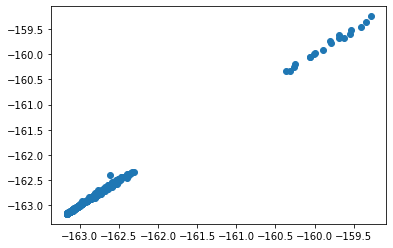

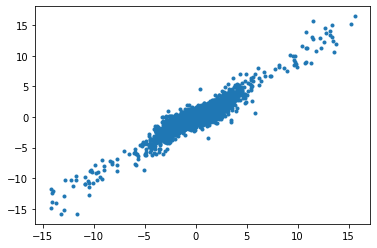

In [77]:
Natoms = res_v['energy']['n_atoms'].flatten()
print_score(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms)
print_score(f_pred.flatten(), -res_v['grads']['y'].flatten())
plt.plot(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), -res_v['grads']['y'].flatten(), 'o',ms=3)

MAE=7.52e-03 RMSE=2.27e-02 SUP=3.52e-01 R2=9.99e-01 CORR=9.98e-01
MAE=3.73e-01 RMSE=7.03e-01 SUP=2.87e+01 R2=1.47e-01 CORR=7.15e-01


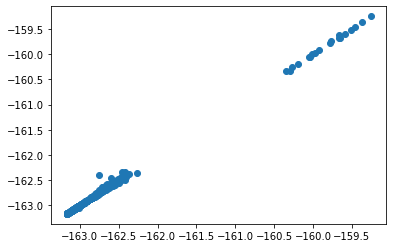

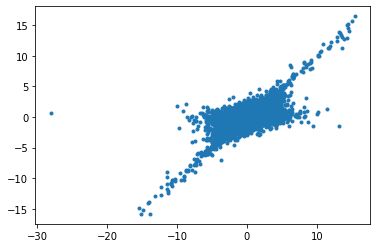

In [55]:
Natoms = res_v['energy']['n_atoms'].flatten()
print_score(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms)
print_score(f_pred.flatten(), -res_v['grads']['y'].flatten())
plt.plot(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), -res_v['grads']['y'].flatten(), 'o',ms=3)

# Run molecular dynamics on bulk Si

In [16]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units,Atoms
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.lattice.cubic import FaceCenteredCubic

In [17]:
from rascal.utils.io import load_obj
from rascal.models import KRR, ASEMLCalculator



In [18]:
model_fn = '/home/musil/nickel_potential/models/radial_scaling/model_rc6_n12_l7_g0.4_gto_r02_exp3_z2_lmbe1e-03_lmbf5e-02.json'
model = load_obj(model_fn)
model.self_contributions = {int(k):v for k,v in model.self_contributions.items()}
calc = ASEMLCalculator(model, model.kernel._rep)

In [24]:
%%time
log_fn = 'md.log'
filename = 'md.traj'

T = 400
time_step = 0.5 * units.fs
length = 10 * units.fs
n_step = int(length/time_step)
print(f'doing Nsteps: {n_step}')

aNi_gap = 3.514882399228899
atoms = Atoms(FaceCenteredCubic(directions=[[0,0,1], [0,-1,0], [1,0,0]],size=(3,3,3), 
                                symbol='Ni', pbc=(1,1,1), latticeconstant=aNi_gap))

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, time_step, units.kB * T, 0.002)

# dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
#            peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=100)

dyn.run(n_step)

doing Nsteps: 20
CPU times: user 5min 15s, sys: 10.6 s, total: 5min 25s
Wall time: 3min 37s


True

# Test the model on dimer configurations

In [117]:
soap = kernel._rep

In [118]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[14,14]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

Number of configurations:  40


In [119]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
e_pairs = model.predict(frames,KNM)
e_pairs -= e_pairs.mean()

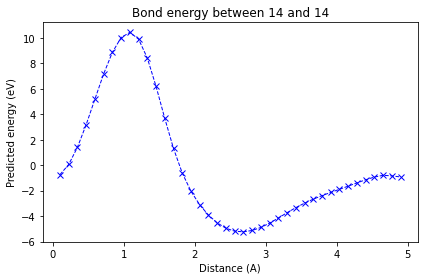

In [120]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# test bulk prop

In [15]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter

## utils

In [81]:
from rascal.utils.io import load_obj
from rascal.models import KRR
from rascal.models.IP_ase_interface import ASEMLCalculator

In [82]:
eUnitDict={'Ry':2.17987,'eV':0.1602} #conversion to joule 10e-21
pUnitDict={'Gpa':1000,'kbar':10000}
alatUnitDict={'A':1.,'Bohr':0.529177} #conversion to m 10e-30
jouleToEv=6.2415091

In [83]:
def Murnaghan(parameters, vol):
    'From Phys. Rev. B 28, 5480 (1983)'
    B0, BP, V0 = parameters
    B0=B0/1000
    E = B0 * vol / BP * (((V0 / vol)**BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E

def BMurnaghan(parameters, vol):
    B0, BP, V0 = parameters
    B0=B0/1000
    E = 9.*B0 * V0/16.*(((V0/vol)**(2./3.)-1.)**3*BP+((V0/vol)**(2./3.)-1.)**2*(6.-4.*(V0/vol)**(2./3.)))

    return E

def BMurnaghan_shift(parameters, vol):
    B0, BP, V0 = parameters
    E0 = 400
    B0=B0/1000
    E = 9.*B0 * V0/16.*(((V0/vol)**(2./3.)-1.)**3*BP+((V0/vol)**(2./3.)-1.)**2*(6.-4.*(V0/vol)**(2./3.))) - E0
    return E

def BMpres(parameters, vol):
    B0, BP, V0 = parameters
    B0=B0/1000
    P = 3*B0/2*((V0/vol)**(7/3)-(V0/vol)**(5/3))*(1+3/4*(BP-4)*((V0/vol)**(2/3)-1))
    return P
def objective(pars, y, x, ff):
    #we will minimize this function
    return {
        'BM': y - BMurnaghan(pars, x),
        'M': y - Murnaghan(pars, x),
        'BMp': y - BMpres(pars, x) 
    }[ff]

In [84]:
def f(x, ab):
    y = x*ab[0]+ab[1]
    return y

## ref

In [121]:
from rascal.utils import BaseIO
from ase.calculators.calculator import Calculator, all_changes
from copy import deepcopy
from rascal.neighbourlist.structure_manager import AtomsList, unpack_ase


class ASEMLCalculator(Calculator, BaseIO):
    """Wrapper class to use a rascal model as an interatomic potential in ASE

    Parameters
    ----------
    model : class
        a trained model of the rascal library that can predict the energy and
        derivaties of the energy w.r.t. atomic positions
    representation : class
        a representation calculator of rascal compatible with the trained model
    """

    implemented_properties = ['energy', 'forces','stress']
    'Properties calculator can handle (energy, forces, ...)'

    default_parameters = {}
    'Default parameters'

    nolabel = True

    def __init__(self, model, representation, **kwargs):
        super(ASEMLCalculator, self).__init__(**kwargs)
        self.model = model
        self.representation = representation
        self.kwargs = kwargs
        self.manager = None

    def calculate(self, atoms=None, properties=['energy', 'forces','stress'],
                  system_changes=all_changes):
        Calculator.calculate(self, atoms, properties, system_changes)

        if self.manager is None:
            # happens at the begining of the MD run
            at = self.atoms.copy()
            at.wrap(eps=1e-11)
            self.manager = [at]
        elif isinstance(self.manager, AtomsList):
            structure = unpack_ase(self.atoms, wrap_pos=True)
            structure.pop('center_atoms_mask')
            self.manager[0].update(**structure)

        self.manager = self.representation.transform(self.manager)

        energy = self.model.predict(self.manager)
        self.results['energy'] = energy
        self.results['free_energy'] = energy

        forces = -self.model.predict(self.manager, compute_gradients=True)
        # KNM, Y0 = self.model._preprocess_input(self.manager, None, compute_gradients=True)
        # forces = -self.model.predict(self.manager, KNM, compute_gradients=True)
        self.results['forces'] = forces
        
        KNM, Y0 = self.model._preprocess_input(self.manager, None, compute_gradients=True)
        pos = self.atoms.get_positions()
        S = np.zeros((3,3,KNM.shape[1]))
        for i_atom in range(pos.shape[0]):
            S += np.multiply.outer(pos[i_atom], KNM[3*i_atom:3*(i_atom+1)])
        
        S = np.einsum('ijk, k -> ij', S, self.model.weights.flatten())
        S += S.T
        S *= - 0.5 / self.atoms.get_volume()
        self.results['stress'] = S.flat[[0, 4, 8, 5, 2, 1]] 

    def _get_init_params(self):
        init_params = dict(model=self.model, representation=self.representation)
        init_params.update(**self.kwargs)
        return init_params

    def _set_data(self, data):
        self.manager = None
        super()._set_data(data)

    def _get_data(self):
        return super()._get_data()

In [122]:
calc = ASEMLCalculator(model, soap)

In [127]:
latticeconstant = 5.457112117669545
latticeconstant = 3.
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-4)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(),enRef, volRef

(24, 1)
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:06:19    -1283.651240*       0.0000


(Cell([3.0, 3.0, 3.0]), array([-1283.65124028]), 27.0)

In [129]:
atoms.get_stress()

array([2.70246030e-14, 4.70092928e-14, 1.29465419e-14, 4.22353011e-14,
       2.22165153e-14, 4.15100273e-14])

In [87]:
eUnits="eV"#"Ry","eV"
alatUnits="A"#"A","Bohr"
presUnits="GPa"#"GPa"
fittingFunction="BM" # BM --  BMurnaghan EOS (E vs V), M -- Murnaghan EOS (E vs V) , BMp -- BMurnaghan EOS (P vs V)
##Initial guess for fitting parameters
##B0 [GPa], BP[], V0[A3]
# x0=[204.318343, 4.86383445e+00 ,1.17513591e+03]
evAm3ToGpa = 160.21766

## bulk

Fitting function = BM
Fitted parameters: B0 = 133.28695137201868,GPa;BP = 11.908091708976874;V0 = 54.69423878329379,A^3


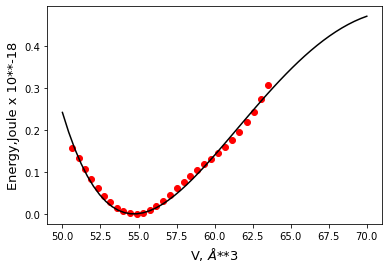

In [50]:
acell = np.arange(3.7,4.,0.01)
enBulk = np.zeros(len(acell))
volBulk = np.zeros(len(acell))
frames = []
for ii,latticeconstant in enumerate(acell):
#     atoms = ase.Atoms(Diamond(directions=[[1,0,0], [0,1,0], [0,0,1]],size=(1,1,1), symbol='Si', 
#                           pbc=(1,1,1), latticeconstant=latticeconstant))
    atoms = bulk('Si', 'fcc', a=latticeconstant, cubic=True)
    frames.append(atoms)
    volBulk[ii] = atoms.get_volume() 

X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enBulk = model.predict(frames,KNM)

vols = volBulk*alatUnitDict[alatUnits]**3
energies=(enBulk-min(enBulk))*eUnitDict[eUnits]

dataToFit=energies
x0=[200., 1.1, 55]
plsq = leastsq(objective, x0, args=(dataToFit, vols, fittingFunction))

print('Fitting function = '+fittingFunction)
print('Fitted parameters: B0 = '+format(plsq[0][0])+',GPa;'+ 'BP = '+format(plsq[0][1])+';V0 = ' +format(plsq[0][2])+',A^3')


plt.plot(vols,dataToFit*jouleToEv, 'ro')
x = np.linspace(50, 70, 50)

y = {'BM':BMurnaghan(plsq[0], x),'M':Murnaghan(plsq[0], x),'BMp':BMpres(plsq[0], x)}
plt.plot(x, y[fittingFunction]*jouleToEv, 'k-')
plt.xlabel('V, $\AA$**3', fontsize = 13)
if fittingFunction=='BMp':
    plt.ylabel('Press,MPa')
else:
    plt.ylabel('Energy,Joule x 10**-18', fontsize = 13)
plt.show()
BulkMod = plsq[0][0]

In [56]:
np.power(54.69423878329379,1/3)

3.795892116365245

Fitting function = BM
Fitted parameters: B0 = 11.427250617739316,GPa;BP = 2.977748401128606;V0 = 162.5052213130929,A^3


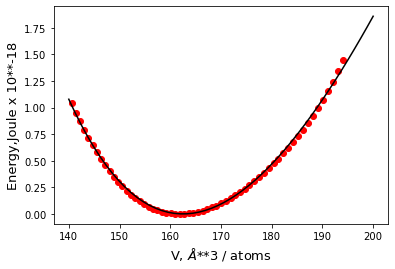

In [54]:
acell = np.arange(5.2,5.8,0.01)
enBulk = np.zeros(len(acell))
volBulk = np.zeros(len(acell))
frames = []
for ii,latticeconstant in enumerate(acell):
#     atoms = ase.Atoms(Diamond(directions=[[1,0,0], [0,1,0], [0,0,1]],size=(1,1,1), symbol='Si', 
#                           pbc=(1,1,1), latticeconstant=latticeconstant))
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    frames.append(atoms)
    volBulk[ii] = atoms.get_volume()

X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enBulk = model.predict(frames,KNM)

vols = volBulk*alatUnitDict[alatUnits]**3
energies=(enBulk-min(enBulk))*eUnitDict[eUnits]

dataToFit=energies
x0=[200., 1.1, 160]
plsq = leastsq(objective, x0, args=(dataToFit, vols, fittingFunction))

print('Fitting function = '+fittingFunction)
print('Fitted parameters: B0 = '+format(plsq[0][0]/len(atoms))+',GPa;'+ 'BP = '+format(plsq[0][1])+';V0 = ' +format(plsq[0][2])+',A^3')


plt.plot(vols,dataToFit*jouleToEv, 'ro')
x = np.linspace(140, 200, 50)

y = {'BM':BMurnaghan(plsq[0], x),'M':Murnaghan(plsq[0], x),'BMp':BMpres(plsq[0], x)}
plt.plot(x, y[fittingFunction]*jouleToEv, 'k-')
plt.xlabel('V, $\AA$**3 / atoms', fontsize = 13)
if fittingFunction=='BMp':
    plt.ylabel('Press,MPa')
else:
    plt.ylabel('Energy,Joule x 10**-18', fontsize = 13)
plt.show()
BulkMod = plsq[0][0]

In [55]:
np.power(162.5052213130929,1/3)

5.4570228608739155

## C11-C22

In [95]:
acellC11c12 = np.arange(0.0,0.1,0.003)
enC11c12 = np.zeros(len(acellC11c12))
volC11c12 = np.zeros(len(acellC11c12))
latticeconstant = 5.4570228608739155
k = 0
frames = []
for delta in acellC11c12:
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    coords_scaled = atoms.get_scaled_positions().copy()
    atoms.set_cell([[latticeconstant*(1+delta), 0, 0],[0, latticeconstant*(1-delta),0],[0, 0, latticeconstant*(1+delta**2/(1-delta**2))]])
    atoms.set_scaled_positions(coords_scaled)
    frames.append(atoms)
    volC11c12[k] = atoms.get_volume()
    k+=1
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enC11c12 = model.predict(frames,KNM)

In [96]:
UC11c12 = (enC11c12-enRef)/volC11c12*evAm3ToGpa
coeffC11c12 = np.polyfit(acellC11c12**2,UC11c12,1 )
C11c12 = coeffC11c12[0]
print("C11-C12 = ", C11c12, "GPa")

C11-C12 =  82.08429976997142 GPa


In [59]:
ref = 97.0
(C11c12-ref)/ref * 100

-5.121995233214265

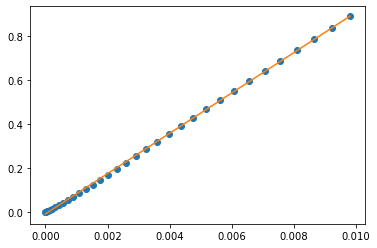

In [60]:
plt.plot(acellC11c12**2, UC11c12, 'o')
plt.plot(acellC11c12**2, f(acellC11c12**2., coeffC11c12))

## C44

In [98]:
acellC44 = np.arange(0.0,0.1,0.003)
enC44 = np.zeros(len(acellC44))
volC44 = np.zeros(len(acellC44))
latticeconstant = 5.4570228608739155
k = 0
frames = []
for delta in acellC44:
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    coords_scaled = atoms.get_scaled_positions().copy()
    atoms.set_cell([[latticeconstant, latticeconstant*0.5*delta, 0],
                    [latticeconstant*0.5*delta, latticeconstant,0],
                    [0, 0, latticeconstant*(1+delta**2/(4-delta**2))]])
    atoms.set_scaled_positions(coords_scaled)
    frames.append(atoms)
    volC44[k] = atoms.get_volume()
    k+=1
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enC44 = model.predict(frames,KNM)

In [99]:
UC44 = 2*(enC44-enRef)/volC44*evAm3ToGpa
coeffC44 = np.polyfit(acellC44**2,UC44,1 )
C44 = coeffC44[0]
print("C44 = ", C44, "GPa")

C44 =  112.3839987349812 GPa


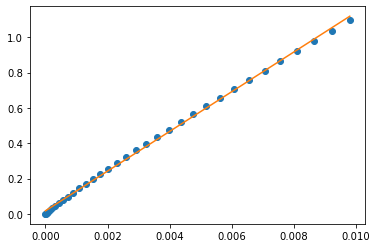

In [100]:
plt.plot(acellC44**2, UC44, 'o')
plt.plot(acellC44**2, f(acellC44**2., coeffC44))

In [72]:
ref = 72.2
(C44-ref)/ref * 100

24.529891805938266

# compute bulk prop on all models

In [11]:
from rascal.utils.io import load_obj
from rascal.models import KRR
from rascal.models.IP_ase_interface import ASEMLCalculator

In [12]:
import numpy as np
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.build import bulk
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState
from ase.lattice.cubic import Diamond


## try out the generated models

{n_features: 130, n_sparse: 100, range: [5.0,5.6]},


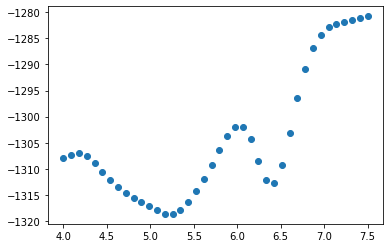

{n_features: 26, n_sparse: 100, range: [6.9,7.5]},


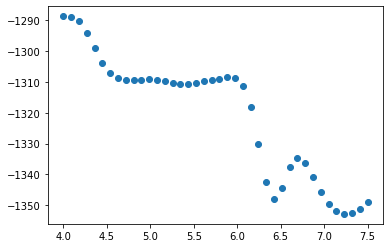

{n_features: 650, n_sparse: 2000, range: [6.1,6.7]},


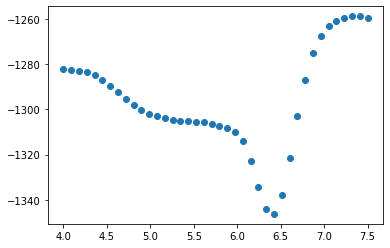

{n_features: 909, n_sparse: 2000, range: [7.2,7.8]},


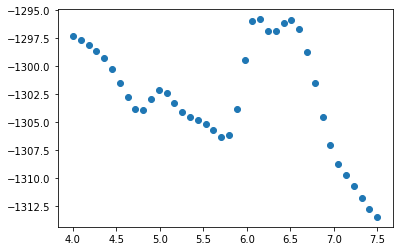

{n_features: 909, n_sparse: 5000, range: [5.4,6.0]},


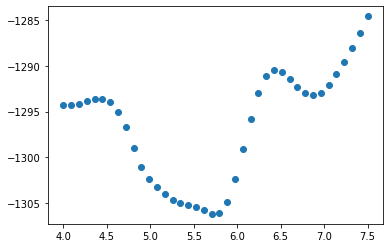

{n_features: 260, n_sparse: 100, range: [5.0,5.6]},


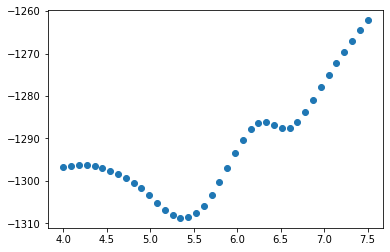

{n_features: 13, n_sparse: 2000, range: [7.2,7.8]},


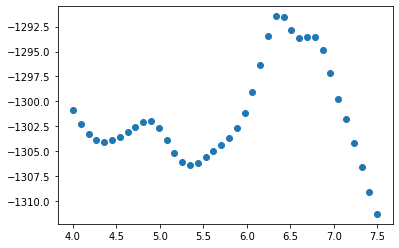

{n_features: 909, n_sparse: 200, range: [5.1,5.7]},


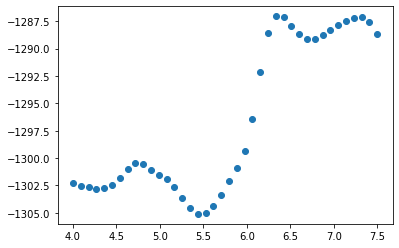

{n_features: 909, n_sparse: 7000, range: [5.1,5.7]},


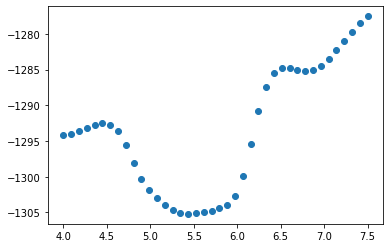

{n_features: 260, n_sparse: 200, range: [6.2,6.8]},


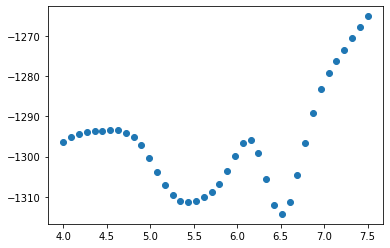

{n_features: 65, n_sparse: 500, range: [6.1,6.7]},


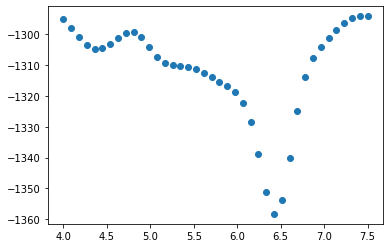

{n_features: 26, n_sparse: 9000, range: [6.5,7.1]},


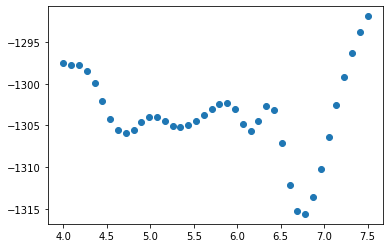

{n_features: 260, n_sparse: 9000, range: [6.2,6.8]},


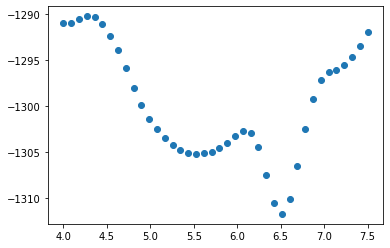

{n_features: 65, n_sparse: 9000, range: [5.4,6.0]},


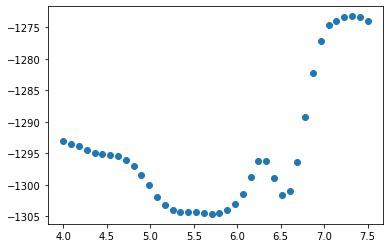

{n_features: 650, n_sparse: 5000, range: [5.7,6.3]},


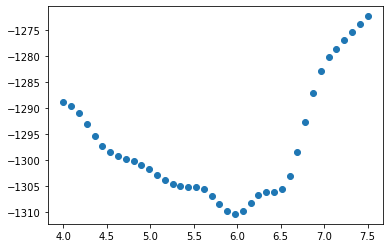

{n_features: 13, n_sparse: 5000, range: [6.1,6.7]},


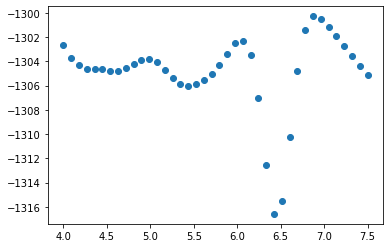

{n_features: 26, n_sparse: 2000, range: [5.1,5.7]},


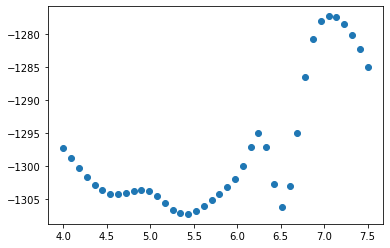

{n_features: 65, n_sparse: 5000, range: [6.1,6.7]},


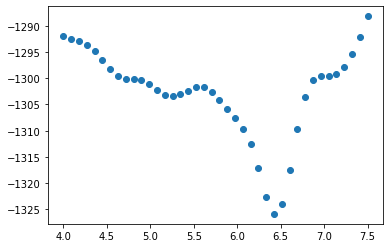

{n_features: 260, n_sparse: 2000, range: [6.3,6.9]},


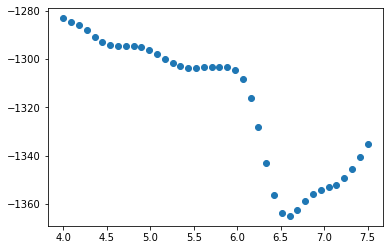

{n_features: 260, n_sparse: 5000, range: [6.1,6.7]},


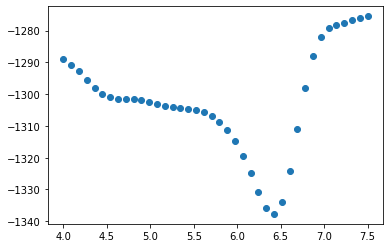

{n_features: 650, n_sparse: 200, range: [5.5,6.1]},


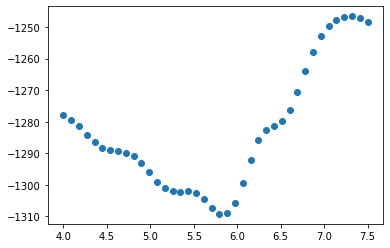

{n_features: 65, n_sparse: 100, range: [4.8,5.4]},


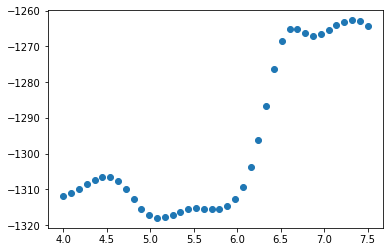

{n_features: 909, n_sparse: 1000, range: [5.7,6.3]},


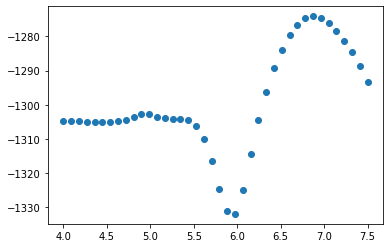

{n_features: 13, n_sparse: 1000, range: [7.2,7.8]},


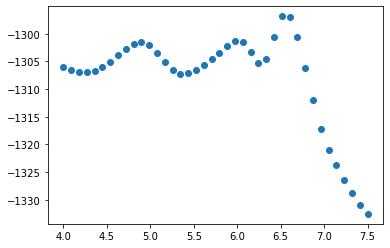

{n_features: 26, n_sparse: 7000, range: [6.7,7.3]},


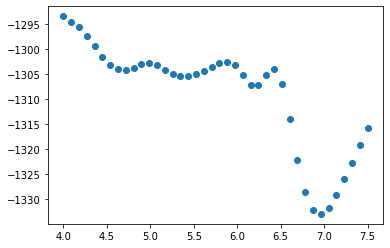

{n_features: 130, n_sparse: 500, range: [5.4,6.0]},


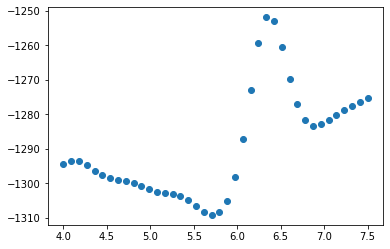

{n_features: 26, n_sparse: 1000, range: [6.2,6.8]},


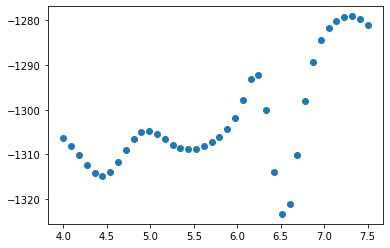

{n_features: 260, n_sparse: 7000, range: [6.2,6.8]},


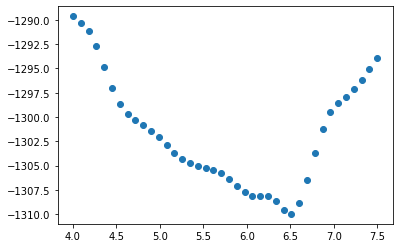

{n_features: 260, n_sparse: 500, range: [6.1,6.7]},


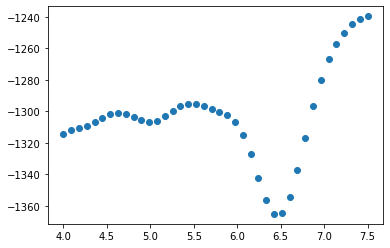

{n_features: 650, n_sparse: 500, range: [5.2,5.8]},


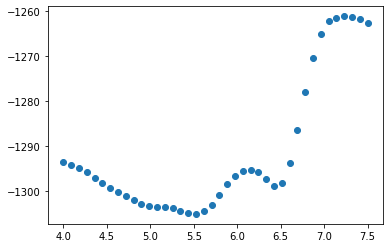

{n_features: 65, n_sparse: 1000, range: [6.1,6.7]},


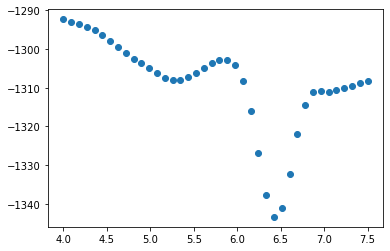

{n_features: 13, n_sparse: 500, range: [6.8,7.4]},


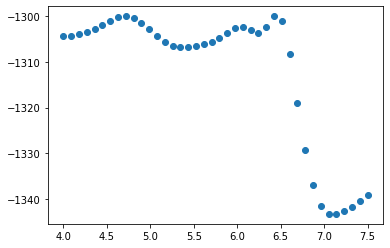

{n_features: 130, n_sparse: 7000, range: [5.6,6.2]},


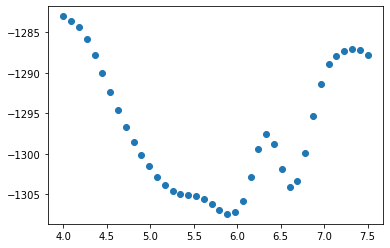

{n_features: 650, n_sparse: 100, range: [5.0,5.6]},


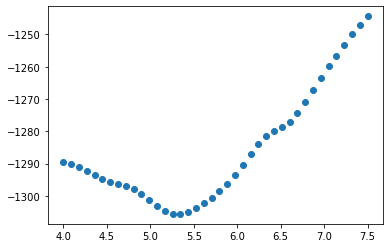

{n_features: 130, n_sparse: 200, range: [5.2,5.8]},


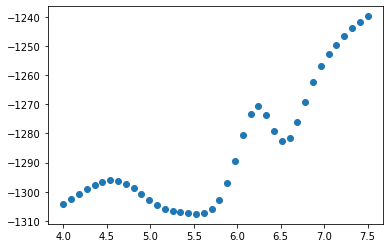

{n_features: 26, n_sparse: 200, range: [6.1,6.7]},


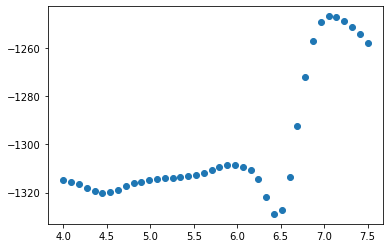

{n_features: 130, n_sparse: 5000, range: [6.1,6.7]},


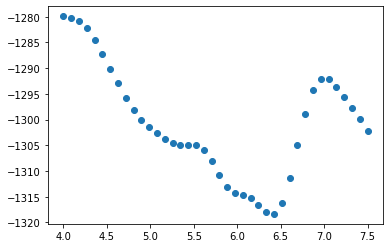

{n_features: 65, n_sparse: 7000, range: [6.1,6.7]},


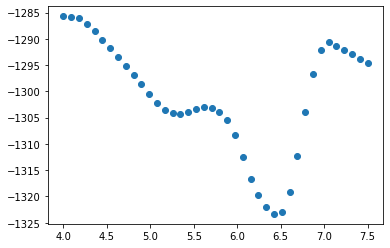

{n_features: 65, n_sparse: 200, range: [6.5,7.1]},


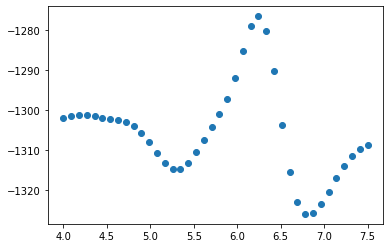

{n_features: 130, n_sparse: 2000, range: [6.0,6.6]},


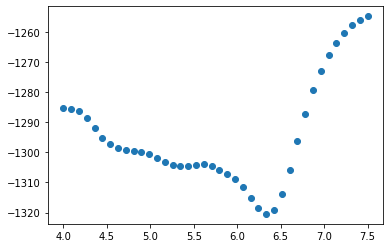

{n_features: 909, n_sparse: 100, range: [5.0,5.6]},


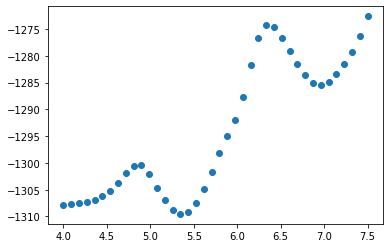

{n_features: 13, n_sparse: 7000, range: [6.1,6.7]},


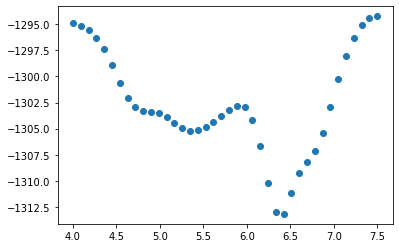

{n_features: 26, n_sparse: 5000, range: [6.7,7.3]},


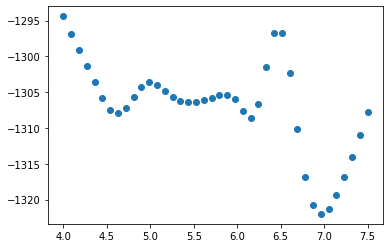

{n_features: 260, n_sparse: 1000, range: [6.2,6.8]},


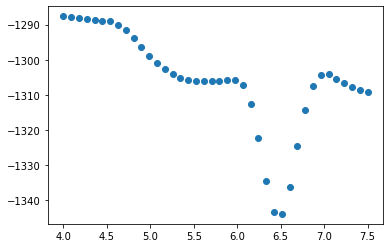

{n_features: 130, n_sparse: 1000, range: [6.3,6.9]},


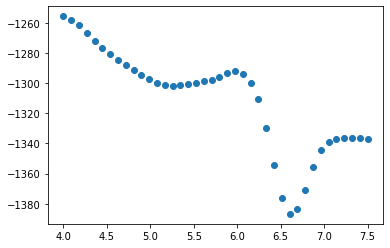

{n_features: 26, n_sparse: 500, range: [6.3,6.9]},


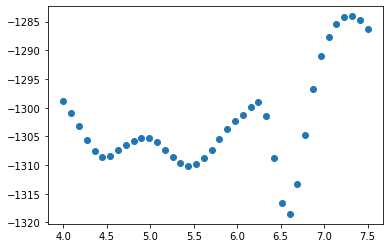

{n_features: 909, n_sparse: 500, range: [5.3,5.9]},


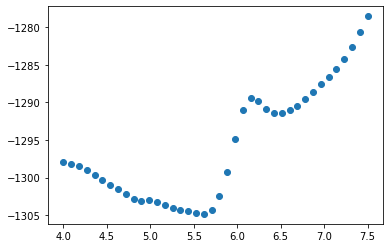

{n_features: 13, n_sparse: 9000, range: [6.5,7.1]},


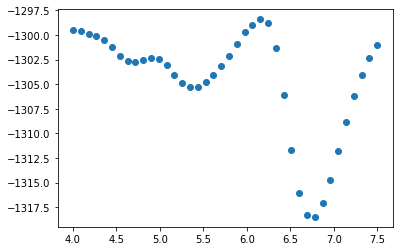

{n_features: 65, n_sparse: 2000, range: [6.1,6.7]},


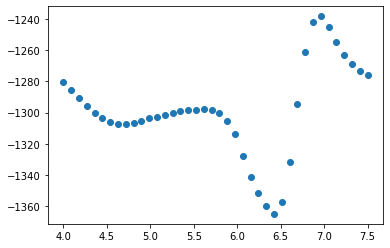

{n_features: 650, n_sparse: 7000, range: [5.5,6.1]},


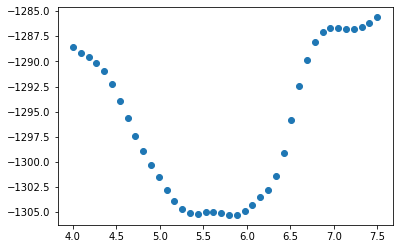

{n_features: 909, n_sparse: 9000, range: [5.1,5.7]},


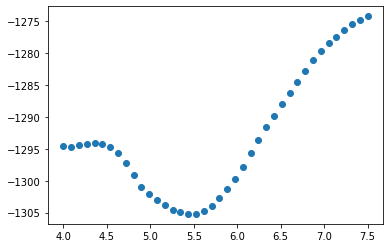

{n_features: 130, n_sparse: 9000, range: [6.3,6.9]},


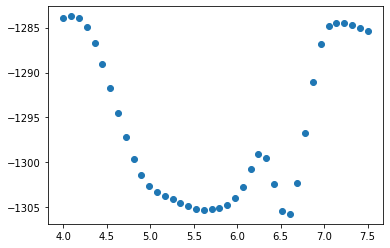

{n_features: 650, n_sparse: 1000, range: [6.1,6.7]},


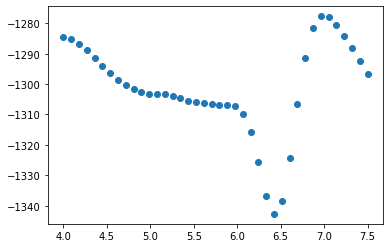

{n_features: 650, n_sparse: 9000, range: [6.2,6.8]},


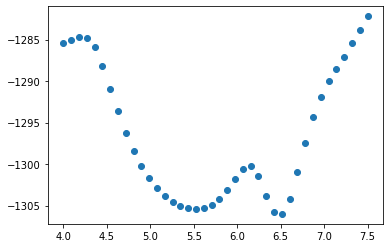

{n_features: 13, n_sparse: 200, range: [7.2,7.8]},


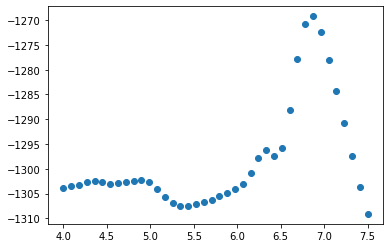

{n_features: 13, n_sparse: 100, range: [6.3,6.9]},


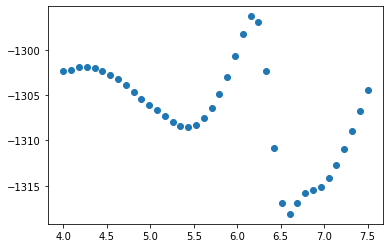

In [27]:
project = project = signac.get_project('./results/train_model/')
data = []
data_ = []
for job in tqdm(project.find_jobs()):
    aa = {}
    aa['n_features'] = job.sp.feature_subselection['Nselect']
    aa['n_sparse'] = job.sp.sparse_point_subselection['Nselect']['14']
    model = load_obj(job.fn('model.json'))
    soap = model.kernel._rep
    # calc = ASEMLCalculator(model, soap)

    latticeconstant = 5.431020511
    frames = []
    # atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    # atoms.calc = calc
    # cell = atoms.get_cell()
    volumes = []
    energies = []
    for lat in np.linspace(4,7.5, 40):
        atoms = bulk('Si', 'diamond', a=lat, cubic=True)
        volumes.append(atoms.get_volume())
        frames.append(atoms)
    managers = soap.transform(frames)
    energies = model.predict(managers)

    volumes = np.array(volumes).flatten()
    lats = np.power(volumes,1/3)
    energies = np.array(energies).flatten()
    # aa['lats'] = lats
    # aa['volumes'] = volumes
    # aa['energies'] = energies
    amin = np.argmin(energies)
    mlat = lats[amin]
    
    print('{'+'n_features: {}, n_sparse: {}, range: [{:.1f},{:.1f}]'.format(aa['n_features'],
                                                                    aa['n_sparse'],mlat-0.3,mlat+0.3)+'},')
    plt.scatter(lats,energies)
    plt.show()
    
    data_.append({'n_features': aa['n_features'], 'n_sparse': aa['n_sparse'], 
                  'lats':lats,'volumes':volumes,'energies':energies,'range':[mlat-0.3,mlat+0.3]})
#     eos = EquationOfState(volumes, energies)
#     try:
#         v0, e0, B = eos.fit()
#     except ValueError:
#         v0, e0, B = np.nan,np.nan, np.nan
#     # print(B / kJ * 1.0e24, 'GPa')
#     aa['B'] = B / kJ * 1.0e24
#     aa['B_unit'] = 'GPa'
#     aa['$V_0$'] = v0
#     aa['a'] = np.power(v0,1/3)
#     data.append(data)
    
# data = pd.DataFrame(data)

In [ ]:
ranges_0 = pd.DataFrame([
    {'n_features': 130, 'n_sparse': 100, 'range': [4.90934620442857, 5.50934620442857]}, 
    {'n_features': 26, 'n_sparse': 100, 'range': [6.948749824885713, 7.548749824885713]}, 
    {'n_features': 650, 'n_sparse': 2000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 909, 'n_sparse': 2000, 'range': [5.4,6.]}, 
    {'n_features': 909, 'n_sparse': 5000, 'range': [5.441364540199999, 6.041364540199998]}, 
    {'n_features': 260, 'n_sparse': 100, 'range': [5.086685649685713, 5.686685649685713]}, 
    {'n_features': 13, 'n_sparse': 2000, 'range': [5,5.6]}, 
    {'n_features': 909, 'n_sparse': 200, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 909, 'n_sparse': 7000, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 260, 'n_sparse': 200, 'range': [5,5.8]}, 
    {'n_features': 65, 'n_sparse': 500, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 26, 'n_sparse': 9000, 'range': [5.1,5.6]}, 
    {'n_features': 260, 'n_sparse': 9000, 'range': [5.1,5.9]}, 
    {'n_features': 65, 'n_sparse': 9000, 'range': [5., 6.041364540199998]}, 
    {'n_features': 650, 'n_sparse': 5000, 'range': [5.707373708085714, 6.307373708085714]}, 
    {'n_features': 13, 'n_sparse': 5000, 'range': [5.1, 5.8]}, 
    {'n_features': 26, 'n_sparse': 2000, 'range': [5.086685649685713, 5.686685649685713]}, 
    {'n_features': 65, 'n_sparse': 5000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 260, 'n_sparse': 2000, 'range': [6.239392043857141, 6.83939204385714]}, 
    {'n_features': 260, 'n_sparse': 5000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 200, 'range': [5.530034262828569, 6.130034262828569]}, 
    {'n_features': 65, 'n_sparse': 100, 'range': [3.135951751857142, 3.7359517518571415]}, 
    {'n_features': 909, 'n_sparse': 1000, 'range': [5.618703985457143, 6.218703985457142]}, 
    {'n_features': 13, 'n_sparse': 1000, 'range': [5.1,5.7]}, 
    {'n_features': 26, 'n_sparse': 7000, 'range': [5.1,5.7]}, 
    {'n_features': 130, 'n_sparse': 500, 'range': [5.441364540199999, 6.041364540199998]}, 
    {'n_features': 26, 'n_sparse': 1000, 'range': [5.1,5.8]}, 
    {'n_features': 260, 'n_sparse': 7000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 260, 'n_sparse': 500, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 500, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 65, 'n_sparse': 1000, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 500, 'range': [5.1,5.8]}, 
    {'n_features': 130, 'n_sparse': 7000, 'range': [5.618703985457143, 6.218703985457142]}, 
    {'n_features': 650, 'n_sparse': 100, 'range': [4.998015927057143, 5.598015927057142]}, 
    {'n_features': 130, 'n_sparse': 200, 'range': [3.0472820292285707, 3.6472820292285704]}, 
    {'n_features': 26, 'n_sparse': 200, 'range': [2.9586123066, 3.5586123065999997]}, 
    {'n_features': 130, 'n_sparse': 5000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 65, 'n_sparse': 7000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 65, 'n_sparse': 200, 'range': [5.1,5.8]}, 
    {'n_features': 130, 'n_sparse': 2000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 909, 'n_sparse': 100, 'range': [3.0472820292285707, 3.6472820292285704]}, 
    {'n_features': 13, 'n_sparse': 7000, 'range': [5.1,5.8]}, 
    {'n_features': 26, 'n_sparse': 5000, 'range': [5.1,5.8]}, 
    {'n_features': 260, 'n_sparse': 1000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 130, 'n_sparse': 1000, 'range': [5.,5.8]}, 
    {'n_features': 26, 'n_sparse': 500, 'range': [6.239392043857141, 6.83939204385714]}, 
    {'n_features': 909, 'n_sparse': 500, 'range': [5.264025094942857, 5.864025094942857]}, 
    {'n_features': 13, 'n_sparse': 9000, 'range': [5.1,5.8]},
    {'n_features': 65, 'n_sparse': 2000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 7000, 'range': [4.9, 6.130034262828569]},
    {'n_features': 909, 'n_sparse': 9000, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 130, 'n_sparse': 9000, 'range': [5.,6.]}, 
    {'n_features': 650, 'n_sparse': 1000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 9000, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 200, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 100, 'range': [5.1,5.8]}
])

n_features:130, n_sparse:100


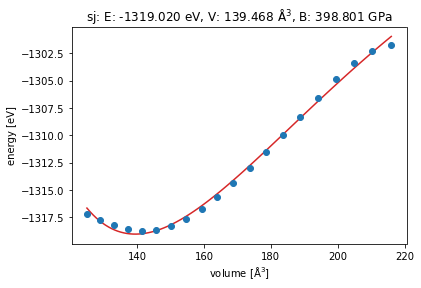

n_features:26, n_sparse:100


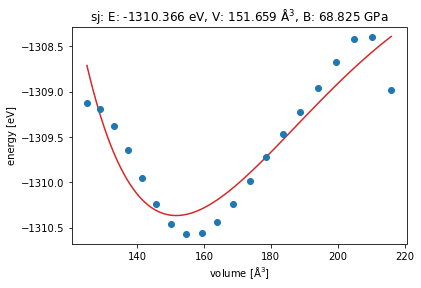

n_features:650, n_sparse:2000
n_features:909, n_sparse:2000


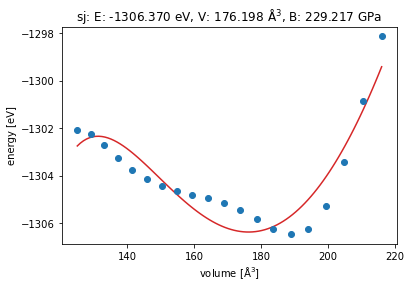

n_features:909, n_sparse:5000


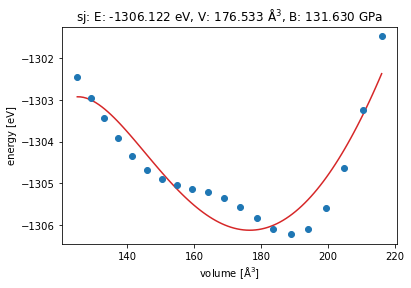

n_features:260, n_sparse:100


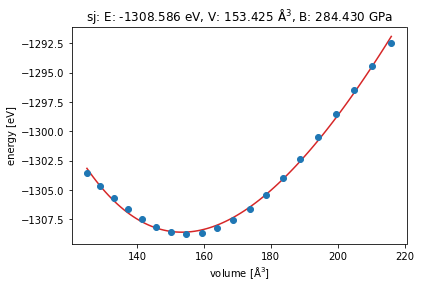

n_features:13, n_sparse:2000


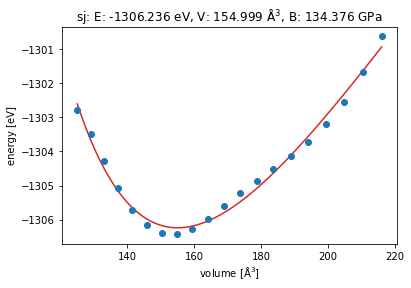

n_features:909, n_sparse:200


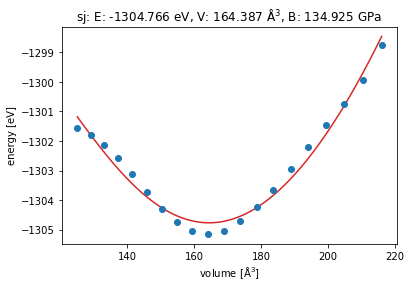

n_features:909, n_sparse:7000


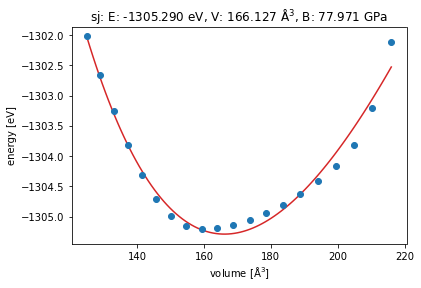

n_features:260, n_sparse:200


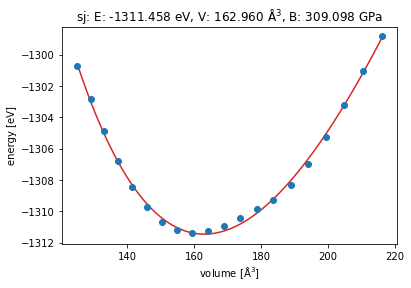

n_features:65, n_sparse:500
n_features:26, n_sparse:9000


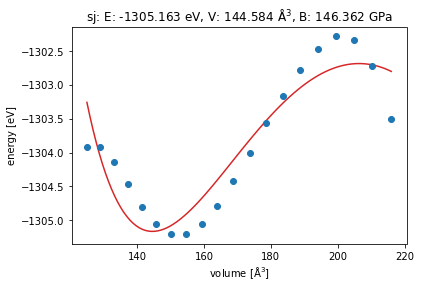

n_features:260, n_sparse:9000


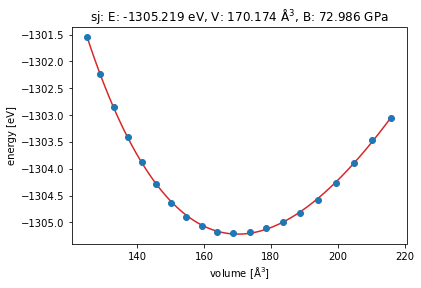

n_features:65, n_sparse:9000


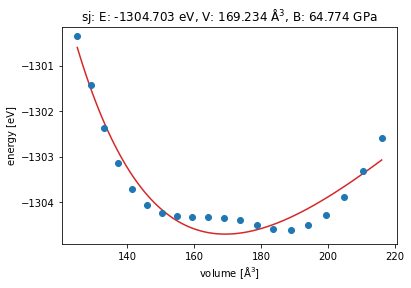

n_features:650, n_sparse:5000
n_features:13, n_sparse:5000


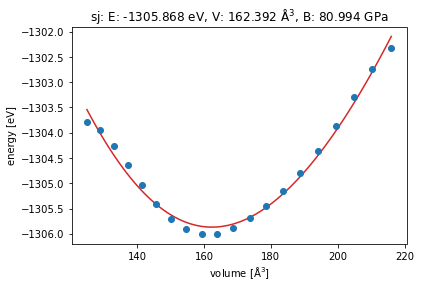

n_features:26, n_sparse:2000


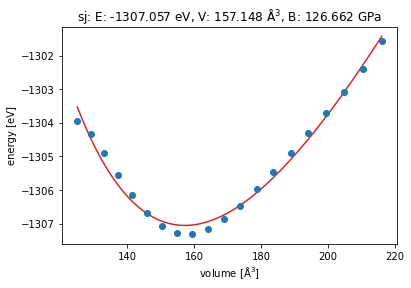

n_features:65, n_sparse:5000


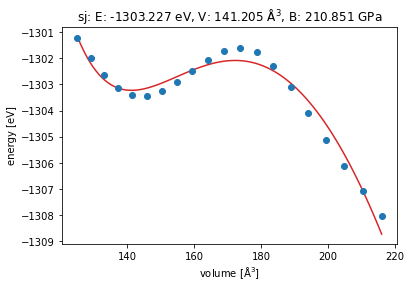

n_features:260, n_sparse:2000
n_features:260, n_sparse:5000
n_features:650, n_sparse:200


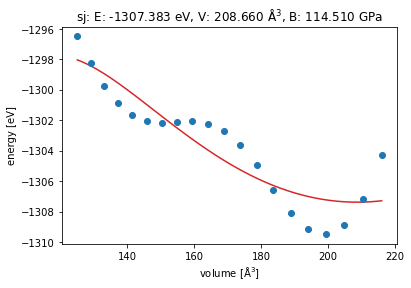

n_features:65, n_sparse:100
n_features:909, n_sparse:1000


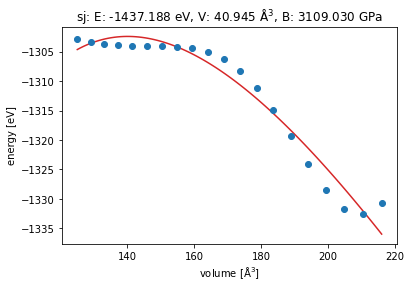

n_features:13, n_sparse:1000


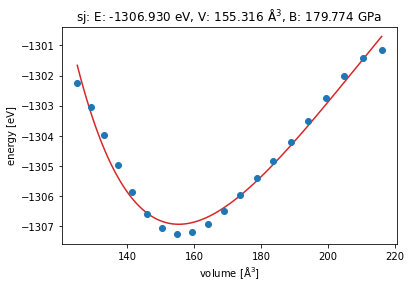

n_features:26, n_sparse:7000


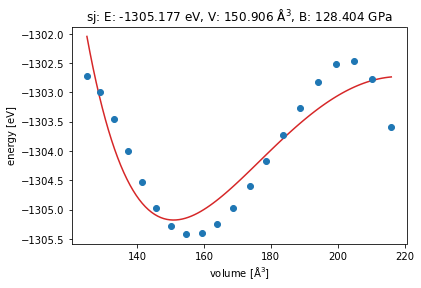

n_features:130, n_sparse:500


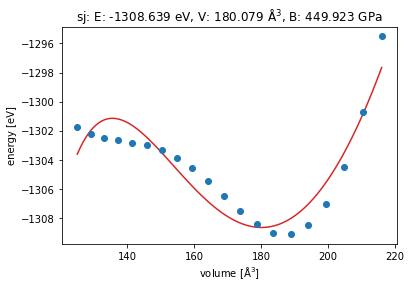

n_features:26, n_sparse:1000


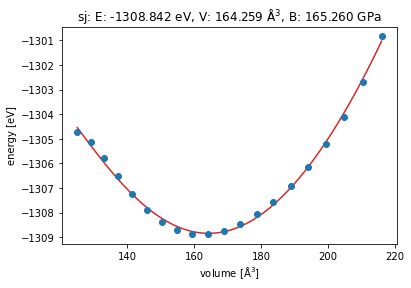

n_features:260, n_sparse:7000
n_features:260, n_sparse:500


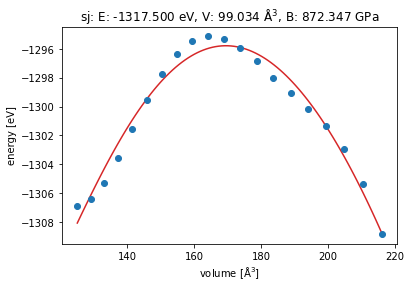

n_features:650, n_sparse:500


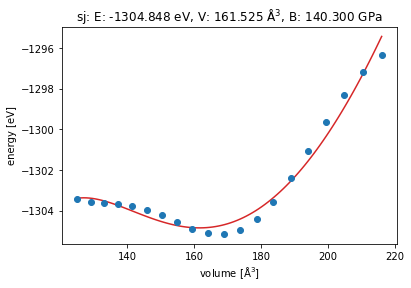

n_features:65, n_sparse:1000


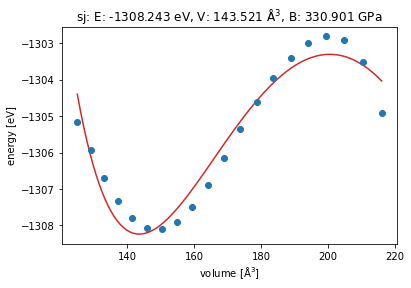

n_features:13, n_sparse:500


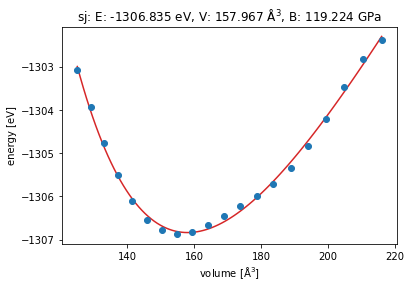

n_features:130, n_sparse:7000
n_features:650, n_sparse:100


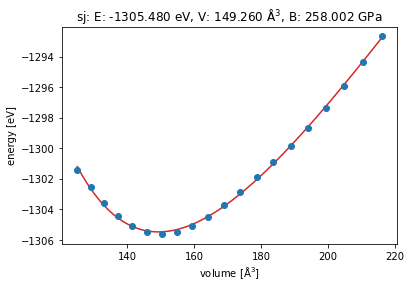

n_features:130, n_sparse:200


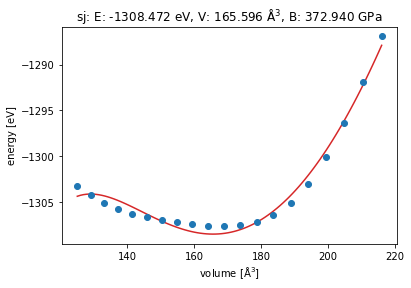

n_features:26, n_sparse:200


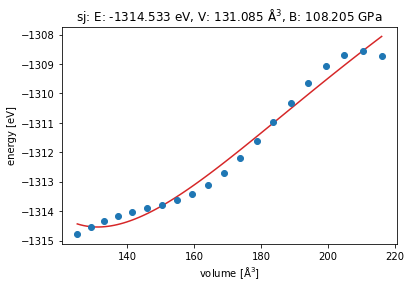

n_features:130, n_sparse:5000
n_features:65, n_sparse:7000


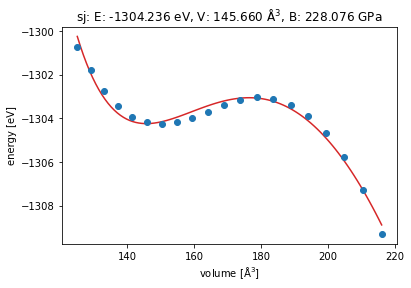

n_features:65, n_sparse:200


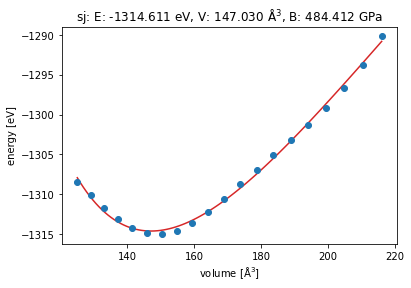

n_features:130, n_sparse:2000


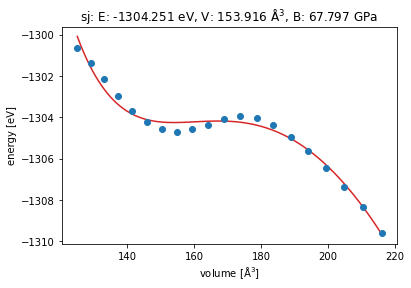

n_features:909, n_sparse:100


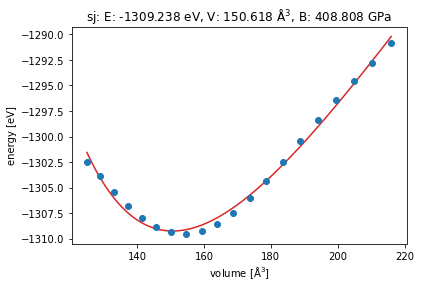

n_features:13, n_sparse:7000


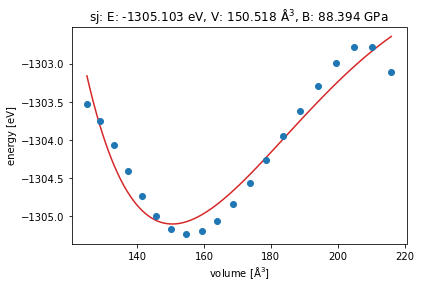

n_features:26, n_sparse:5000


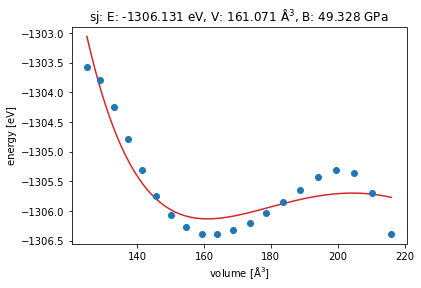

n_features:260, n_sparse:1000


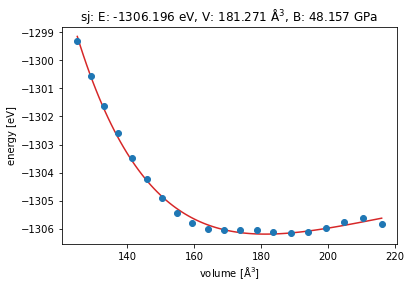

n_features:130, n_sparse:1000


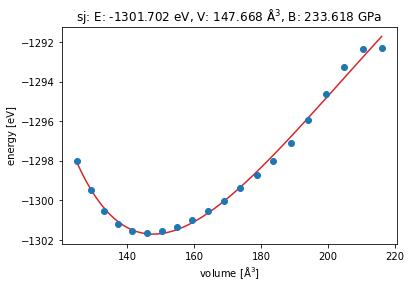

n_features:26, n_sparse:500


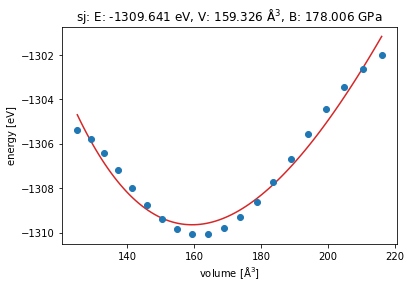

n_features:909, n_sparse:500


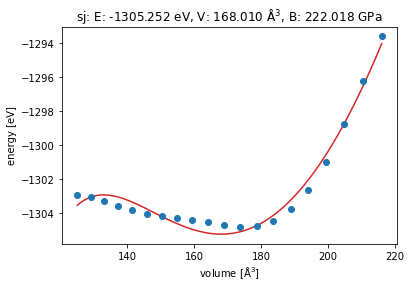

n_features:13, n_sparse:9000


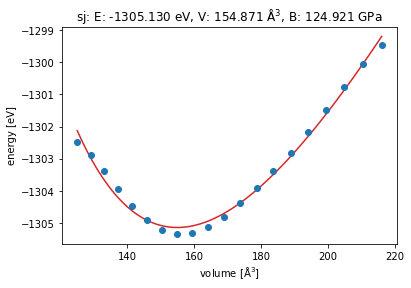

n_features:65, n_sparse:2000


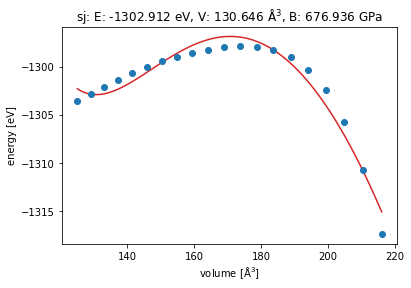

n_features:650, n_sparse:7000


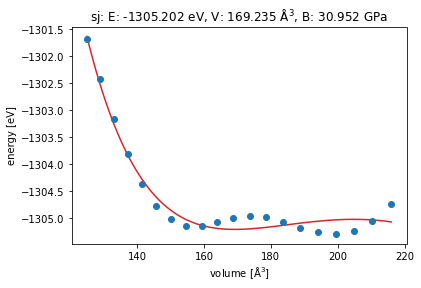

n_features:909, n_sparse:9000


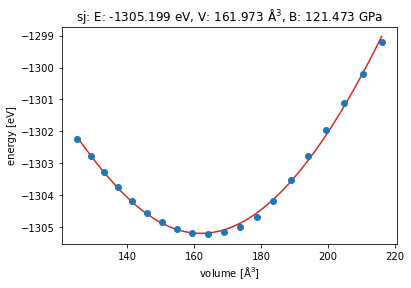

n_features:130, n_sparse:9000


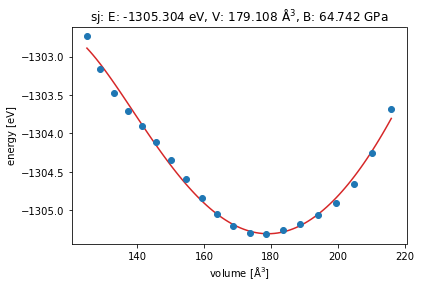

n_features:650, n_sparse:1000


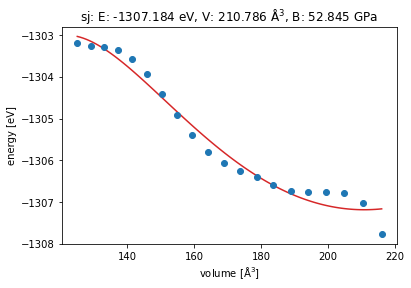

n_features:650, n_sparse:9000


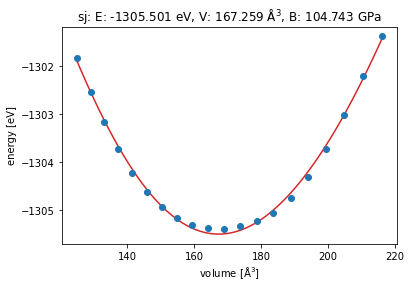

n_features:13, n_sparse:200


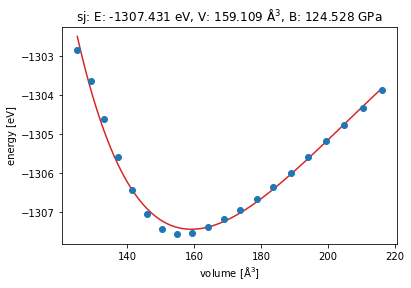

n_features:13, n_sparse:100


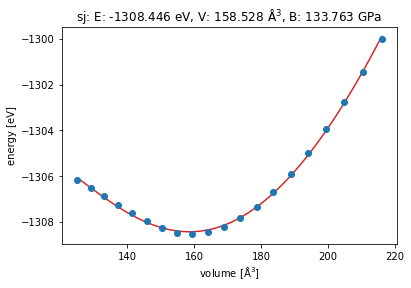

In [26]:
for dd in data_:
    lats = dd['lats']
    energies = dd['energies']
    print(', '.join(['{}:{}'.format(k,dd[k]) for k in ['n_features', 'n_sparse'] ]))
    eos = EquationOfState(dd['volumes'], energies)
    try:
        v0, e0, B = eos.fit()
        eos.plot()
        plt.show()
    except ValueError:
        v0, e0, B = np.nan,np.nan, np.nan
        

In [23]:
data

KeyboardInterrupt: 

In [51]:
job.sp.sparse_point_subselection['Nselect']['14']

100

In [48]:
data

n_features
0          130
1           26
2          650
3          909
4          909
5          260
6           13
7          909
8          909
9          260
10          65
11          26
12         260
13          65
14         650
15          13
16          26
17          65
18         260
19         260
20         650
21          65
22         909
23          13
24          26
25         130
26          26
27         260
28         260
29         650
30          65
31          13
32         130
33         650
34         130
35          26
36         130
37          65
38          65
39         130
40         909
41          13
42          26
43         260
44         130
45          26
46         909
47          13
48          65
49         650
50         909
51         130
52         650
53         650
54          13
55          13

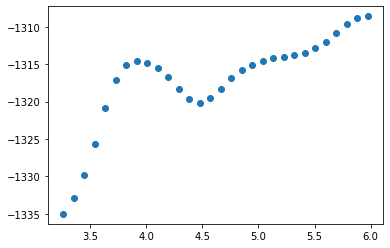

In [45]:
model = load_obj('./results/train_model/workspace/088053c41a8f3d263f4ad22a62e8895f/model.json')
soap = model.kernel._rep

calc = ASEMLCalculator(model, soap)

latticeconstant = 5.431020511
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.calc = calc
cell = atoms.get_cell()
volumes = []
energies = []
for x in np.linspace(0.6, 1.1, 30):
    atoms.set_cell(cell * x, scale_atoms=True)
    atoms.get_potential_energy()
    volumes.append(atoms.get_volume())
    energies.append(atoms.get_potential_energy())

volumes = np.array(volumes).flatten()
lats = np.power(volumes,1/3)
energies = np.array(energies).flatten()
plt.scatter(lats, energies)

391.885265586312 GPa


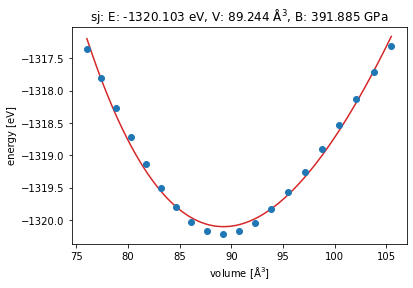

In [41]:
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState
configs = read('Ag.traj',':')  
# Extract volumes and energies:
volumes = np.array([ag.get_volume() for ag in configs]).flatten()
energies = np.array([ag.get_potential_energy() for ag in configs]).flatten()
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')

## try out the generated models no signac

In [20]:
B_ref = 88.6 # GPa
V_ref = 20.34*8 # a**3
alat_ref = np.power(V_ref, 1/3) # A
V_ref,alat_ref

(162.72, 5.459425934895006)

In [22]:
scores = pd.read_json(PATH+'cv-score-all.json')

In [23]:
best_scores = scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).drop(columns=['tag']).reset_index()
best_scores.head(40)

tag  n_feature  n_sparse  lambda_e  lambda_f  index     MAE_e    RMSE_e  \
0     0         14       100     0.001      0.50    524  0.017611  0.035748   
1     1         35       100     0.001      0.50    124  0.014222  0.029016   
2     2         71       100     0.001      0.50   2044  0.011545  0.022790   
3     3        143       100     0.001      0.50   2924  0.013472  0.026938   
4     4        286       100     0.001      0.50   4204  0.014787  0.029343   
5     5        357       100     0.001      0.50   4684  0.014640  0.028769   
6     6        500       100     0.001      0.50     44  0.014596  0.028628   
7     7        715       100     0.001      0.50    204  0.014481  0.028466   
8     8         14       200     0.001      0.05   3486  0.015673  0.031129   
9     9         35       200     0.005      0.50   2759  0.008341  0.017900   
10   10         71       200     0.005      0.50   2279  0.006588  0.014595   
11   11        143       200     0.001      0.10    285  0.007155  0.014748   
12   12        286       200     0.005      0.50    359  0.008024  0.016613   
13   13        357       200     0.001      0.10   2365  0.008096  0.016699   
14   14        500       200     0.005      0.50   4839  0.008119  0.016769   
15   15        715       200     0.005      0.50   3239  0.008060  0.016654   
16   16         14       500     0.005      0.50   4439  0.014897  0.030553   
17   17         35       500     0.001      0.10   3405  0.007110  0.015715   
18   18         71       500     0.005      0.10    600  0.005370  0.012223   
19   19        143       500     0.005      0.50   3079  0.004028  0.009122   
20   20        286       500     0.001      0.10   2845  0.004656  0.010547   
21   21        357       500     0.001      0.10   3965  0.004678  0.010781   
22   22        500       500     0.001      0.10   4525  0.004654  0.010717   
23   23        715       500     0.001      0.10   3645  0.004629  0.010660   
24   24         14      1000     0.005      0.50    519  0.014827  0.030285   
25   25         35      1000     0.001      0.10    445  0.006936  0.015205   
26   26         71      1000     0.001      0.10    605  0.003664  0.008958   
27   27        143      1000     0.001      0.05   3726  0.003106  0.006532   
28   28        286      1000     0.005      0.50   2199  0.002972  0.006950   
29   29        357      1000     0.005      0.50   2119  0.002974  0.007024   
30   30        500      1000     0.001      0.10   4285  0.002961  0.007051   
31   31        715      1000     0.005      0.50    679  0.002952  0.007052   
32   32         14      2000     0.005      0.50    759  0.014839  0.030153   
33   33         35      2000     0.010      0.50    915  0.006905  0.014711   
34   34         71      2000     0.001      0.10    845  0.003517  0.008465   
35   35        143      2000     0.001      0.10   4125  0.002659  0.005991   
36   36        286      2000     0.001      0.10   2605  0.002540  0.005745   
37   37        357      2000     0.005      0.50   4599  0.002464  0.005547   
38   38        500      2000     0.005      0.50   4759  0.002429  0.005395   
39   39        715      2000     0.005      0.50   3319  0.002488  0.005593   

       SUP_e      R2_e    CORR_e     MAE_f    RMSE_f      SUP_f      R2_f  \
0   0.377615  0.996737  0.993973  0.368807  0.576853  12.938144  0.476331   
1   0.286464  0.997881  0.994831  0.328881  0.514368   8.825423  0.583154   
2   0.198154  0.998681  0.996659  0.227495  0.354094   9.962933  0.802656   
3   0.236310  0.998180  0.995694  0.270120  0.411834  10.311562  0.733713   
4   0.256870  0.997839  0.995130  0.278312  0.420811  10.755059  0.721819   
5   0.251678  0.997921  0.995314  0.274784  0.415736  10.861751  0.728453   
6   0.251341  0.997942  0.995332  0.274407  0.415262  10.817912  0.729057   
7   0.253424  0.997966  0.995345  0.270332  0.410218  10.897589  0.735588   
8   0.315129  0.997525  0.994776  0.257520  0.417061  12.231719  0.7272

In [24]:
lambdas=[0.005,0.5]
zeta, n_feature, n_sparse = 4, 715, 1000
fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
model = load_obj(fn)

In [25]:
frames = []
volumes = []
energies = []
for lat in np.linspace(4.5,6.5, 40):
    atoms = bulk('Si', 'diamond', a=lat, cubic=True)
    volumes.append(atoms.get_volume())
    frames.append(atoms)
managers = model.kernel._rep.transform(frames)

In [26]:
KNM = model.kernel(managers, model.X_train, (True,False))
f_ref = np.dot(KNM, model.weights).reshape((-1, 3))
f_test = -model.predict(managers, compute_gradients=True)
np.allclose(f_ref,f_test)

True

In [40]:
%%timeit
KNM = model.kernel(managers, model.X_train, (True,False))
f_ref = np.dot(KNM, model.weights).reshape((-1, 3))

1.9 s ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
f_test = -model.predict(managers, compute_gradients=True)

200 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


{n_features: 14, n_sparse: 100, range: [5.5,6.1]},


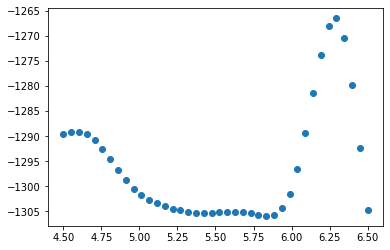

{n_features: 35, n_sparse: 100, range: [5.2,5.7]},


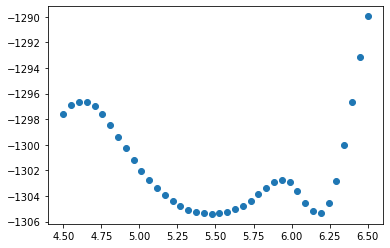

{n_features: 71, n_sparse: 100, range: [5.2,5.7]},


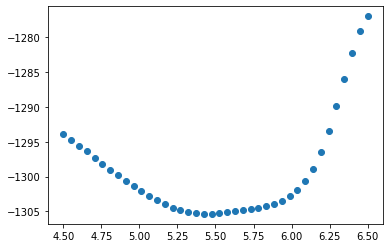

{n_features: 143, n_sparse: 100, range: [5.2,5.7]},


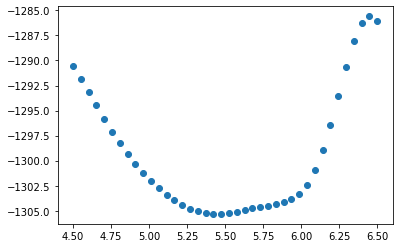

{n_features: 286, n_sparse: 100, range: [5.2,5.7]},


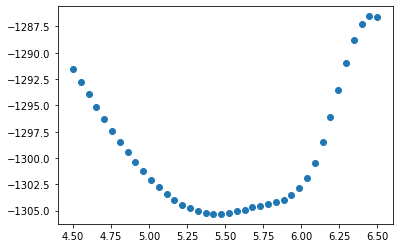

{n_features: 357, n_sparse: 100, range: [5.2,5.7]},


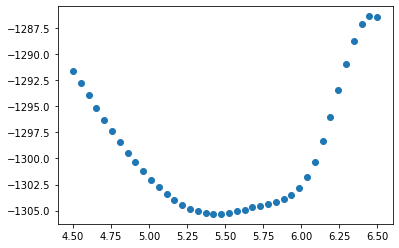

{n_features: 500, n_sparse: 100, range: [5.2,5.7]},


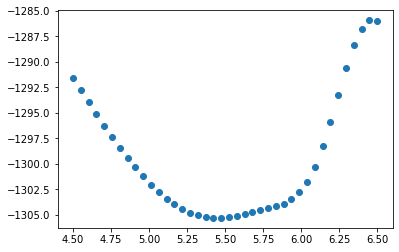

{n_features: 715, n_sparse: 100, range: [5.2,5.7]},


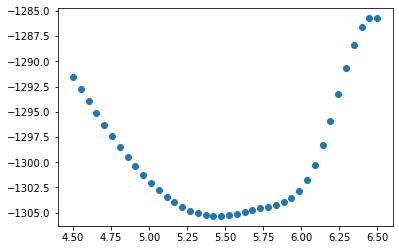

{n_features: 14, n_sparse: 200, range: [6.1,6.7]},


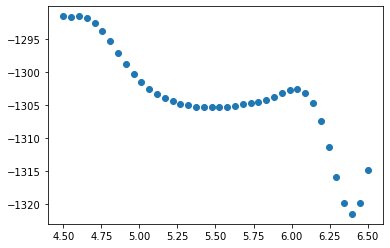

{n_features: 35, n_sparse: 200, range: [5.2,5.7]},


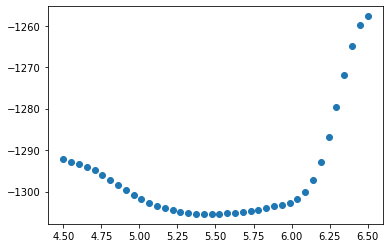

{n_features: 71, n_sparse: 200, range: [5.2,5.7]},


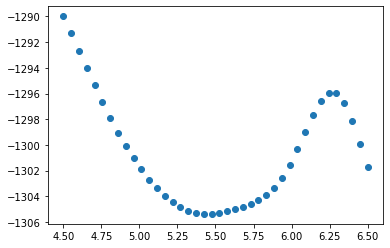

{n_features: 143, n_sparse: 200, range: [5.2,5.7]},


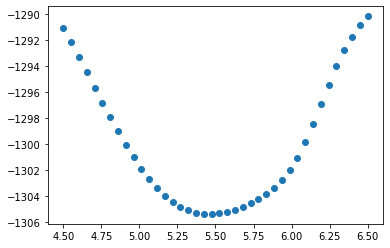

{n_features: 286, n_sparse: 200, range: [5.2,5.7]},


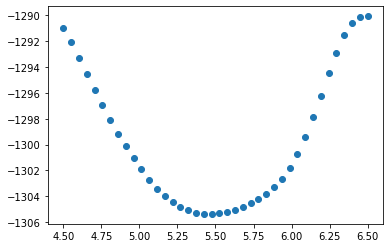

{n_features: 357, n_sparse: 200, range: [5.2,5.7]},


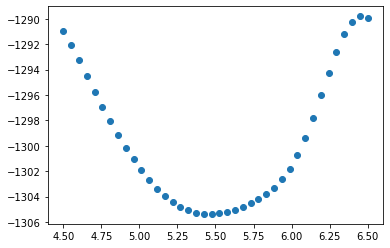

{n_features: 500, n_sparse: 200, range: [5.2,5.7]},


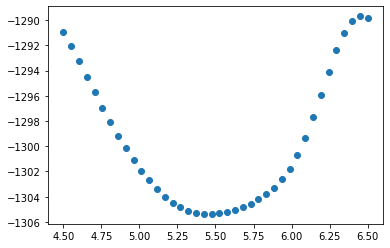

{n_features: 715, n_sparse: 200, range: [5.2,5.7]},


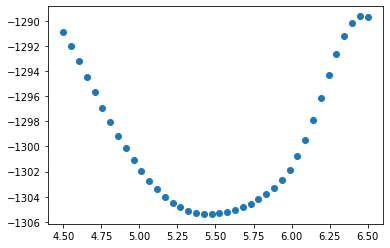

{n_features: 14, n_sparse: 500, range: [5.2,5.7]},


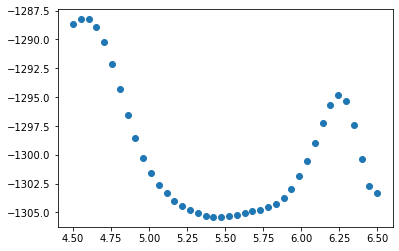

{n_features: 35, n_sparse: 500, range: [5.2,5.7]},


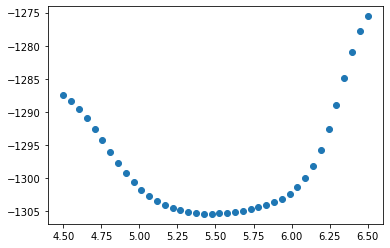

{n_features: 71, n_sparse: 500, range: [5.2,5.7]},


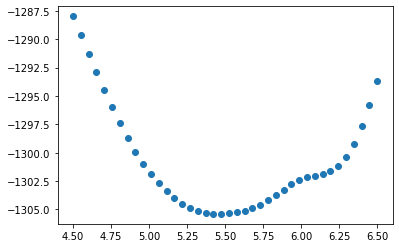

{n_features: 143, n_sparse: 500, range: [5.2,5.7]},


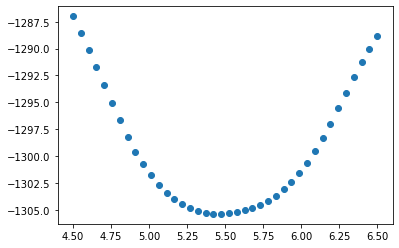

{n_features: 286, n_sparse: 500, range: [5.2,5.7]},


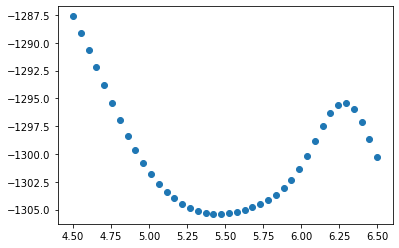

{n_features: 357, n_sparse: 500, range: [5.2,5.7]},


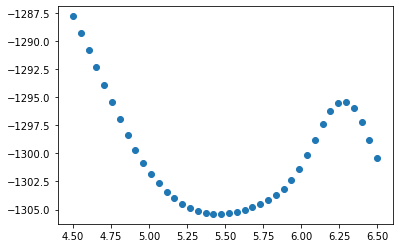

{n_features: 500, n_sparse: 500, range: [5.2,5.7]},


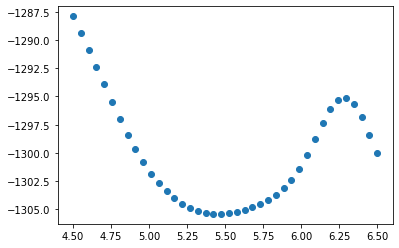

{n_features: 715, n_sparse: 500, range: [5.2,5.7]},


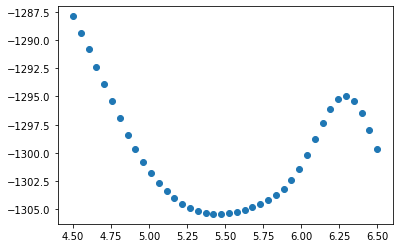

{n_features: 14, n_sparse: 1000, range: [5.2,5.7]},


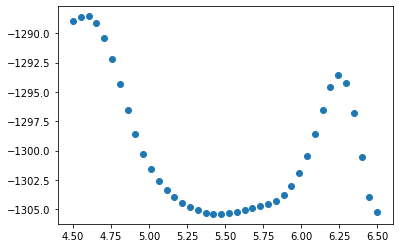

{n_features: 35, n_sparse: 1000, range: [5.2,5.7]},


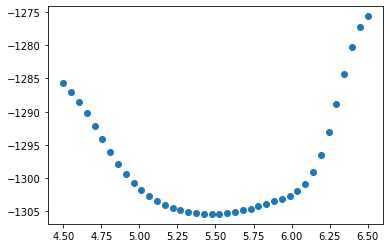

{n_features: 71, n_sparse: 1000, range: [5.2,5.7]},


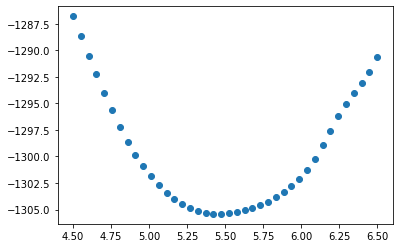

{n_features: 143, n_sparse: 1000, range: [5.2,5.7]},


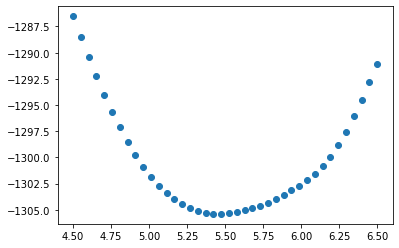

{n_features: 286, n_sparse: 1000, range: [5.2,5.7]},


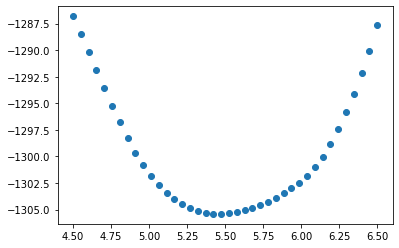

{n_features: 357, n_sparse: 1000, range: [5.2,5.7]},


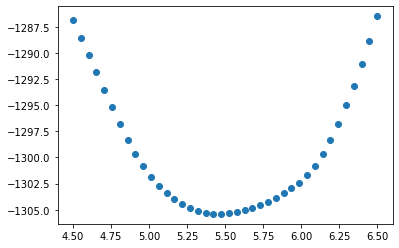

{n_features: 500, n_sparse: 1000, range: [5.2,5.7]},


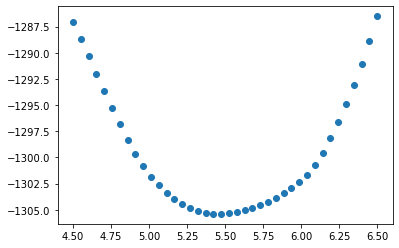

{n_features: 715, n_sparse: 1000, range: [5.2,5.7]},


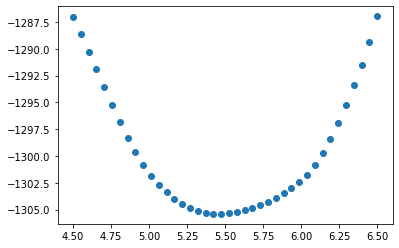

{n_features: 14, n_sparse: 2000, range: [5.2,5.7]},


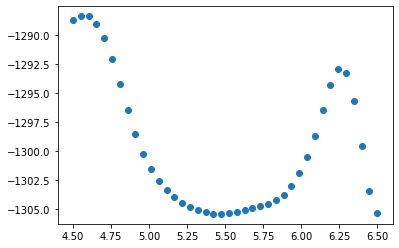

{n_features: 35, n_sparse: 2000, range: [5.2,5.7]},


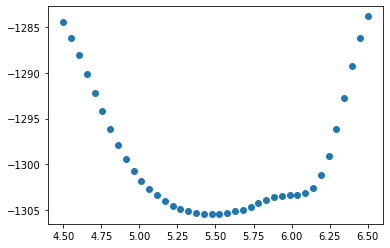

{n_features: 71, n_sparse: 2000, range: [5.2,5.7]},


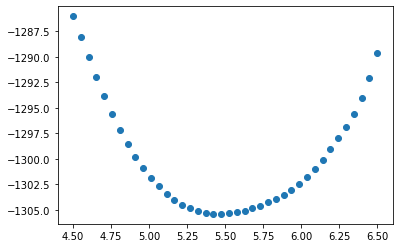

{n_features: 143, n_sparse: 2000, range: [5.2,5.7]},


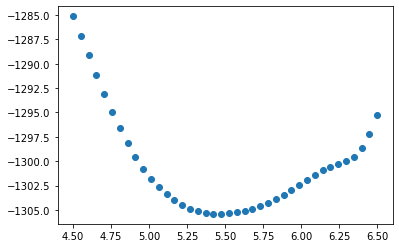

{n_features: 286, n_sparse: 2000, range: [5.2,5.7]},


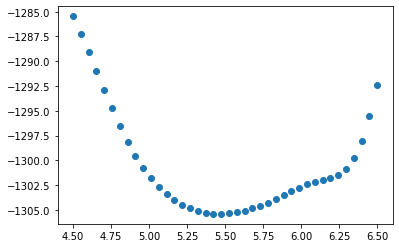

{n_features: 357, n_sparse: 2000, range: [5.2,5.7]},


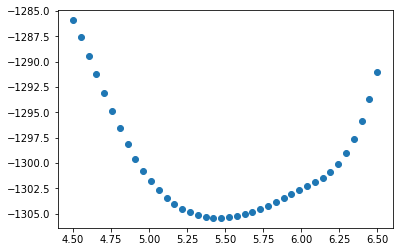

{n_features: 500, n_sparse: 2000, range: [5.2,5.7]},


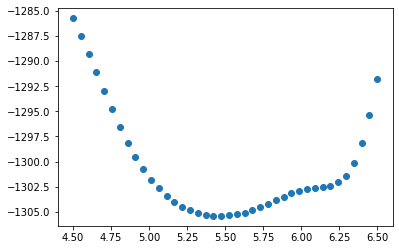

{n_features: 715, n_sparse: 2000, range: [5.2,5.7]},


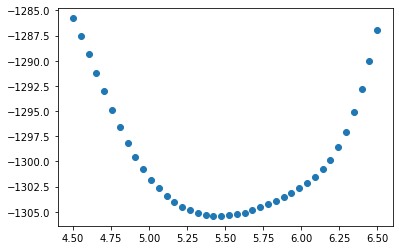

{n_features: 14, n_sparse: 5000, range: [6.2,6.8]},


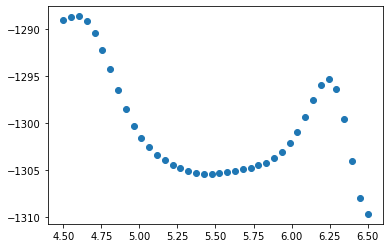

{n_features: 35, n_sparse: 5000, range: [5.2,5.7]},


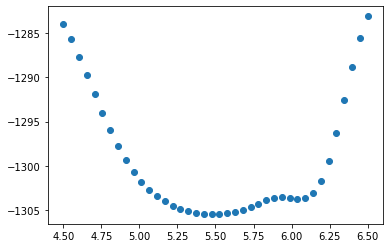

{n_features: 71, n_sparse: 5000, range: [5.2,5.7]},


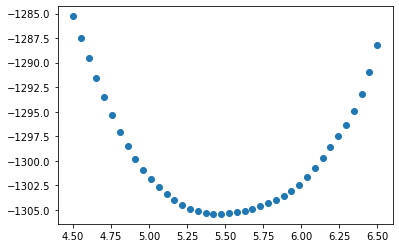

{n_features: 143, n_sparse: 5000, range: [5.2,5.7]},


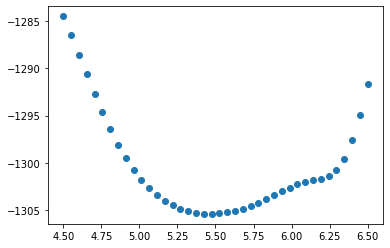

{n_features: 286, n_sparse: 5000, range: [5.2,5.7]},


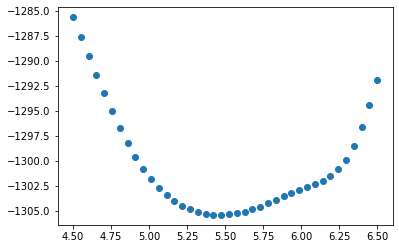

{n_features: 357, n_sparse: 5000, range: [5.2,5.7]},


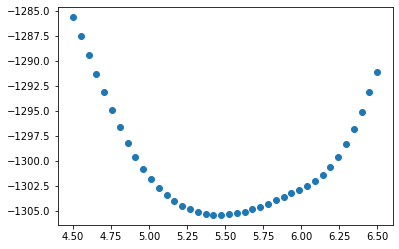

{n_features: 500, n_sparse: 5000, range: [5.2,5.7]},


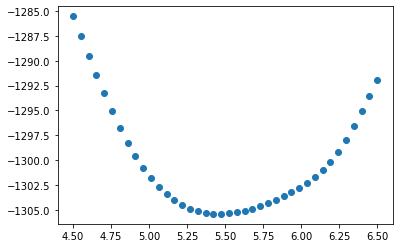

{n_features: 715, n_sparse: 5000, range: [5.2,5.7]},


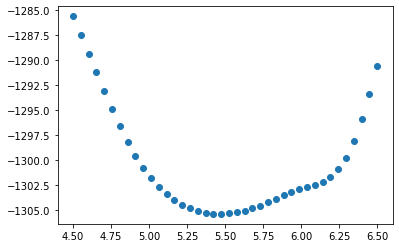

{n_features: 14, n_sparse: 7000, range: [6.2,6.8]},


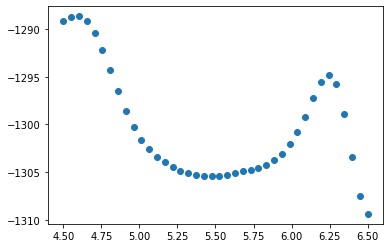

{n_features: 35, n_sparse: 7000, range: [5.2,5.7]},


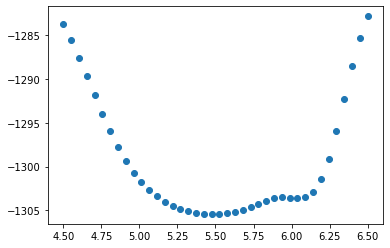

{n_features: 71, n_sparse: 7000, range: [5.2,5.7]},


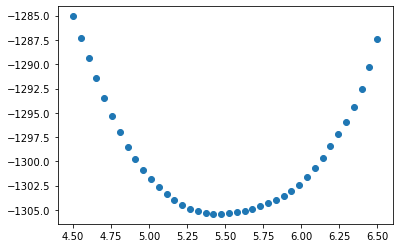

{n_features: 143, n_sparse: 7000, range: [5.2,5.7]},


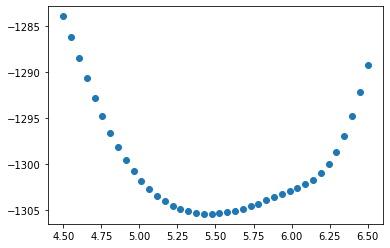

{n_features: 286, n_sparse: 7000, range: [5.2,5.7]},


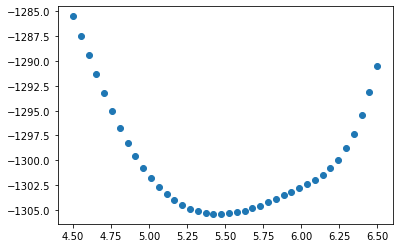

{n_features: 357, n_sparse: 7000, range: [5.2,5.7]},


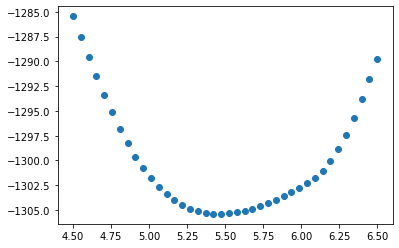

{n_features: 500, n_sparse: 7000, range: [5.2,5.7]},


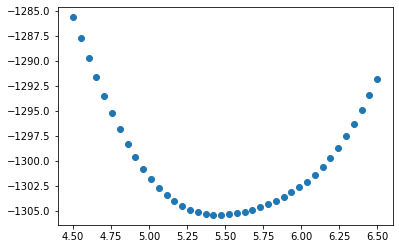

{n_features: 715, n_sparse: 7000, range: [5.2,5.7]},


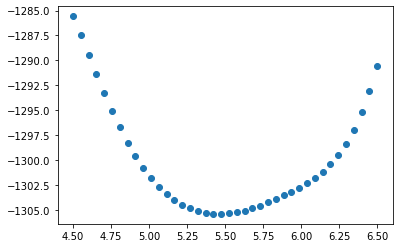

{n_features: 14, n_sparse: 9000, range: [6.2,6.8]},


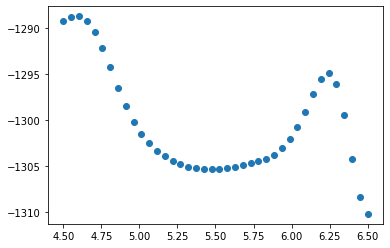

{n_features: 35, n_sparse: 9000, range: [5.2,5.7]},


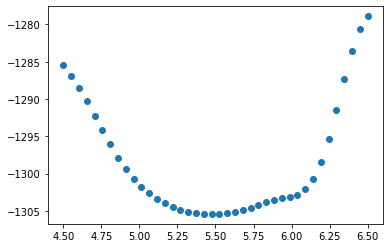

{n_features: 71, n_sparse: 9000, range: [5.2,5.7]},


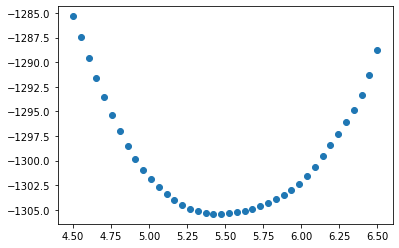

{n_features: 143, n_sparse: 9000, range: [5.2,5.7]},


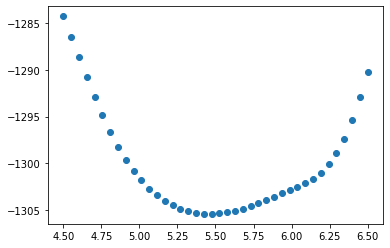

{n_features: 286, n_sparse: 9000, range: [5.2,5.7]},


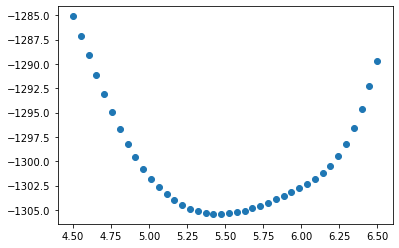

{n_features: 357, n_sparse: 9000, range: [5.2,5.7]},


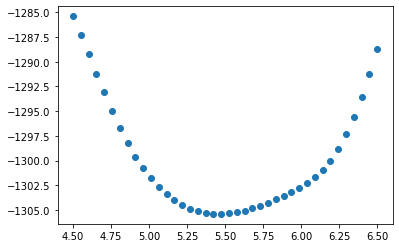

{n_features: 500, n_sparse: 9000, range: [5.2,5.7]},


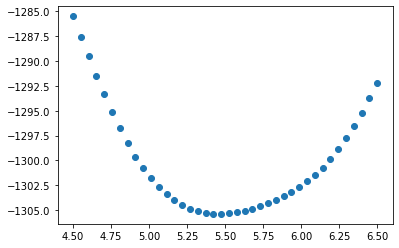

{n_features: 715, n_sparse: 9000, range: [5.2,5.7]},


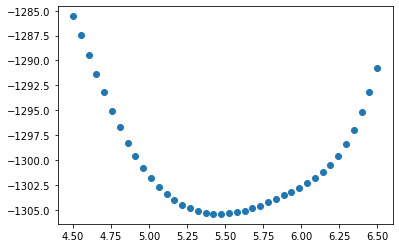

In [166]:
data = []
data_ = []
# lambdas=[5e-3, 5e-2]
zeta = 4
for n_sparse, n_feature  in tqdm(list(product(n_sparses,n_features))):
    aa = {}
    aa['n_features'] = n_feature
    aa['n_sparse'] = n_sparse
    dd = best_scores.query("n_feature=={} and n_sparse=={}".format(n_feature,n_sparse))
    if dd.size > 0:
        lambdas=[dd['lambda_e'].values[0], dd['lambda_f'].values[0]]
        fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
        model = load_obj(fn)
    else:
        continue
        lambdas=[1e-2, 1e-1]
        fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(
                                        zeta, n_feature, n_sparse,lambda_e , lambda_f)
        X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
        KNM = np.load(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), mmap_mode='r')
        hypers = X_pseudo.representation._get_init_params()
        hypers['compute_gradients'] = True
        soap = SphericalInvariants(**hypers)
        kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

        model = train_gap_model_0(kernel, frames, KNM, X_pseudo, y_train, self_contributions, grad_train=-f_train, 
                        lambdas=[lambda_e , lambda_f], jitter=1e-8)
        dump_obj(fn, model)
    
    soap = model.kernel._rep

    latticeconstant = alat_ref
    frames = []
    volumes = []
    energies = []
    for lat in np.linspace(4.5,6.5, 40):
        atoms = bulk('Si', 'diamond', a=lat, cubic=True)
        volumes.append(atoms.get_volume())
        frames.append(atoms)
    managers = soap.transform(frames)
    energies = model.predict(managers)

    volumes = np.array(volumes).flatten()
    lats = np.power(volumes,1/3)
    energies = np.array(energies).flatten()
    amin = np.argmin(energies)
    mlat = lats[amin]

    print('{'+'n_features: {}, n_sparse: {}, range: [{:.1f},{:.1f}]'.format(aa['n_features'],
                                                                    aa['n_sparse'],mlat-mlat*0.05,mlat+mlat*0.05)+'},')
    plt.scatter(lats,energies)
    plt.show()

    data_.append({'n_features': aa['n_features'], 'n_sparse': aa['n_sparse'], 
                  'lats':lats,'volumes':volumes,'energies':energies,'range':[mlat-mlat*0.05,mlat+mlat*0.05]})
    


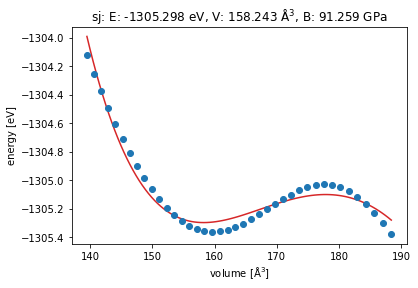

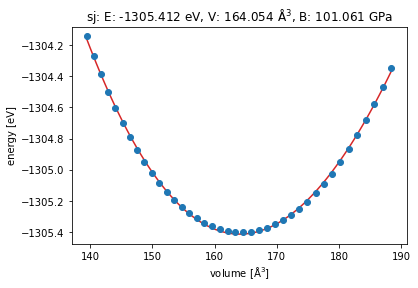

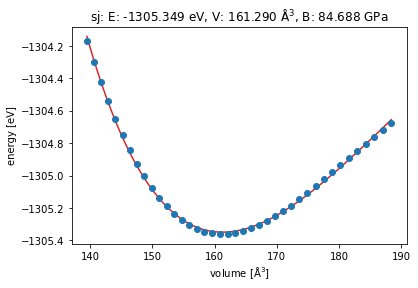

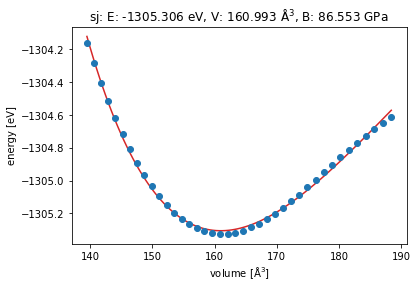

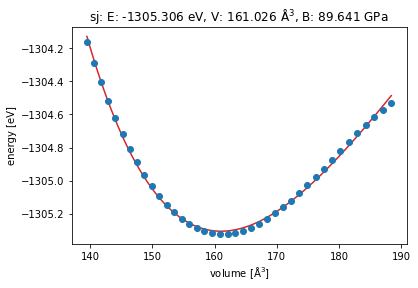

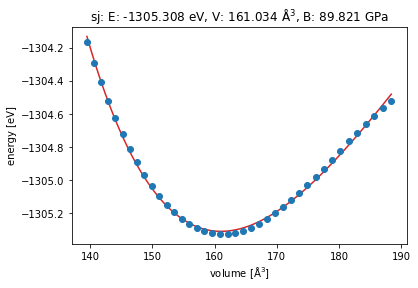

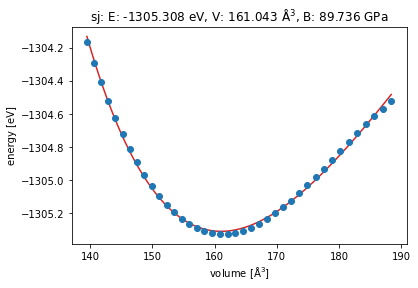

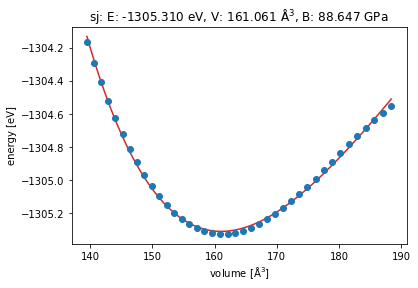

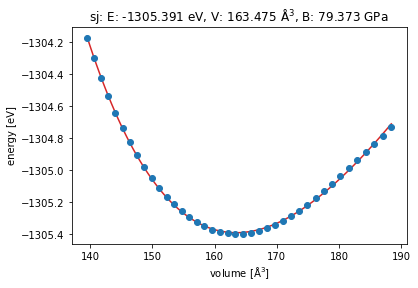

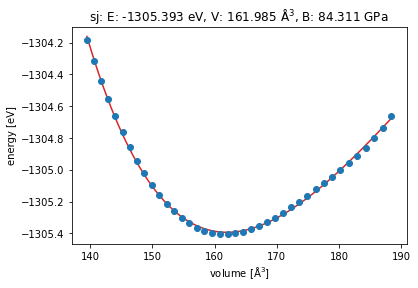

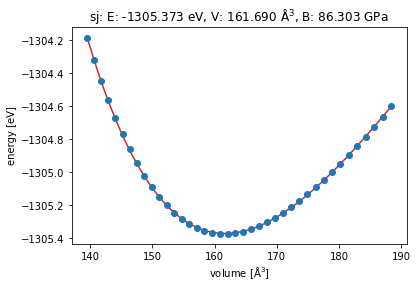

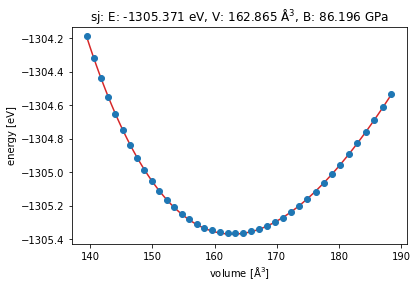

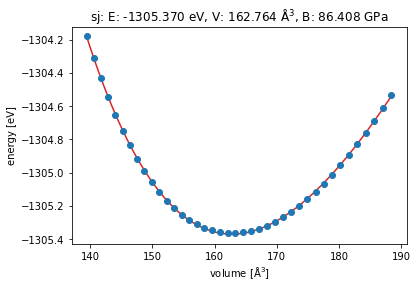

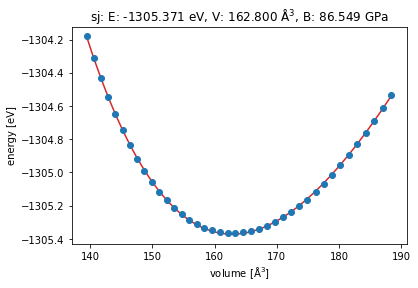

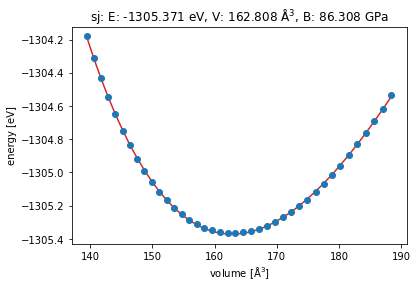

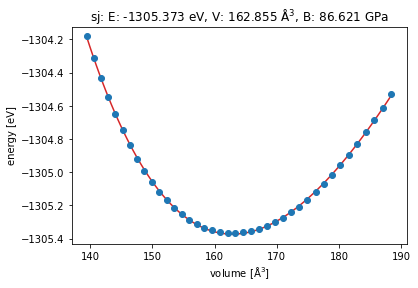

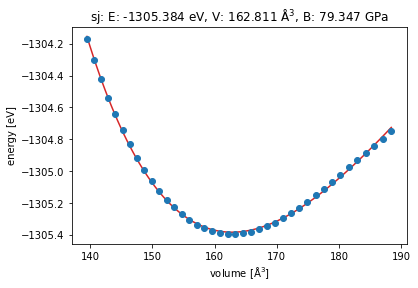

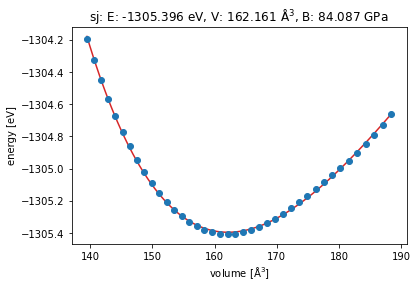

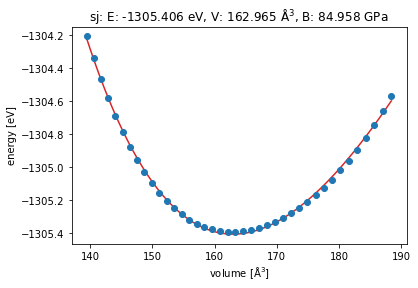

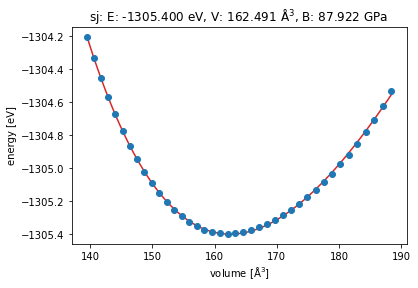

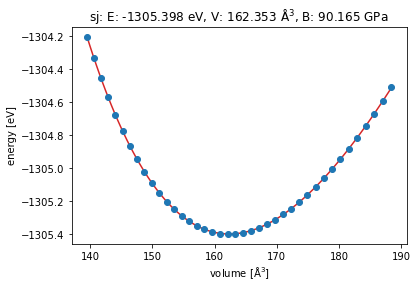

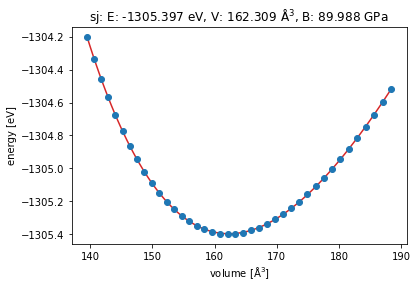

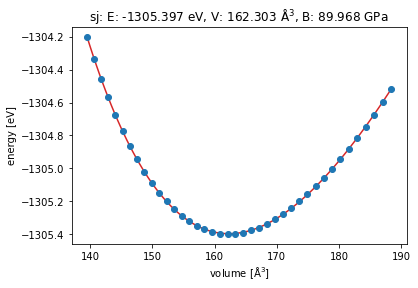

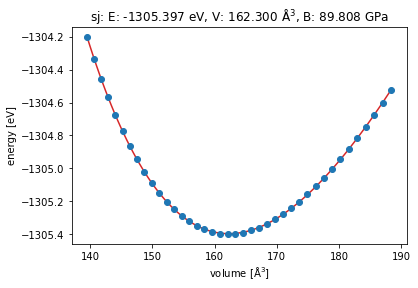

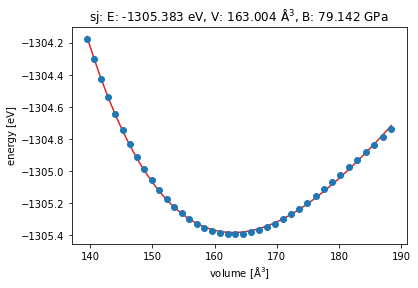

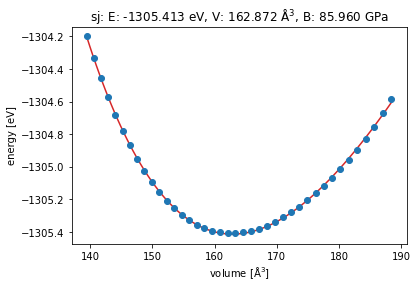

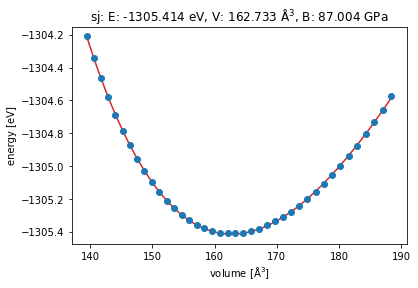

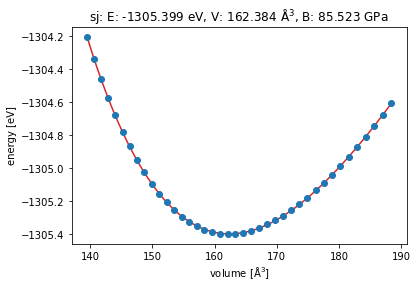

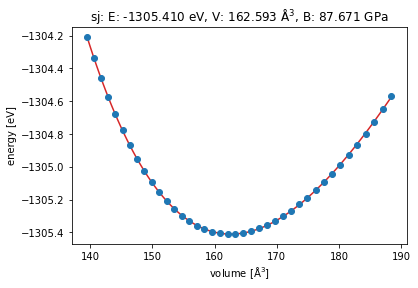

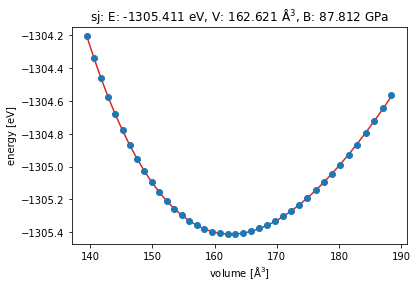

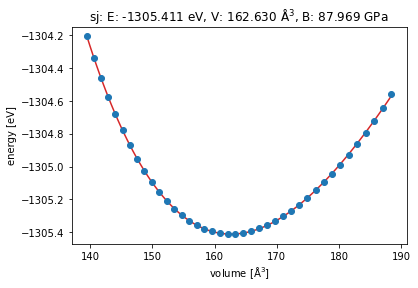

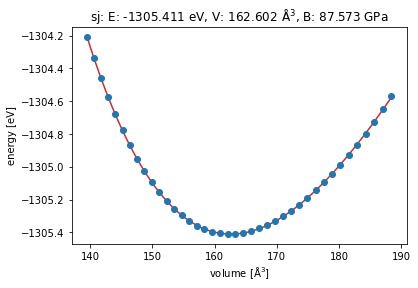

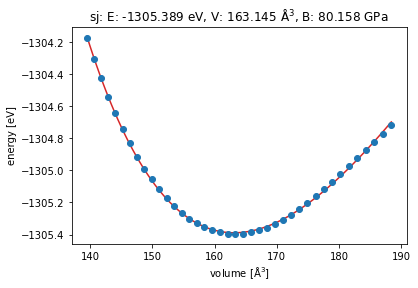

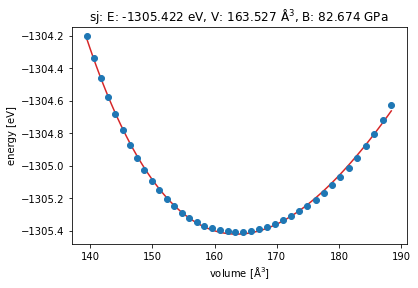

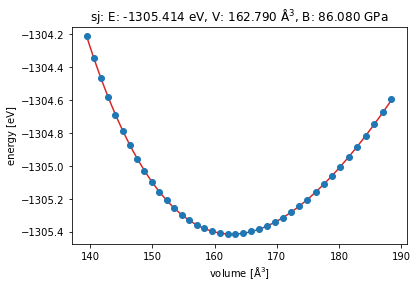

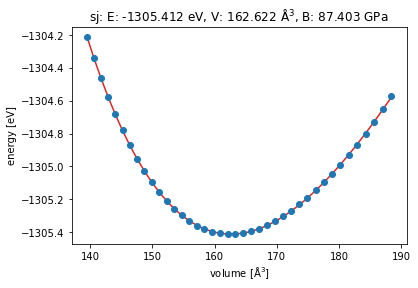

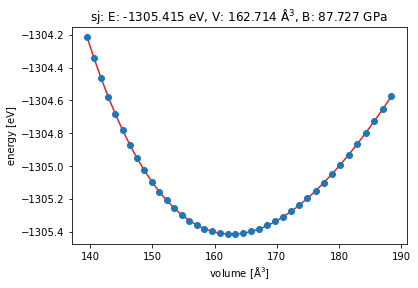

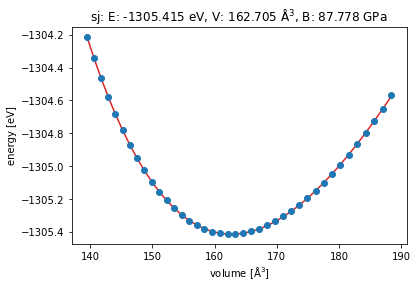

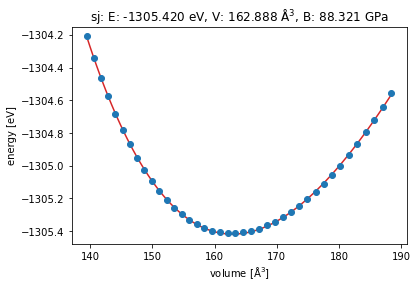

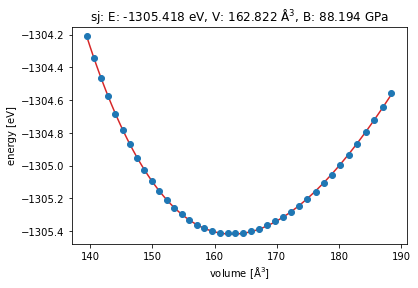

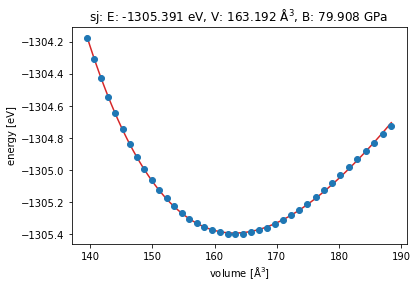

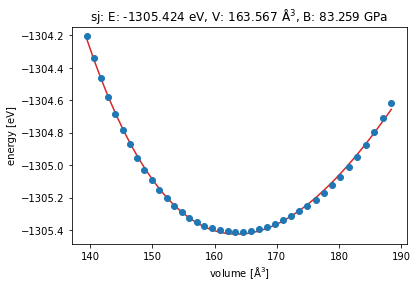

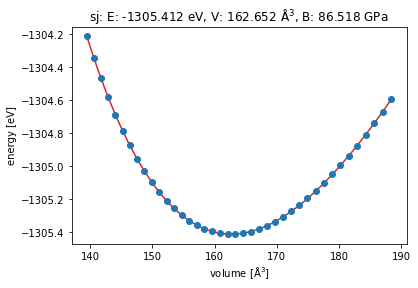

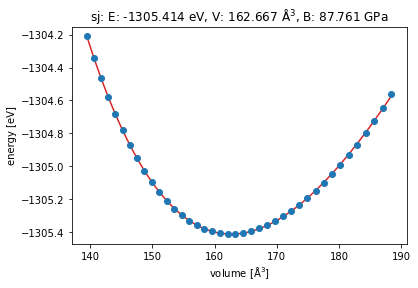

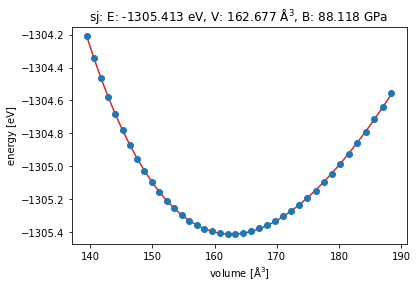

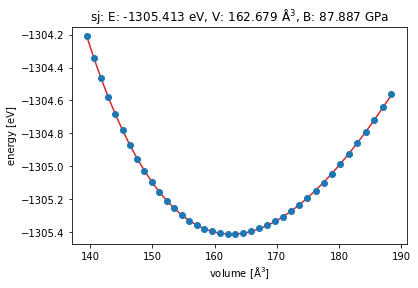

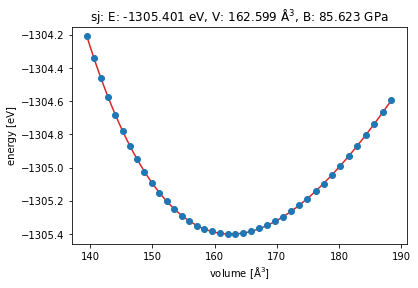

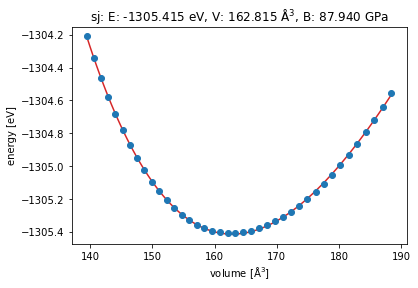

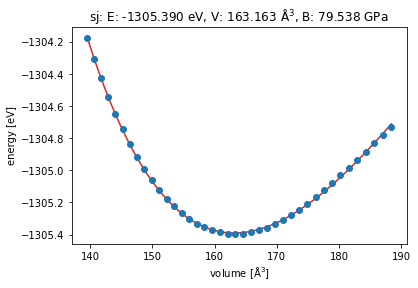

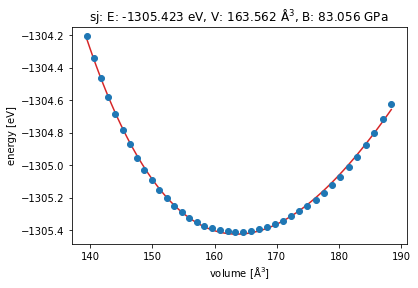

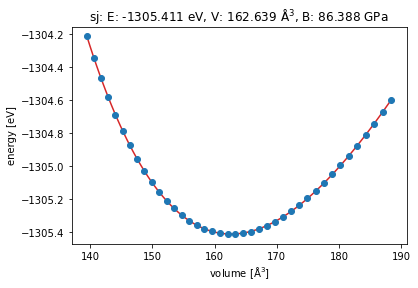

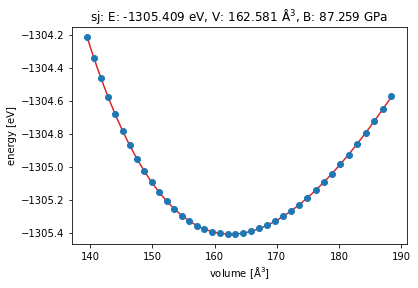

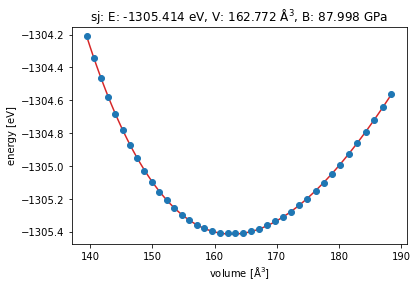

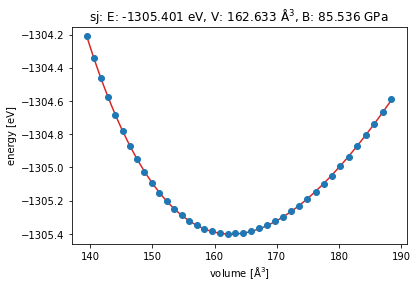

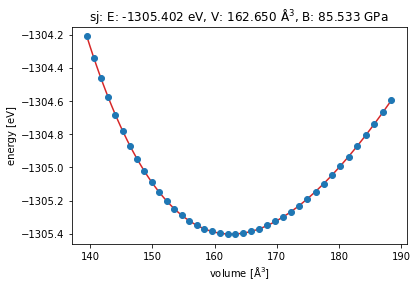

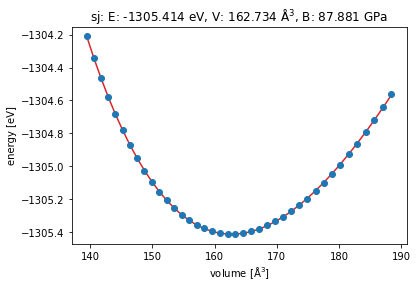

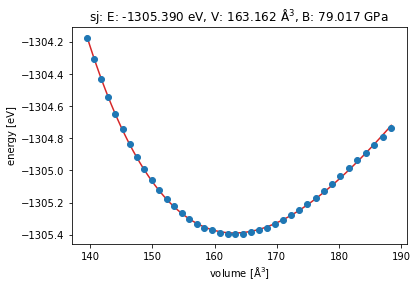

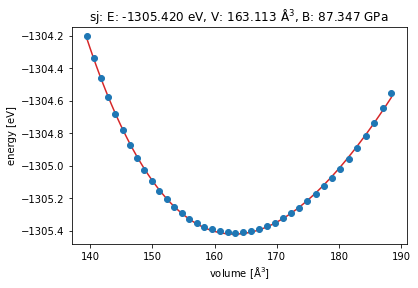

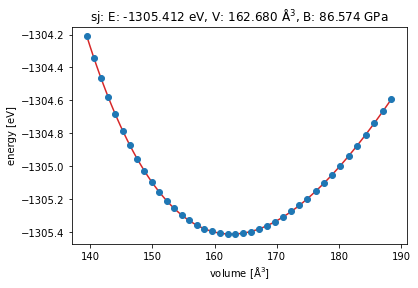

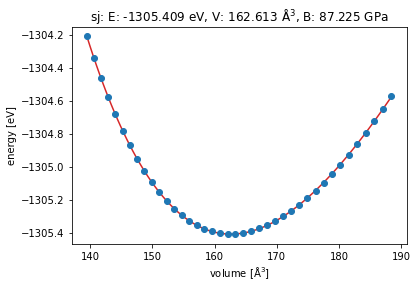

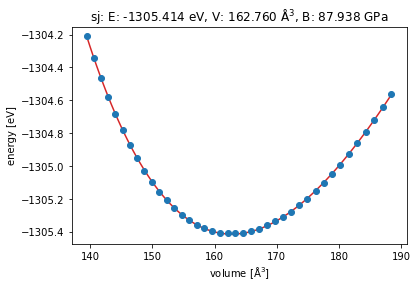

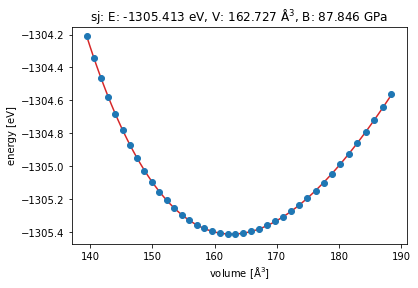

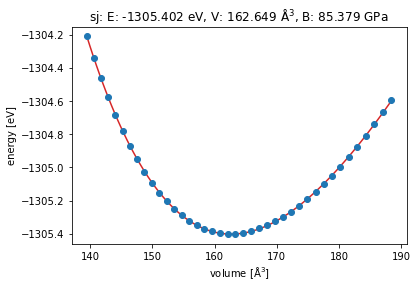

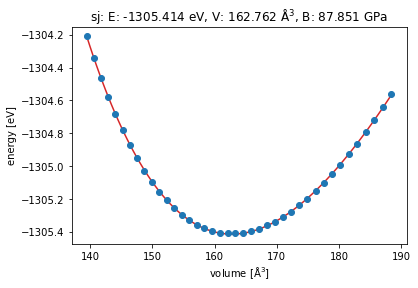

In [167]:
data = []
zeta = 4
for n_sparse, n_feature  in tqdm(list(product(n_sparses,n_features))):
    aa = {}
    aa['n_features'] = n_feature
    aa['n_sparse'] = n_sparse
    dd = best_scores.query("n_feature=={} and n_sparse=={}".format(n_feature,n_sparse))
    
    if dd.size > 0:
        aa['MAE_e'] = dd['MAE_e'].to_numpy()[0]
        aa['RMSE_e'] = dd['RMSE_e'].to_numpy()[0]
        aa['MAE_f'] = dd['MAE_f'].to_numpy()[0]
        aa['RMSE_f'] = dd['RMSE_f'].to_numpy()[0]
        lambdas=[dd['lambda_e'].values[0], dd['lambda_f'].values[0]]
        fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
        model = load_obj(fn)
    else:
        aa['B'] = np.nan
        aa['B_unit'] = 'GPa'
        aa['$V_0$'] = np.nan
        aa['a'] = np.nan
        data.append(aa)
        continue
        lambdas=[1e-2, 1e-1]
        fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(
                                        zeta, n_feature, n_sparse,lambda_e , lambda_f)
        X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
        KNM = np.load(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), mmap_mode='r')
        hypers = X_pseudo.representation._get_init_params()
        hypers['compute_gradients'] = True
        soap = SphericalInvariants(**hypers)
        kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

        model = train_gap_model_0(kernel, frames, KNM, X_pseudo, y_train, self_contributions, grad_train=-f_train, 
                        lambdas=[lambda_e , lambda_f], jitter=1e-8)
        dump_obj(fn, model)
    
    soap = model.kernel._rep

    latticeconstant = alat_ref
    frames = []
    volumes = []
    energies = []
    for lat in np.linspace(latticeconstant*0.95,latticeconstant*1.05, 40):
        atoms = bulk('Si', 'diamond', a=lat, cubic=True)
        volumes.append(atoms.get_volume())
        frames.append(atoms)
    managers = soap.transform(frames)
    energies = model.predict(managers)

    volumes = np.array(volumes).flatten()
    lats = np.power(volumes,1/3)
    energies = np.array(energies).flatten()
    eos = EquationOfState(volumes, energies)
    try:
        v0, e0, B = eos.fit()
        eos.plot()
        plt.show()
    except ValueError:
        v0, e0, B = np.nan,np.nan, np.nan
    # print(B / kJ * 1.0e24, 'GPa')
    aa['B'] = B / kJ * 1.0e24
    aa['B_unit'] = 'GPa'
    aa['$V_0$'] = v0
    aa['a'] = np.power(v0,1/3)
    data.append(aa)
    
data = pd.DataFrame(data)
    


In [168]:
data['B [%]'] = (data['B']-B_ref)/B_ref*100
data['a [%]'] = (data['a']-alat_ref)/alat_ref*100

In [ ]:
def delta_error(model,V0):
    

In [169]:
data.to_json(PATH+'Si-sparcification-figure-data.json')

## try out the generated models no signac with silicon benchmark routines

In [12]:
B_ref = 88.6 # GPa
V_ref = 20.34*8 # a**3
alat_ref = np.power(V_ref, 1/3) # A
V_ref,alat_ref

(162.72, 5.459425934895006)

In [15]:
scores = pd.read_json(PATH+'cv-score-all.json')
# scores = pd.DataFrame(frompickle(PATH+'cv-scores-2.pck'))

In [18]:
best_scores = scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).drop(columns=['tag']).reset_index()
best_scores.sort_values(['RMSE_e']).head(40)

tag  n_feature  n_sparse  lambda_e  lambda_f  index     MAE_e    RMSE_e  \
62   62        500      9000     0.005      0.10   3000  0.002448  0.004934   
61   61        357      9000     0.001      0.05   3166  0.002218  0.004939   
60   60        286      9000     0.001      0.05   1646  0.002232  0.004978   
63   63        715      9000     0.001      0.05   1806  0.002213  0.004982   
53   53        357      7000     0.005      0.10   5000  0.002490  0.005043   
44   44        286      5000     0.010      0.50   2435  0.002262  0.005096   
54   54        500      7000     0.005      0.10   2680  0.002453  0.005106   
45   45        357      5000     0.010      0.50   1235  0.002254  0.005123   
46   46        500      5000     0.005      0.10   4040  0.002540  0.005130   
52   52        286      7000     0.001      0.05   2526  0.002248  0.005131   
55   55        715      7000     0.010      0.50   3875  0.002257  0.005166   
47   47        715      5000     0.001      0.05   4366  0.002266  0.005185   
38   38        500      2000     0.005      0.50   4759  0.002429  0.005395   
37   37        357      2000     0.005      0.50   4599  0.002464  0.005547   
39   39        715      2000     0.005      0.50   3319  0.002488  0.005593   
59   59        143      9000     0.010      0.50   3795  0.002545  0.005695   
36   36        286      2000     0.001      0.10   2605  0.002540  0.005745   
51   51        143      7000     0.010      0.50   5075  0.002566  0.005934   
35   35        143      2000     0.001      0.10   4125  0.002659  0.005991   
43   43        143      5000     0.005      0.50   1159  0.002558  0.006005   
27   27        143      1000     0.001      0.05   3726  0.003106  0.006532   
28   28        286      1000     0.005      0.50   2199  0.002972  0.006950   
29   29        357      1000     0.005      0.50   2119  0.002974  0.007024   
30   30        500      1000     0.001      0.10   4285  0.002961  0.007051   
31   31        715      1000     0.005      0.50    679  0.002952  0.007052   
42   42         71      5000     0.001      0.10   1245  0.003474  0.008440   
34   34         71      2000     0.001      0.10    845  0.003517  0.008465   
50   50         71      7000     0.001      0.10   3565  0.003455  0.008499   
58   58         71      9000     0.005      0.50   4919  0.003440  0.008502   
26   26         71      1000     0.001      0.10    605  0.003664  0.008958   
19   19        143       500     0.005      0.50   3079  0.004028  0.009122   
20   20        286       500     0.001      0.10   2845  0.004656  0.010547   
23   23        715       500     0.001      0.10   3645  0.004629  0.010660   
22   22        500       500     0.001      0.10   4525  0.004654  0.010717   
21   21        357       500     0.001      0.10   3965  0.004678  0.010781   
18   18         71       500     0.005      0.10    600  0.005370  0.012223   
10   10         71       200     0.005      0.50   2279  0.006588  0.014595   
41   41         35      5000     0.010      0.50   1075  0.006859  0.014676   
49   49         35      7000     0.010      0.50   1395  0.006867  0.014695   
33   33         35      2000     0.010      0.50    915  0.006905  0.014711   

       SUP_e      R2_e    CORR_e     MAE_f    RMSE_f     SUP_f      R2_f  \
62  0.051579  0.999939  0.999775  0.053928  0.089699  2.194564  0.987361   
61  0.055229  0.999939  0.999807  0.060122  0.099772  2.497076  0.984360   
60  0.059575  0.999938  0.999808  0.060543  0.100200  2.400151  0.984228   
63  0.059631  0.999938  0.999810  0.060226  0.099868  2.519951  0.984334   
53  0.053928  0.999937  0.999773  0.054403  0.090442  2.173296  0.987151   
44  0.062445  0.999935  0.999806  0.061688  0.102237  2.343996  0.983576   
54  0.057934  0.999935  0.999783  0.054340  0.090263  2.169343  0.987205   
45  0.063060  0.999934  0.999813  0.061371  0.101842  2.363147  0.983704   
46  0.052646  0.999934  0.999768  0.055651  0.092466  2.006296  0.986565   
52  

### test routines

In [20]:
n_feature,n_sparse = 357,5000
zeta = 4
dd = best_scores.query("n_feature=={} and n_sparse=={}".format(n_feature,n_sparse))
lambdas=[dd['lambda_e'].values[0], dd['lambda_f'].values[0]]
fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
model = load_obj(fn)

hypers = model.X_train.representation._get_init_params()
hypers['compute_gradients'] = True
soap_ = SphericalInvariants(**hypers)
calc = ASEMLCalculator(model, soap_)

In [32]:
from ase.lattice.cubic import Diamond

a0 = (20.0*8)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

# set up the a
atoms = Diamond(symbol='Si', latticeconstant=a0)
atoms.set_calculator(calc)
(c11, c12, c44, E_vs_V) = lattice_cubic.do_lattice(atoms, elastic=True)
a0 = atoms.cell[0,0] # save lattice constant after relaxation

# dictionary of computed properties - this is output of this test, to
#   be compared with other models
properties = {'diamond_a0': a0, 'diamond_c11': c11, 'diamond_c12': c12, 'diamond_c44': c44, 
              'diamond_bulk_modulus': (c11+2.0*c12)/3.0, 'diamond_E_vs_V': E_vs_V }
print(properties)

relax_atoms_cell using method lbfgs_precon
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-8.94198376e-03 -8.94198376e-03 -8.94198376e-03 -2.73550248e-14
 -4.21619357e-14 -5.93686220e-15]
PreconLBFGS:   0  18:12:38    -1305.398589       0.0000       0.0089
[-0.00682469 -0.00682469 -0.00682469  0.00094018  0.00094018  0.00094018]
estimate_mu(): mu=1.0, mu_c=4.200449984750674


/home/musil/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ase/optimize/precon/precon.py:513: UserWarning: mu (0.000) < 1.0, capping at mu=1.0
  warnings.warn('mu (%.3f) < 1.0, capping at mu=1.0' % self.mu)


[-5.24372896e-05 -5.24372897e-05 -5.24372896e-05  3.74843915e-14
  3.52331240e-14  3.41905401e-14]
PreconLBFGS:   1  18:12:39    -1305.409934       0.0000       0.0001
relaxed bulk
8
Lattice="5.457727707026945 0.0 1.5855480150806717e-31 0.0 5.457727707026945 1.7296887437243692e-31 1.5855480150806717e-31 1.7296887437243692e-31 5.457727707026945" Properties=species:S:1:pos:R:3:forces:R:3 energy=-1305.4099335587327 stress="-5.2437289625118084e-05 0.0 1.3363823550460978e-51 0.0 -5.2437289625118084e-05 0.0 1.3363823550460978e-51 0.0 -5.2437289625118044e-05" free_energy=-1305.4099335587327 pbc="T T T"
Si      -0.00000000      -0.00000000      -0.00000000       0.00000000      -0.00000000       0.00000000
Si       1.36443193       1.36443193       1.36443193       0.00000000       0.00000000      -0.00000000
Si       2.72886385       2.72886385      -0.00000000       0.00000000      -0.00000000      -0.00000000
Si       4.09329578       4.09329578       1.36443193      -0.00000000      -0.000

relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-2.50793196e-02 -2.50793196e-02 -2.50793196e-02 -1.65264250e-14
  2.41308818e-14 -3.78048874e-15]
[-2.50793196e-02 -2.50793196e-02 -2.50793196e-02  0.00000000e+00
 -2.26908107e-33  0.00000000e+00]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 18:12:43    -1305.330402*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-2.04652945e-02 -2.04652945e-02 -2.04652945e-02  3.31313585e-14
  5.19596005e-14  2.44940250e-14]
[-2.04652945e-02 -2.04652945e-02 -2.04652945e-02 -3.61363206e-32
 -3.61363206e-32 -1.04981184e-63]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 18:12:43    -1305.355321*       0.0000
relax_atoms_cell using method 

relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[ 3.37493714e-02  3.37493714e-02  3.37493714e-02 -9.14310055e-15
 -1.83235959e-14 -1.95335680e-14]
[ 3.37493714e-02  3.37493714e-02  3.37493714e-02 -2.51892289e-32
 -2.68685108e-31 -7.31783153e-64]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 18:12:47    -1305.183070*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[ 3.64591862e-02  3.64591862e-02  3.64591862e-02 -2.55267388e-14
  5.48438750e-15 -1.15305805e-14]
[ 3.64591862e-02  3.64591862e-02  3.64591862e-02 -1.67176346e-32
 -1.67176346e-32 -4.85671212e-64]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 18:12:47    -1305.141517*       0.0000
relax_atoms_cell using method 

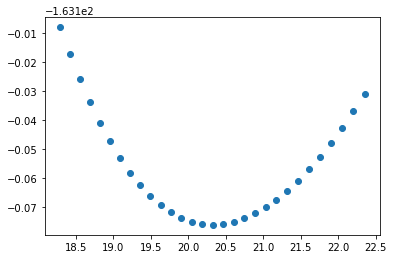

In [33]:
ev = np.zeros((len(E_vs_V),2))
for ii,(v,e) in enumerate(E_vs_V):
    ev[ii,0] = v
    ev[ii,1] = e[0]
    
plt.plot(ev[:,0],ev[:,1],'o')

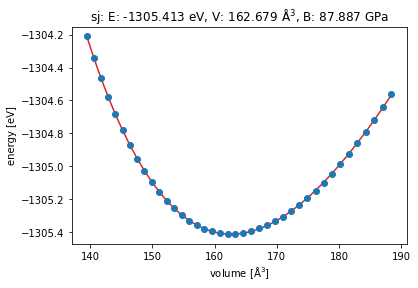

In [24]:
latticeconstant = alat_ref
frames = []
volumes = []
energies = []
for lat in np.linspace(latticeconstant*0.95,latticeconstant*1.05, 40):
    atoms = bulk('Si', 'diamond', a=lat, cubic=True)
    volumes.append(atoms.get_volume())
    frames.append(atoms)
managers = soap_.transform(frames)
energies = model.predict(managers)

volumes = np.array(volumes).flatten()
lats = np.power(volumes,1/3)
energies = np.array(energies).flatten()
eos = EquationOfState(volumes, energies)

v0, e0, B = eos.fit()
eos.plot()

In [21]:
a0 = (20.0*2)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

# set up the a
atoms = Atoms([14] * 2, positions=[(0.0, -0.25, -0.069), (0.0, 0.25, 0.069)], 
   cell=[ [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.5, 0.5, 0.276]], pbc=(1,1,1))

cell = atoms.get_cell()
cell *= (20.0*2/atoms.get_volume())**(1.0/3.0)
atoms.set_cell(cell, scale_atoms=True)

print("unrelaxed bulk")
ase.io.write(sys.stdout, atoms, format='extxyz')
atoms.set_calculator(calc)
(E_vs_V) = lattice_tetragonal.do_lattice(atoms, use_precon=False, elastic=False)

# dictionary of computed properties - this is output of this test, to
#   be compared with other models
properties = {'beta-Sn_E_vs_V': E_vs_V }

unrelaxed bulk
2
Lattice="5.2527125662666885 0.0 0.0 0.0 5.2527125662666885 0.0 2.6263562831333442 2.6263562831333442 1.4497486682896061" Properties=species:S:1:pos:R:3 pbc="T T T"
Si       0.00000000      -1.31317814      -0.36243717
Si       0.00000000       1.31317814       0.36243717
unrelaxed bulk
2
Lattice="5.2527125662666885 0.0 0.0 0.0 5.2527125662666885 0.0 2.6263562831333442 2.6263562831333442 1.4497486682896061" Properties=species:S:1:pos:R:3 pbc="T T T"
Si       0.00000000      -1.31317814      -0.36243717
Si       0.00000000       1.31317814       0.36243717
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[ 9.34868259e-02  9.34868259e-02  6.17388989e-02 -1.84529127e-14
  1.72085330e-14 -1.46392498e-13]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:44:03     -325.169768*       1.8697
[ 9.30242414e-02  9.30242414e-0

[ 5.29723339e-04  5.29723339e-04 -4.93312871e-05  1.52361931e-14
  7.96441704e-15 -3.17201033e-14]
FIRE:   50 17:44:06     -325.712961*       0.0089
[ 4.32487677e-04  4.32487677e-04 -9.66593119e-05  1.09196613e-13
 -4.51152431e-14 -1.20180273e-14]
FIRE:   51 17:44:06     -325.712963*       0.0073
[ 3.26322999e-04  3.26322999e-04 -1.46504887e-04 -3.32581366e-14
  1.03618001e-16 -5.75729717e-14]
FIRE:   52 17:44:06     -325.712964*       0.0055
[ 2.02903780e-04  2.02903779e-04 -2.01145461e-04  9.22221736e-14
  6.36482662e-14  5.20522885e-14]
FIRE:   53 17:44:06     -325.712965*       0.0034
[ 6.65303712e-05  6.65303709e-05 -2.55216680e-04 -2.24981389e-13
 -1.15578663e-14 -3.50093628e-14]
FIRE:   54 17:44:06     -325.712966*       0.0043
[-6.96578878e-05 -6.96578880e-05 -2.97529453e-04  2.79064553e-14
 -8.27778071e-15  4.55320930e-14]
FIRE:   55 17:44:06     -325.712967*       0.0050
[-6.82083844e-05 -6.82083847e-05 -2.95688049e-04 -1.12593656e-13
 -1.08623681e-14  1.47034617e-13]
FIRE:  

[-8.78050274e-02 -8.78050274e-02 -8.68399121e-02 -6.06519804e-14
 -1.10115977e-14 -1.08689500e-15]
[-8.78050274e-02 -8.78050274e-02 -8.68399121e-02  5.27355937e-16
 -2.22044605e-16 -8.63067205e-17]
FIRE:   12 17:44:08     -325.590771*       0.0034
[-8.78532605e-02 -8.78532605e-02 -8.67700257e-02 -2.79092292e-14
 -3.51068467e-15 -4.35596245e-14]
[-8.78532605e-02 -8.78532605e-02 -8.67700257e-02  3.33066907e-16
 -3.33066907e-16 -6.87842146e-17]
FIRE:   13 17:44:08     -325.590771*       0.0023
[-8.79093156e-02 -8.79093156e-02 -8.66889318e-02 -9.53427066e-14
 -1.17890800e-14  9.96967615e-14]
[-8.79093156e-02 -8.79093156e-02 -8.66889318e-02  4.44089210e-16
 -2.77555756e-16 -7.19848743e-17]
FIRE:   14 17:44:09     -325.590772*       0.0009
done relaxing step 0
done evaluate step 0
EV  0 27.683340736425112 [-325.59077178] [-8.79093156e-02 -8.79093156e-02 -8.66889318e-02  4.99600361e-16
 -2.22044605e-16 -7.19848743e-17]
doing volume step 1
relax_atoms_cell using method fire
symmetry.prep got s

[-7.29319384e-02 -7.29319384e-02 -7.38440581e-02 -8.11995147e-14
 -3.56829720e-14 -1.30530470e-13]
[-7.29319384e-02 -7.29319384e-02 -7.38440581e-02  3.60822483e-16
 -1.38777878e-16 -2.56157178e-17]
FIRE:   13 17:44:10     -325.622732*       0.0190
[-7.31693015e-02 -7.31693015e-02 -7.35016515e-02  9.68092592e-14
 -1.61968019e-14  7.92659391e-14]
[-7.31693015e-02 -7.31693015e-02 -7.35016515e-02  2.49800181e-16
 -2.22044605e-16 -9.75301075e-18]
FIRE:   14 17:44:10     -325.622749*       0.0132
[-7.34474038e-02 -7.34474038e-02 -7.30937757e-02  2.22556708e-15
 -6.42341280e-15  5.80136677e-14]
[-7.34474038e-02 -7.34474038e-02 -7.30937757e-02  3.60822483e-16
 -1.66533454e-16 -1.66664126e-17]
FIRE:   15 17:44:11     -325.622761*       0.0063
[-7.37636747e-02 -7.37636747e-02 -7.26437817e-02  1.18577286e-14
  4.35895037e-14 -1.14176540e-13]
[-7.37636747e-02 -7.37636747e-02 -7.26437817e-02  3.33066907e-16
 -1.66533454e-16  9.12402863e-18]
FIRE:   16 17:44:11     -325.622764*       0.0014
[-7.3763

[-6.50547885e-02 -6.50547885e-02 -5.36918205e-02  3.40260384e-14
  1.13345156e-14 -7.16695109e-14]
[-6.50547885e-02 -6.50547885e-02 -5.36918205e-02  4.57966998e-16
 -2.91433544e-16 -9.86380541e-18]
FIRE:    1 17:44:12     -325.648387*       0.1074
[-6.43213206e-02 -6.43213206e-02 -5.45821638e-02 -2.40186097e-14
 -2.04825386e-14  1.50380188e-13]
[-6.43213206e-02 -6.43213206e-02 -5.45821638e-02  5.41233725e-16
 -2.77555756e-16 -1.18650134e-17]
FIRE:    2 17:44:13     -325.648720*       0.0911
[-6.32895874e-02 -6.32895874e-02 -5.58351057e-02 -6.03672430e-15
 -1.67308207e-14 -1.06485022e-13]
[-6.32895874e-02 -6.32895874e-02 -5.58351057e-02  3.74700271e-16
 -2.63677968e-16 -1.48165520e-17]
FIRE:    3 17:44:13     -325.649095*       0.0681
[-6.20493110e-02 -6.20493110e-02 -5.74092598e-02  8.10770578e-14
 -2.54075939e-14 -1.26137351e-13]
[-6.20493110e-02 -6.20493110e-02 -5.74092598e-02  3.74700271e-16
 -2.08166817e-16  1.64604215e-17]
FIRE:    4 17:44:13     -325.649405*       0.0397
[-6.0699

[-5.39684357e-02 -5.39684357e-02 -5.35010456e-02  3.46681045e-14
 -5.63860154e-14  1.22208272e-13]
[-5.39684357e-02 -5.39684357e-02 -5.35010456e-02  2.35922393e-16
 -2.08166817e-16 -1.36346864e-17]
FIRE:   16 17:44:15     -325.661090*       0.0012
[-5.41444354e-02 -5.41444354e-02 -5.32625937e-02  1.69955659e-14
 -2.85040890e-14 -9.12512996e-14]
[-5.41444354e-02 -5.41444354e-02 -5.32625937e-02  2.77555756e-16
 -2.08166817e-16 -3.43468988e-17]
FIRE:   17 17:44:15     -325.661089*       0.0030
[-5.41431898e-02 -5.41431898e-02 -5.32642754e-02 -4.60363321e-14
  1.65683675e-14 -1.61885621e-13]
[-5.41431898e-02 -5.41431898e-02 -5.32642754e-02  2.77555756e-16
 -1.52655666e-16 -6.73496487e-18]
FIRE:   18 17:44:15     -325.661089*       0.0030
[-5.41407110e-02 -5.41407110e-02 -5.32676227e-02  7.65987365e-14
 -1.22185709e-14  8.42981505e-14]
[-5.41407110e-02 -5.41407110e-02 -5.32676227e-02  2.08166817e-16
 -1.66533454e-16 -2.96074416e-17]
FIRE:   19 17:44:15     -325.661089*       0.0029
[-5.4137

[-4.51542717e-02 -4.51542717e-02 -3.63374144e-02 -1.54852232e-13
  4.65029253e-15 -6.48917668e-14]
[-4.51542717e-02 -4.51542717e-02 -3.63374144e-02  3.19189120e-16
 -2.08166817e-16 -1.72360679e-17]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:44:17     -325.679670*       0.0855
[-4.49047498e-02 -4.49047498e-02 -3.66455087e-02 -1.09390456e-13
 -1.67808800e-14  9.87338794e-14]
[-4.49047498e-02 -4.49047498e-02 -3.66455087e-02  3.74700271e-16
 -2.08166817e-16 -2.89677682e-17]
FIRE:    1 17:44:17     -325.679776*       0.0799
[-4.44244332e-02 -4.44244332e-02 -3.72501207e-02 -2.93968598e-14
 -5.27030426e-14  3.46854083e-14]
[-4.44244332e-02 -4.44244332e-02 -3.72501207e-02  3.33066907e-16
 -1.94289029e-16 -2.26690971e-17]
FIRE:    2 17:44:17     -325.679961*       0.0689
[-4.37491954e-02 -4.37491954e-02 -3.81261018e-02 -5.78937812e-14
 -6.75581845e-15 -1.02450710e-13]
[-4.37491954e-02 -4.37491954e-02 -3.81261018e-02  3.4694469

[-3.53353627e-02 -3.53353627e-02 -3.57545839e-02  5.33170413e-14
  6.11763248e-15  1.55696806e-13]
[-3.53353627e-02 -3.53353627e-02 -3.57545839e-02  2.22044605e-16
 -1.52655666e-16 -3.08787342e-17]
FIRE:    6 17:44:19     -325.688374*       0.0074
[-3.53403431e-02 -3.53403431e-02 -3.57473556e-02 -7.50055545e-15
  1.23826132e-14  4.59384451e-14]
[-3.53403431e-02 -3.53403431e-02 -3.57473556e-02  2.35922393e-16
 -1.52655666e-16 -2.44954147e-17]
FIRE:    7 17:44:19     -325.688374*       0.0073
[-3.53502215e-02 -3.53502215e-02 -3.57330241e-02 -2.21936205e-14
  3.40529685e-14  8.87172815e-14]
[-3.53502215e-02 -3.53502215e-02 -3.57330241e-02  2.49800181e-16
 -1.11022302e-16 -1.19285270e-17]
FIRE:    8 17:44:19     -325.688375*       0.0070
[-3.53648344e-02 -3.53648344e-02 -3.57118380e-02 -4.01698513e-14
  4.00709861e-15 -6.28267409e-14]
[-3.53648344e-02 -3.53648344e-02 -3.57118380e-02  2.22044605e-16
 -1.52655666e-16 -1.31010888e-17]
FIRE:    9 17:44:19     -325.688375*       0.0067
[-3.5383

[-2.63660434e-02 -2.63660434e-02 -2.17803224e-02  3.45836825e-14
 -2.14912876e-14 -4.46403616e-14]
[-2.63660434e-02 -2.63660434e-02 -2.17803224e-02  1.94289029e-16
 -1.31838984e-16 -1.11432829e-17]
FIRE:    2 17:44:21     -325.700466*       0.0451
[-2.59683793e-02 -2.59683793e-02 -2.22500911e-02 -4.71441792e-14
  8.44508846e-14  7.79778988e-14]
[-2.59683793e-02 -2.59683793e-02 -2.22500911e-02  2.08166817e-16
 -1.11022302e-16  7.66802217e-19]
FIRE:    3 17:44:21     -325.700558*       0.0363
[-2.54782925e-02 -2.54782925e-02 -2.28452087e-02  5.81868704e-15
  3.50503067e-14  3.52826733e-14]
[-2.54782925e-02 -2.54782925e-02 -2.28452087e-02  2.08166817e-16
 -1.17961196e-16 -1.66794562e-17]
FIRE:    4 17:44:21     -325.700644*       0.0252
[-2.49265611e-02 -2.49265611e-02 -2.35368754e-02  9.17373312e-16
  4.03231616e-14  2.03665743e-14]
[-2.49265611e-02 -2.49265611e-02 -2.35368754e-02  1.66533454e-16
 -1.11022302e-16  7.12958732e-18]
FIRE:    5 17:44:21     -325.700704*       0.0125
[-2.4349

[-1.38518368e-02 -1.38518368e-02 -1.40988930e-02  8.66866243e-14
  2.16521798e-14  1.29946755e-13]
[-1.38518368e-02 -1.38518368e-02 -1.40988930e-02  1.11022302e-16
 -6.93889390e-17 -3.76914366e-18]
FIRE:   15 17:44:23     -325.708684*       0.0032
[-1.38851249e-02 -1.38851249e-02 -1.40593458e-02  1.25570998e-14
 -3.95947469e-14 -3.13698768e-14]
[-1.38851249e-02 -1.38851249e-02 -1.40593458e-02  1.14491749e-16
 -6.59194921e-17 -7.53145820e-18]
FIRE:   16 17:44:23     -325.708685*       0.0024
[-1.39243990e-02 -1.39243990e-02 -1.40128117e-02 -1.25782095e-15
  1.12904427e-14  5.55905056e-14]
[-1.39243990e-02 -1.39243990e-02 -1.40128117e-02  1.07552856e-16
 -6.24500451e-17 -6.63140027e-18]
FIRE:   17 17:44:23     -325.708686*       0.0016
[-1.39696755e-02 -1.39696755e-02 -1.39593324e-02  4.00748218e-14
 -1.94090093e-16  2.03808928e-14]
[-1.39696755e-02 -1.39696755e-02 -1.39593324e-02  1.00613962e-16
 -5.20417043e-17 -1.06679040e-17]
FIRE:   18 17:44:23     -325.708686*       0.0006
done rel

done relaxing step 14
done evaluate step 14
EV  14 30.552840471393818 [-325.7125184] [-4.34559895e-03 -4.34559895e-03 -4.42763563e-03  3.81639165e-17
 -2.42861287e-17 -1.24092756e-18]
doing volume step 15
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[ 1.15148294e-04  1.15148294e-04  1.01650842e-04 -3.77431752e-14
 -9.52456350e-14 -1.50161660e-14]
[ 1.15148294e-04  1.15148294e-04  1.01650842e-04 -9.21571847e-19
  6.50521303e-19  7.18754822e-20]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:44:25     -325.712968*       0.0001
done relaxing step 15
done evaluate step 15
EV  15 30.76494581143085 [-325.71296797] [ 1.15148294e-04  1.15148294e-04  1.01650842e-04 -9.21571847e-19
  6.50521303e-19  7.18754822e-20]
doing volume step 16
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Herm

[ 8.44510550e-03  8.44510550e-03  8.54666042e-03  9.34215124e-14
 -4.90980910e-14 -1.38061312e-13]
[ 8.44510550e-03  8.44510550e-03  8.54666042e-03 -1.04083409e-17
  1.38777878e-17 -6.86482115e-19]
FIRE:   19 17:44:27     -325.711099*       0.0007
done relaxing step 17
done evaluate step 17
EV  17 31.19181927018367 [-325.71109923] [ 8.44510550e-03  8.44510550e-03  8.54666042e-03 -6.93889390e-18
  1.38777878e-17 -6.86482115e-19]
doing volume step 18
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[ 1.43163327e-02  1.43163327e-02  1.09865897e-02 -6.36241819e-14
  1.85463564e-14  5.53993466e-14]
[ 1.43163327e-02  1.43163327e-02  1.09865897e-02 -1.00613962e-16
  4.51028104e-17 -1.23159408e-18]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:44:27     -325.708610*       0.0349
[ 1.42441378e-02  1.42441378e-02  1.10452545e-02  1.17511

[ 1.58915214e-02  1.58915214e-02  1.62033008e-02 -3.78517468e-14
 -4.06544564e-14 -1.11241669e-13]
[ 1.58915214e-02  1.58915214e-02  1.62033008e-02 -1.04083409e-17
  2.08166817e-17  8.26509657e-18]
FIRE:    9 17:44:29     -325.705777*       0.0015
[ 1.58935084e-02  1.58935084e-02  1.62022077e-02  6.05283840e-14
 -3.46916524e-15 -3.91229626e-14]
[ 1.58935084e-02  1.58935084e-02  1.62022077e-02 -2.08166817e-17
  1.73472348e-17  1.76423888e-18]
FIRE:   10 17:44:29     -325.705777*       0.0015
[1.58964636e-02 1.58964636e-02 1.62005815e-02 1.16148647e-13
 3.16548320e-14 3.68394042e-14]
[ 1.58964636e-02  1.58964636e-02  1.62005815e-02 -1.38777878e-17
  1.38777878e-17  8.97746922e-18]
FIRE:   11 17:44:29     -325.705777*       0.0015
[ 1.59003566e-02  1.59003566e-02  1.61984382e-02 -8.40606711e-14
  2.02530028e-14 -5.45569765e-14]
[1.59003566e-02 1.59003566e-02 1.61984382e-02 6.93889390e-18
 2.08166817e-17 2.85972955e-18]
FIRE:   12 17:44:29     -325.705777*       0.0014
[ 1.59051478e-02  1.

[ 2.72125562e-02  2.72125562e-02  2.06114114e-02 -7.60750129e-14
 -1.79586034e-14  2.21972828e-14]
[ 2.72125562e-02  2.72125562e-02  2.06114114e-02 -1.80411242e-16
  8.32667268e-17  3.94844860e-18]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:44:31     -325.696095*       0.0705
[ 2.70808905e-02  2.70808905e-02  2.06998111e-02  1.15677116e-13
 -1.69671653e-14 -8.94545879e-14]
[ 2.70808905e-02  2.70808905e-02  2.06998111e-02 -1.59594560e-16
  1.17961196e-16 -2.25437990e-18]
FIRE:    1 17:44:31     -325.696169*       0.0683
[ 2.68201514e-02  2.68201514e-02  2.08701138e-02 -1.28487093e-13
 -3.88897407e-14  5.52961759e-14]
[ 2.68201514e-02  2.68201514e-02  2.08701138e-02 -1.38777878e-17
  6.93889390e-18 -1.54581795e-17]
FIRE:    2 17:44:31     -325.696306*       0.0640
[ 2.64356346e-02  2.64356346e-02  2.11099560e-02 -1.21705462e-13
 -8.76979735e-15 -5.18278793e-15]
[ 2.64356346e-02  2.64356346e-02  2.11099560e-02 -6.9388939

[ 2.50714499e-02  2.50714499e-02  2.60393689e-02 -6.85762775e-14
 -9.84837661e-15  9.51296031e-14]
[ 2.50714499e-02  2.50714499e-02  2.60393689e-02 -2.77555756e-17
  4.16333634e-17  9.43803740e-18]
FIRE:    9 17:44:33     -325.692031*       0.0039
[ 2.50744333e-02  2.50744333e-02  2.60387144e-02  1.30019001e-13
 -1.04296439e-14  5.02909709e-15]
[ 2.50744333e-02  2.50744333e-02  2.60387144e-02 -3.46944695e-17
  2.77555756e-17  1.39084395e-18]
FIRE:   10 17:44:33     -325.692031*       0.0039
[ 2.50803720e-02  2.50803720e-02  2.60374103e-02 -1.13651944e-13
 -3.72212329e-14 -1.19943286e-13]
[ 2.50803720e-02  2.50803720e-02  2.60374103e-02 -6.93889390e-18
  2.08166817e-17  3.53328796e-18]
FIRE:   11 17:44:33     -325.692031*       0.0038
[ 2.50892097e-02  2.50892097e-02  2.60354661e-02  1.12709454e-14
 -7.60902748e-14 -1.73518328e-13]
[ 2.50892097e-02  2.50892097e-02  2.60354661e-02 -4.16333634e-17
  2.77555756e-17 -1.63064291e-17]
FIRE:   12 17:44:33     -325.692031*       0.0037
[ 2.5100

[ 2.71214441e-02  2.71214441e-02  2.88303388e-02 -1.47006105e-13
 -3.70095414e-14  4.87205715e-14]
[ 2.71214441e-02  2.71214441e-02  2.88303388e-02 -8.32667268e-17
  2.77555756e-17 -1.88565918e-17]
FIRE:   19 17:44:35     -325.686088*       0.0091
[2.73085168e-02 2.73085168e-02 2.88134043e-02 1.20507034e-13
 2.43113559e-14 7.62587570e-15]
[ 2.73085168e-02  2.73085168e-02  2.88134043e-02 -7.63278329e-17
  6.24500451e-17  8.18049798e-18]
FIRE:   20 17:44:35     -325.686097*       0.0070
[ 2.75185795e-02  2.75185795e-02  2.87901362e-02  5.61613192e-14
  1.61373328e-14 -7.96586109e-14]
[ 2.75185795e-02  2.75185795e-02  2.87901362e-02 -4.85722573e-17
  4.16333634e-17 -8.55447348e-18]
FIRE:   21 17:44:36     -325.686106*       0.0047
[ 2.77601486e-02  2.77601486e-02  2.87610155e-02 -1.95105356e-13
  4.60126672e-14  9.61589430e-14]
[ 2.77601486e-02  2.77601486e-02  2.87610155e-02 -6.93889390e-17
  5.55111512e-17 -4.35953836e-18]
FIRE:   22 17:44:36     -325.686112*       0.0020
[ 2.80306434e-

[ 4.23352500e-02  4.23352500e-02  3.18228159e-02  1.35924704e-14
  1.64864471e-14 -6.47762883e-14]
[4.23352500e-02 4.23352500e-02 3.18228159e-02 0.00000000e+00
 0.00000000e+00 1.77767253e-17]
FIRE:    1 17:44:37     -325.667945*       0.1158
[ 4.19584288e-02  4.19584288e-02  3.19874994e-02 -7.34818912e-15
  2.71781410e-14 -4.18937827e-14]
[ 4.19584288e-02  4.19584288e-02  3.19874994e-02 -2.77555756e-17
  0.00000000e+00  9.58200389e-18]
FIRE:    2 17:44:38     -325.668342*       0.1105
[ 4.13923731e-02  4.13923731e-02  3.22076769e-02 -1.24783456e-13
 -3.69981822e-14 -5.20952374e-14]
[ 4.13923731e-02  4.13923731e-02  3.22076769e-02 -1.38777878e-17
  4.16333634e-17  4.08419081e-18]
FIRE:    3 17:44:38     -325.668894*       0.1029
[ 4.06377645e-02  4.06377645e-02  3.24769559e-02  9.22471508e-14
 -3.46153516e-14 -1.07429654e-13]
[ 4.06377645e-02  4.06377645e-02  3.24769559e-02 -2.77555756e-17
  5.55111512e-17 -2.28762675e-17]
FIRE:    4 17:44:38     -325.669550*       0.0929
[ 3.96967315e-

[3.64563748e-02 3.64563748e-02 3.54549271e-02 2.57194366e-14
 5.32849823e-14 1.73421411e-13]
[ 3.64563748e-02  3.64563748e-02  3.54549271e-02 -5.55111512e-17
  4.16333634e-17  1.67537098e-18]
FIRE:    9 17:44:40     -325.664929*       0.0267
[ 3.38916140e-02  3.38916140e-02  3.52570524e-02 -4.18166531e-15
  2.93671847e-14 -3.82033106e-14]
[ 3.38916140e-02  3.38916140e-02  3.52570524e-02 -4.85722573e-17
  3.46944695e-17  4.76029361e-18]
FIRE:   10 17:44:40     -325.665212*       0.0036
[ 3.09626619e-02  3.09626619e-02  3.48958635e-02  1.49873435e-14
 -6.82179166e-14  2.47651076e-14]
[ 3.09626619e-02  3.09626619e-02  3.48958635e-02 -9.02056208e-17
  5.55111512e-17  1.03275908e-17]
FIRE:   11 17:44:40     -325.665026*       0.0217
[ 3.09875271e-02  3.09875271e-02  3.48994295e-02 -3.26978412e-14
  1.48623286e-14  4.78025234e-14]
[ 3.09875271e-02  3.09875271e-02  3.48994295e-02 -1.04083409e-16
  4.85722573e-17  3.48901055e-18]
FIRE:   12 17:44:40     -325.665029*       0.0215
[ 3.10370035e-

[ 3.30356585e-02  3.30356585e-02  3.65292592e-02 -1.81254921e-14
 -2.53504844e-14  1.66496353e-14]
[ 3.30356585e-02  3.30356585e-02  3.65292592e-02 -8.32667268e-17
  5.55111512e-17  8.79854983e-18]
FIRE:   16 17:44:42     -325.657371*       0.0135
[ 3.31363827e-02  3.31363827e-02  3.65457478e-02  7.01607747e-14
 -8.50794429e-15  9.35946775e-14]
[ 3.31363827e-02  3.31363827e-02  3.65457478e-02 -4.85722573e-17
  8.32667268e-17  8.62116544e-18]
FIRE:   17 17:44:42     -325.657380*       0.0126
[ 3.32513957e-02  3.32513957e-02  3.65644540e-02 -6.57499974e-14
  3.40125218e-14  6.64559787e-14]
[ 3.32513957e-02  3.32513957e-02  3.65644540e-02 -4.85722573e-17
  4.16333634e-17 -1.09195928e-17]
FIRE:   18 17:44:42     -325.657390*       0.0117
[ 3.34029181e-02  3.34029181e-02  3.65890389e-02 -2.75703734e-13
  8.25593461e-14  8.49808810e-14]
[ 3.34029181e-02  3.34029181e-02  3.65890389e-02 -9.71445147e-17
  6.93889390e-17  9.07259286e-18]
FIRE:   19 17:44:42     -325.657400*       0.0104
[3.35775

[ 3.53901060e-02  3.53901060e-02  3.81231240e-02 -1.46205975e-13
  6.35715795e-14  7.72910080e-14]
[ 3.53901060e-02  3.53901060e-02  3.81231240e-02 -1.11022302e-16
  9.02056208e-17 -2.10730568e-17]
FIRE:   23 17:44:44     -325.649375*       0.0017
[ 3.55870251e-02  3.55870251e-02  3.81499189e-02 -2.87353652e-14
  8.31483777e-14 -1.40000350e-14]
[ 3.55870251e-02  3.55870251e-02  3.81499189e-02 -1.17961196e-16
  9.02056208e-17 -3.81858039e-18]
FIRE:   24 17:44:44     -325.649376*       0.0001
done relaxing step 28
done evaluate step 28
EV  28 33.557435625349115 [-325.64937631] [ 3.55870251e-02  3.55870251e-02  3.81499189e-02 -1.04083409e-16
  9.71445147e-17 -3.81858039e-18]
doing volume step 29
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[ 5.58083910e-02  5.58083910e-02  4.11240983e-02  1.23697502e-13
 -3.69331586e-14  8.74275971e-14]
[ 5.58083910e-02  5.58083910e-02  4.11240983e-02 -4.718

### the real deal

In [24]:
dft_diamond = {"diamond_bulk_modulus": 88.596696666666602, "diamond_c12": 56.25008999999995, 
               "diamond_c11": 153.28990999999988, 
               "diamond_E_vs_V": [[17.813109023568057, -163.06663280425], [18.322054995670012, -163.110046112], [18.831000967771949, -163.1415028745], [19.339946939873919, -163.162464704125], [19.848892911975845, -163.174242557], [20.3578388840778, -163.177966801875], [20.866784856179741, -163.17463056225], [21.375730828281693, -163.165132595375], [21.884676800383637, -163.150242437875], [22.393622772485578, -163.130671150875], [22.902568744587512, -163.107009425875], [23.411514716689464, -163.079814823625]], 
               "diamond_c44": 72.176929999999999, "diamond_a0": 5.4610215037046075}
dft_beta = {"beta-Sn_E_vs_V": [[13.462620304548336, -162.75664626205], [13.847236220240584, -162.7954601585], [14.231905420366559, -162.8239554888], [14.616528955757214, -162.84260051285], [15.00117439209707, -162.85309453065], [15.385871808743351, -162.85631297195], [15.770478826496822, -162.85333965315], [16.155054108065379, -162.84486224], [16.539436349955054, -162.8314338523], [16.924316511337032, -162.8142848878], [17.30841204863296, -162.79382098635], [17.692092233780102, -162.7710455315]]}

gap_diamond = {"diamond_bulk_modulus": 88.810217439942406, "diamond_c12": 57.523403533287755, 
               "diamond_c11": 151.38384525325171, 
               "diamond_E_vs_V": [[17.810988598616127, -163.0664086908508], [18.319873987148007, -163.10988532610546], [18.828759375679891, -163.14135897170343], [19.337644764211802, -163.1623186809442], [19.846530152743675, -163.17407908173888], [20.355415541275576, -163.17779158878503], [20.86430092980746, -163.1744678303302], [21.373186318339357, -163.16500928944993], [21.882071706871262, -163.15020272752062], [22.390957095403131, -163.1306956287047], [22.899842483935011, -163.10696484343256], [23.408727872466905, -163.07932039246145]], 
               "diamond_c44": 67.863738907524706, "diamond_a0": 5.4608048066315646}
gap_beta = {"beta-Sn_E_vs_V": [[13.465116166235187, -162.756982002394], [13.849858877460129, -162.796042568673], [14.234584155825146, -162.82424331236527], [14.619295234903449, -162.84294972866076], [15.003995728073107, -162.85335269692362], [15.388775235337983, -162.8565959250381], [15.773396445685728, -162.8536215680949], [16.158073550313262, -162.84522081837233], [16.542715740495883, -162.83209563207012], [16.927464850798, -162.81488556365795], [17.312223899064762, -162.79421211616383], [17.697071528706459, -162.7707194529073]]}

In [69]:
interp1d?

In [70]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
def interp_EvsV(E_vs_V):
    ev = np.zeros((2,len(E_vs_V)))
    for ii,(v,e) in enumerate(E_vs_V):
        ev[0,ii] = v
        try:
            ev[1,ii] = e[0]
        except:
            ev[1,ii] = e
    func = interp1d(ev[0], ev[1], kind='cubic')
    return func
def interp_EvsV(E_vs_V):
    ev = np.zeros((2,len(E_vs_V)))
    for ii,(v,e) in enumerate(E_vs_V):
        ev[0,ii] = v
        try:
            ev[1,ii] = e[0]
        except:
            ev[1,ii] = e
    func = interp1d(ev[0], ev[1], kind='quadratic')
    return func

def compute_delta(E_vs_V_ref, E_vs_V):
    func_ref = interp_EvsV(E_vs_V_ref)
    func = interp_EvsV(E_vs_V)
    mini = minimize(func_ref, E_vs_V_ref[1][0])
    V0 = mini.x[0]
    print('V0',V0)
    try:
        integral,_ = quad(lambda x: np.square(func(x)-func_ref(x)), 0.94*V0, 1.06*V0)
        delta = np.sqrt(integral/(0.12*V0))
    except:
        delta = np.nan
    
    return delta

delta = {}
delta['ref|gap diamond'] = compute_delta(dft_diamond['diamond_E_vs_V'], gap_diamond['diamond_E_vs_V'])*1000
delta['ref|gap beta-Sn'] = compute_delta(dft_beta['beta-Sn_E_vs_V'], gap_beta['beta-Sn_E_vs_V'])*1000
delta

V0 20.363280717986385
V0 15.386157626725652


{'ref|gap diamond': 0.15858604156516878,
 'ref|gap beta-Sn': 0.31168148552938524}

In [30]:
data = []
zeta = 4
E_vs_V_data = []

for n_sparse, n_feature  in tqdm(list(product(n_sparses,n_features))):
    aa = {}
    aa['n_features'] = n_feature
    aa['n_sparse'] = n_sparse
    dd = best_scores.query("n_feature=={} and n_sparse=={}".format(n_feature,n_sparse))
    
    aa['MAE_e'] = dd['MAE_e'].to_numpy()[0]
    aa['RMSE_e'] = dd['RMSE_e'].to_numpy()[0]
    aa['MAE_f'] = dd['MAE_f'].to_numpy()[0]
    aa['RMSE_f'] = dd['RMSE_f'].to_numpy()[0]
    lambdas=[dd['lambda_e'].values[0], dd['lambda_f'].values[0]]
    aa['lambda_e'] = lambdas[0]
    aa['lambda_f'] = lambdas[1]
    
    fn = PATH+'model_z{}_np{}_nf{}_lmde{:.0e}_lmdf{:.0e}.json'.format(zeta, n_feature, n_sparse, lambdas[0], lambdas[1])
    model = load_obj(fn)
    
    hypers = model.X_train.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap_ = SphericalInvariants(**hypers)
    calc = ASEMLCalculator(model, soap_)
    
    a0 = (20.0*8)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

    # set up the a
    atoms = Diamond(symbol='Si', latticeconstant=a0)
    atoms.set_calculator(calc)
    (c11, c12, c44, E_vs_V) = lattice_cubic.do_lattice(atoms, use_precon=False, elastic=True)
    a0 = atoms.cell[0,0] # save lattice constant after relaxation

    # dictionary of computed properties - this is output of this test, to
    #   be compared with other models
    properties = {'diamond_a0': a0, 'diamond_c11': c11, 'diamond_c12': c12, 'diamond_c44': c44, 
                  'diamond_bulk_modulus': (c11+2.0*c12)/3.0, 'diamond_E_vs_V': E_vs_V }
    
    for ii,(v,e) in enumerate(E_vs_V):
        E_vs_V_data.append({'V':v,'E':e[0],'lattice':'diamond',
                            'n_feature':n_feature,'n_sparse':n_sparse})
        
    # print(B / kJ * 1.0e24, 'GPa')
    aa['$\Delta$ diamond'] = compute_delta(dft_diamond['diamond_E_vs_V'], E_vs_V)*1000
    aa['$c_{11}$'] = c11
    aa['$c_{12}$'] = c12
    aa['$c_{44}$'] = c44
    aa['B'] = (c11+2.0*c12)/3.0
    aa['elatic unit'] = 'GPa'
    aa['$\Delta$ unit'] = 'meV'
    aa['$V_0$ diamond'] = a0**3
    aa['$a_0$ diamond'] = a0
    
    
    a0 = (20.0*2)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

    # set up the a
    atoms = Atoms([14] * 2, positions=[(0.0, -0.25, -0.069), (0.0, 0.25, 0.069)], 
       cell=[ [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.5, 0.5, 0.276]], pbc=(1,1,1))

    cell = atoms.get_cell()
    cell *= (20.0*2/atoms.get_volume())**(1.0/3.0)
    atoms.set_cell(cell, scale_atoms=True)

    print("unrelaxed bulk")
    ase.io.write(sys.stdout, atoms, format='extxyz')
    atoms.set_calculator(calc)
    (E_vs_V) = lattice_tetragonal.do_lattice(atoms, use_precon=False, elastic=False)

    # dictionary of computed properties - this is output of this test, to
    #   be compared with other models
    properties = {'beta-Sn_E_vs_V': E_vs_V }
    
    for ii,(v,e) in enumerate(E_vs_V):
        E_vs_V_data.append({'V':v,'E':e[0],'lattice':'$\beta$-Sn',
                            'n_feature':n_feature,'n_sparse':n_sparse})
        
    aa['$\Delta$ $\beta$-Sn'] = compute_delta(dft_beta['beta-Sn_E_vs_V'], E_vs_V)*1000
    
    data.append(aa)
    
    
    
E_vs_V_data = pd.DataFrame(E_vs_V_data)
data = pd.DataFrame(data)
    


relax_atoms_cell using method lbfgs_precon
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-8.33569554e-03 -8.33569554e-03 -8.33569554e-03  1.26294210e-14
 -1.16237419e-15 -1.78213289e-14]
PreconLBFGS:   0  16:06:58    -1305.398437       0.0000       0.0083
[-0.00610838 -0.00610838 -0.00610838  0.00111861  0.00111861  0.00111861]
estimate_mu(): mu=1.0, mu_c=4.424078687431295
[-6.10991928e-05 -6.10991927e-05 -6.10991928e-05  3.29085026e-16
  1.43257494e-14  9.61282615e-15]
PreconLBFGS:   1  16:06:58    -1305.407816       0.0000       0.0001
relaxed bulk
8
Lattice="5.4544072905783665 0.0 0.0 0.0 5.4544072905783665 0.0 0.0 0.0 5.4544072905783665" Properties=species:S:1:pos:R:3:forces:R:3 energy=-1305.4078160333831 stress="-6.10991927629811e-05 0.0 8.838611604996475e-33 0.0 -6.10991927629811e-05 9.391024830308755e-33 8.838611604996475e-33 9.391024830308755e-33 -6.109919276298109e-05" free_energy=-1305.4078160333831 pbc="T T T"
Si    

/home/musil/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ase/optimize/precon/precon.py:513: UserWarning: mu (0.000) < 1.0, capping at mu=1.0
  warnings.warn('mu (%.3f) < 1.0, capping at mu=1.0' % self.mu)


estimate_mu(): mu=2.466302820691252, mu_c=1.0
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.90841447, -1.39546922, -0.00978917,  1.30923672,  2.63721231]) GPa
Cij (gradient) / GPa    :     137.95959491872784
Error in Cij / GPa      :     2.2711184437320493
Correlation coefficient :     0.9995937416595759
Setting C11 (1) to 0.861076 +/- 0.014175


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.53713692, -0.73289567, -0.00978917,  0.61511415,  1.12735132]) GPa
Cij (gradient) / GPa    :     66.76986302262961
Error in Cij / GPa      :     3.333829392741628
Correlation coefficient :     0.9962813161629094
Setting C21 (7) to 0.416745 +/- 0.020808


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.53713692, -0.73289567, -0.00978917,  0.61511415,  1.12735132]) GPa
Cij (gradient) / GPa    :     66.76986302251575
Error in Cij / GPa      :     3.333829392584268
Correlation coefficient :     0.9962813

[ 3.77450140e-03  3.77450140e-03  3.77450140e-03  5.53973476e-15
 -2.23979494e-15 -1.27553128e-16]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:00    -1305.405679*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[ 7.36133240e-03  7.36133240e-03  7.36133240e-03  4.59524848e-15
  2.11784167e-15 -1.19634980e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:00    -1305.399373*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[ 1.07582093e-02  1.07582093e-02  1.07582093e-02 -3.68903914e-14
 -3.35921542e-14 -2.49283389e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:00    -1305.38

[ 1.52217922e-01  1.52217922e-01  1.15792676e-01 -1.83051773e-14
 -7.03186139e-15 -3.94640840e-14]
FIRE:    1 16:07:02     -325.143050*       2.9590
[ 9.61888249e-02  9.61888249e-02  7.06181660e-02 -3.24250838e-14
 -1.20781820e-14 -3.62749134e-14]
FIRE:    2 16:07:02     -325.527147*       1.7682
[ 4.84767391e-03  4.84767391e-03  1.78948380e-03 -1.14347458e-14
 -3.42778479e-14 -2.21969396e-14]
FIRE:    3 16:07:02     -325.715993*       0.0828
[-1.38553262e-01 -1.38553262e-01 -4.85143882e-02 -1.23590260e-14
  9.09776185e-15 -2.20556135e-14]
FIRE:    4 16:07:02     -325.529685*       2.1914
[-1.27794697e-01 -1.27794697e-01 -4.61477613e-02  1.93786807e-14
  3.51310891e-14  1.40570242e-14]
FIRE:    5 16:07:02     -325.554137*       2.0297
[-1.07520979e-01 -1.07520979e-01 -4.13740913e-02 -6.36419666e-14
  2.72952294e-14  1.12955037e-14]
FIRE:    6 16:07:02     -325.596136*       1.7214
[-8.02794704e-02 -8.02794704e-02 -3.41722720e-02  2.86587374e-14
 -9.80287296e-15  4.40980121e-14]
FIRE:  

doing volume step 0
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[-1.13003122e-01 -1.13003122e-01 -4.59287902e-02  1.01964397e-14
 -3.19012983e-14 -2.28870486e-14]
[-1.13003122e-01 -1.13003122e-01 -4.59287902e-02  1.66533454e-16
 -5.55111512e-17 -3.11228795e-17]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:02     -325.583004*       0.6251
[-1.09034993e-01 -1.09034993e-01 -4.80963685e-02  7.74043868e-14
  1.76079991e-14  4.55162318e-14]
[-1.09034993e-01 -1.09034993e-01 -4.80963685e-02  2.77555756e-17
 -5.55111512e-17 -4.84046877e-18]
FIRE:    1 16:07:02     -325.588584*       0.5649
[-1.01816133e-01 -1.01816133e-01 -5.33175707e-02  2.14635879e-14
 -6.70581043e-15 -3.19514141e-14]
[-1.01816133e-01 -1.01816133e-01 -5.33175707e-02  1.11022302e-16
 -5.55111512e-17 -4.86874505e-17]
FIRE:    2 16:07:02     -325.597609*       0

[-8.08108771e-02 -8.08108771e-02 -7.75040310e-02  1.29659332e-15
 -1.58397669e-14 -2.43448236e-14]
[-8.08108771e-02 -8.08108771e-02 -7.75040310e-02  3.60822483e-16
 -2.22044605e-16 -5.49352214e-17]
FIRE:   32 16:07:03     -325.610788*       0.0013
[-8.08137581e-02 -8.08137581e-02 -7.74999886e-02 -2.77698222e-14
 -2.96895404e-14  5.46743827e-14]
[-8.08137581e-02 -8.08137581e-02 -7.74999886e-02  3.88578059e-16
 -2.49800181e-16  3.04674833e-17]
FIRE:   33 16:07:03     -325.610788*       0.0012
[-8.08170581e-02 -8.08170581e-02 -7.74953585e-02  1.97864653e-14
  1.60434170e-14 -4.18295180e-14]
[-8.08170581e-02 -8.08170581e-02 -7.74953585e-02  3.60822483e-16
 -2.22044605e-16  1.50252680e-17]
FIRE:   34 16:07:03     -325.610788*       0.0011
[-8.08211624e-02 -8.08211624e-02 -7.74896005e-02 -2.34498138e-15
  3.19305845e-14 -2.54718359e-14]
[-8.08211624e-02 -8.08211624e-02 -7.74896005e-02  3.60822483e-16
 -2.49800181e-16  9.18869103e-20]
FIRE:   35 16:07:03     -325.610788*       0.0010
[-8.0826

[-7.37466624e-02 -7.37466624e-02 -7.07289226e-02 -4.48425513e-15
 -1.16937686e-14  3.91188084e-14]
[-7.37466624e-02 -7.37466624e-02 -7.07289226e-02  4.16333634e-16
 -2.22044605e-16 -9.21906078e-18]
FIRE:   27 16:07:03     -325.626067*       0.0006
done relaxing step 1
done evaluate step 1
EV  1 28.142443288827003 [-325.62606673] [-7.37466624e-02 -7.37466624e-02 -7.07289226e-02  3.88578059e-16
 -1.94289029e-16 -9.21906078e-18]
doing volume step 2
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[-9.62572826e-02 -9.62572826e-02 -3.91542235e-02 -4.34702000e-14
 -3.47635377e-16 -6.17669550e-15]
[-9.62572826e-02 -9.62572826e-02 -3.91542235e-02  0.00000000e+00
 -2.77555756e-17 -1.72426907e-17]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:03     -325.616736*       0.5398
[-9.29903711e-02 -9.29903711e-02 -4.06643456e-02 -2.99090658

[-7.96694960e-02 -7.96694960e-02 -3.98222582e-02 -3.03013223e-14
  2.66444241e-14  8.05716358e-15]
[-7.96694960e-02 -7.96694960e-02 -3.98222582e-02  5.55111512e-17
 -5.55111512e-17  2.92951271e-17]
FIRE:    2 16:07:04     -325.641177*       0.3739
[-7.24442260e-02 -7.24442260e-02 -4.44319917e-02  1.03851295e-15
  1.38177156e-14  3.34979723e-14]
[-7.24442260e-02 -7.24442260e-02 -4.44319917e-02  2.77555756e-17
 -2.77555756e-17 -8.20855027e-18]
FIRE:    3 16:07:04     -325.647449*       0.2560
[-6.44827815e-02 -6.44827815e-02 -5.12621134e-02  6.20452861e-14
  3.14480760e-14 -1.90798013e-14]
[-6.44827815e-02 -6.44827815e-02 -5.12621134e-02  4.16333634e-16
 -2.77555756e-16 -4.23894539e-17]
FIRE:    4 16:07:04     -325.651795*       0.1084
[-5.71953173e-02 -5.71953173e-02 -6.13302936e-02  2.97878359e-15
 -1.55670345e-14  1.64894525e-14]
[-5.71953173e-02 -5.71953173e-02 -6.13302936e-02  4.02455846e-16
 -2.77555756e-16  1.25732162e-17]
FIRE:    5 16:07:04     -325.652343*       0.0656
[-5.7262

[-6.54640668e-02 -6.54640668e-02 -3.19404405e-02 -3.32038183e-14
 -5.38390219e-15  4.06970456e-15]
[-6.54640668e-02 -6.54640668e-02 -3.19404405e-02  1.38777878e-17
 -2.77555756e-17 -4.76589495e-17]
FIRE:    2 16:07:04     -325.664470*       0.3200
[-5.97453241e-02 -5.97453241e-02 -3.48699173e-02 -4.84907561e-14
  1.24282287e-14  2.06160899e-14]
[-5.97453241e-02 -5.97453241e-02 -3.48699173e-02  0.00000000e+00
 -4.16333634e-17 -9.05087131e-18]
FIRE:    3 16:07:04     -325.669077*       0.2330
[-5.32900794e-02 -5.32900794e-02 -3.92832109e-02  1.77076597e-14
  3.57303313e-17  5.48614245e-14]
[-5.32900794e-02 -5.32900794e-02 -3.92832109e-02  3.88578059e-16
 -1.94289029e-16 -1.39615809e-17]
FIRE:    4 16:07:04     -325.672675*       0.1235
[-4.68567913e-02 -4.68567913e-02 -4.51412605e-02  1.07422098e-14
 -1.44722413e-15  3.90331133e-14]
[-4.68567913e-02 -4.68567913e-02 -4.51412605e-02  3.05311332e-16
 -1.66533454e-16 -1.69537385e-17]
FIRE:    5 16:07:04     -325.674035*       0.0006
done rel

done relaxing step 6
done evaluate step 6
EV  6 29.163452920335246 [-325.68294132] [-4.10474604e-02 -4.10474604e-02 -3.94820950e-02  2.77555756e-16
 -8.32667268e-17  6.79771502e-18]
doing volume step 7
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[-5.64771468e-02 -5.64771468e-02 -2.34251937e-02  1.96374638e-14
 -1.44225546e-14  6.87009444e-14]
[-5.64771468e-02 -5.64771468e-02 -2.34251937e-02  1.24900090e-16
  4.16333634e-17 -7.76421162e-18]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:04     -325.679138*       0.3237
[-5.48045346e-02 -5.48045346e-02 -2.37949887e-02  1.62166352e-14
 -4.94521678e-15  1.14362397e-14]
[-5.48045346e-02 -5.48045346e-02 -2.37949887e-02  2.77555756e-17
  2.77555756e-17  2.74755137e-17]
FIRE:    1 16:07:04     -325.680660*       0.3029
[-5.16471663e-02 -5.16471663e-02 -2.46742939e-02 -4.35554826

doing volume step 8
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[-4.89215500e-02 -4.89215500e-02 -2.04434312e-02 -8.01260385e-16
  1.75894180e-14 -6.31975509e-14]
[-4.89215500e-02 -4.89215500e-02 -2.04434312e-02  2.77555756e-17
 -4.16333634e-17  1.83416605e-18]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:05     -325.687935*       0.2809
[-4.75274711e-02 -4.75274711e-02 -2.06795168e-02 -5.41806347e-14
  2.66068311e-14 -3.43216510e-15]
[-4.75274711e-02 -4.75274711e-02 -2.06795168e-02  2.77555756e-17
 -4.16333634e-17  2.07114535e-17]
FIRE:    1 16:07:05     -325.689084*       0.2642
[-4.48817729e-02 -4.48817729e-02 -2.12538667e-02  8.90922954e-15
 -3.54233911e-14  4.87684492e-14]
[-4.48817729e-02 -4.48817729e-02 -2.12538667e-02  5.55111512e-17
 -4.16333634e-17  4.27475401e-18]
FIRE:    2 16:07:05     -325.691110*       0

[-3.82093628e-02 -3.82093628e-02 -1.79628552e-02  4.58583334e-14
  6.02332387e-15 -7.60104863e-14]
[-3.82093628e-02 -3.82093628e-02 -1.79628552e-02  4.16333634e-17
 -2.77555756e-17 -1.06073293e-17]
FIRE:    2 16:07:05     -325.697837*       0.1998
[-3.52223350e-02 -3.52223350e-02 -1.86383355e-02  2.85435662e-14
 -1.13216331e-14  1.94868920e-14]
[-3.52223350e-02 -3.52223350e-02 -1.86383355e-02  2.08166817e-17
 -4.85722573e-17 -2.54960093e-17]
FIRE:    3 16:07:05     -325.699641*       0.1623
[-3.16821597e-02 -3.16821597e-02 -1.98061217e-02  2.69117000e-14
 -2.37727856e-14  3.81141483e-14]
[-3.16821597e-02 -3.16821597e-02 -1.98061217e-02  2.77555756e-17
 -2.77555756e-17  3.87674649e-18]
FIRE:    4 16:07:05     -325.701354*       0.1141
[-2.79042477e-02 -2.79042477e-02 -2.15635184e-02  3.27774742e-15
 -2.54862697e-15  1.08500349e-14]
[-2.79042477e-02 -2.79042477e-02 -2.15635184e-02  6.93889390e-18
 -3.46944695e-17 -1.13844351e-18]
FIRE:    5 16:07:05     -325.702566*       0.0574
[-2.4195

[-1.88658108e-02 -1.88658108e-02 -1.91493831e-02  1.22407993e-14
  4.54225125e-14 -1.57825762e-14]
[-1.88658108e-02 -1.88658108e-02 -1.91493831e-02  1.59594560e-16
 -9.71445147e-17 -8.36230750e-18]
FIRE:   17 16:07:06     -325.707492*       0.0084
[-1.92566795e-02 -1.92566795e-02 -1.89051894e-02 -3.39082923e-15
 -1.44531600e-14 -1.04158692e-14]
[-1.92566795e-02 -1.92566795e-02 -1.89051894e-02  1.73472348e-16
 -8.32667268e-17 -7.49336525e-18]
FIRE:   18 16:07:06     -325.707500*       0.0018
[-1.96956106e-02 -1.96956106e-02 -1.86416822e-02  3.04961431e-14
  1.51467216e-14 -2.74709690e-14]
[-1.96956106e-02 -1.96956106e-02 -1.86416822e-02  0.00000000e+00
  1.38777878e-17 -1.28937928e-18]
FIRE:   19 16:07:06     -325.707497*       0.0054
[-1.96925699e-02 -1.96925699e-02 -1.86434695e-02  3.34229135e-14
  7.40361879e-15 -1.18106324e-14]
[-1.96925699e-02 -1.96925699e-02 -1.86434695e-02 -2.08166817e-17
 -6.93889390e-18 -4.84600219e-18]
FIRE:   20 16:07:06     -325.707497*       0.0053
[-1.9686

[-1.41434902e-02 -1.41434902e-02 -1.43582417e-02  3.43060891e-14
 -1.82752595e-14 -4.85189688e-15]
[-1.41434902e-02 -1.41434902e-02 -1.43582417e-02  1.38777878e-17
 -1.04083409e-17 -1.03642326e-18]
FIRE:   16 16:07:06     -325.711022*       0.0058
[-1.42646500e-02 -1.42646500e-02 -1.42985776e-02 -2.05268000e-14
 -1.39557886e-14  3.66610331e-14]
[-1.42646500e-02 -1.42646500e-02 -1.42985776e-02  3.12250226e-17
  3.46944695e-18 -3.86777692e-18]
FIRE:   17 16:07:06     -325.711024*       0.0040
[-1.44055396e-02 -1.44055396e-02 -1.42303020e-02 -9.47543873e-14
 -7.07772906e-15  5.85937970e-14]
[-1.44055396e-02 -1.44055396e-02 -1.42303020e-02  1.04083409e-17
 -1.04083409e-17 -5.14747311e-18]
FIRE:   18 16:07:06     -325.711026*       0.0018
[-1.45651408e-02 -1.45651408e-02 -1.41543766e-02  1.33435985e-14
  7.09857914e-14 -3.02140230e-14]
[-1.45651408e-02 -1.45651408e-02 -1.41543766e-02  1.38777878e-17
 -3.46944695e-18 -2.31165821e-18]
FIRE:   19 16:07:06     -325.711027*       0.0006
done rel

[-1.01128896e-02 -1.01128896e-02 -9.74580661e-03 -7.23290760e-15
 -6.13160970e-14 -3.95997240e-17]
[-1.01128896e-02 -1.01128896e-02 -9.74580661e-03  0.00000000e+00
 -3.46944695e-18  1.73214137e-18]
FIRE:   28 16:07:07     -325.713589*       0.0017
[-1.00973560e-02 -1.00973560e-02 -9.75069834e-03  7.23256702e-14
  2.23911542e-14  3.98827008e-14]
[-1.00973560e-02 -1.00973560e-02 -9.75069834e-03  6.93889390e-18
 -6.93889390e-18  4.50514635e-19]
FIRE:   29 16:07:07     -325.713589*       0.0015
[-1.00785941e-02 -1.00785941e-02 -9.75662452e-03 -2.75400130e-15
 -2.27380164e-15  1.50040627e-14]
[-1.00785941e-02 -1.00785941e-02 -9.75662452e-03  6.93889390e-18
 -3.46944695e-18  5.75765395e-18]
FIRE:   30 16:07:07     -325.713589*       0.0012
[-1.00562841e-02 -1.00562841e-02 -9.76369688e-03  2.09300011e-14
  5.71929965e-14  3.02870399e-14]
[-1.00562841e-02 -1.00562841e-02 -9.76369688e-03  3.46944695e-18
 -1.04083409e-17  7.15571170e-19]
FIRE:   31 16:07:07     -325.713589*       0.0009
done rel

FIRE:    4 16:07:07     -325.715938*       0.0265
[-4.70312660e-03 -4.70312660e-03 -2.59273631e-03  6.92163946e-14
 -1.80936249e-14  4.65981536e-14]
[-4.70312660e-03 -4.70312660e-03 -2.59273631e-03  6.93889390e-18
 -1.73472348e-18  4.05702601e-19]
FIRE:    5 16:07:07     -325.715998*       0.0216
[-4.06874904e-03 -4.06874904e-03 -2.50334598e-03 -3.00016618e-14
 -1.17572901e-14  4.44539247e-14]
[-4.06874904e-03 -4.06874904e-03 -2.50334598e-03 -8.67361738e-19
  8.67361738e-19 -9.19836312e-19]
FIRE:    6 16:07:07     -325.716050*       0.0159
[-3.39141422e-03 -3.39141422e-03 -2.42501993e-03 -1.25358333e-15
 -1.42802132e-14 -3.48610462e-15]
[-3.39141422e-03 -3.39141422e-03 -2.42501993e-03  3.46944695e-18
 -6.93889390e-18  1.48797361e-19]
FIRE:    7 16:07:07     -325.716089*       0.0097
[-2.62180116e-03 -2.62180116e-03 -2.35846882e-03 -1.83289986e-15
 -8.30914160e-15  3.32357575e-14]
[-2.62180116e-03 -2.62180116e-03 -2.35846882e-03  2.60208521e-18
 -1.73472348e-18  3.48873134e-19]
FIRE:   

[-1.06016740e-03 -1.06016740e-03 -6.05352188e-04  3.15942123e-14
  3.20877275e-14  6.54014503e-14]
[-1.06016740e-03 -1.06016740e-03 -6.05352188e-04  8.67361738e-19
 -8.67361738e-19  2.90951227e-19]
FIRE:   12 16:07:08     -325.716257*       0.0049
[-1.04073563e-03 -1.04073563e-03 -5.94373656e-04  7.27560797e-14
 -9.95811420e-15 -2.56429534e-14]
[-1.04073563e-03 -1.04073563e-03 -5.94373656e-04  8.67361738e-19
 -4.33680869e-19 -1.55390218e-19]
FIRE:   13 16:07:08     -325.716257*       0.0048
[-1.01182680e-03 -1.01182680e-03 -5.78053428e-04 -4.68000225e-14
  1.70314839e-14  2.29504862e-16]
[-1.01182680e-03 -1.01182680e-03 -5.78053428e-04  1.30104261e-18
  4.33680869e-19  1.22684026e-19]
FIRE:   14 16:07:08     -325.716258*       0.0046
[-9.73724556e-04 -9.73724556e-04 -5.56566288e-04  1.86187857e-14
 -8.10600923e-15 -4.71421737e-14]
[-9.73724556e-04 -9.73724556e-04 -5.56566288e-04  6.50521303e-19
 -1.08420217e-18  5.86644542e-19]
FIRE:   15 16:07:08     -325.716258*       0.0045
[-9.2680

[-7.34356111e-03 -7.34356111e-03 -7.50567362e-03 -5.93897719e-14
 -8.11594394e-15  5.93037294e-14]
[-7.34356111e-03 -7.34356111e-03 -7.50567362e-03  1.73472348e-18
 -1.73472348e-18  2.32594629e-18]
FIRE:   20 16:07:08     -325.716820*       0.0016
[-7.28446902e-03 -7.28446902e-03 -7.45920601e-03  4.70261308e-15
  1.62076214e-14  2.16407799e-14]
[-7.28446902e-03 -7.28446902e-03 -7.45920601e-03  3.46944695e-18
 -3.46944695e-18 -3.91944038e-18]
FIRE:   21 16:07:08     -325.716820*       0.0014
[-7.21272090e-03 -7.21272090e-03 -7.40281875e-03  1.72621059e-14
 -6.38097425e-16  2.15479331e-14]
[-7.21272090e-03 -7.21272090e-03 -7.40281875e-03  5.20417043e-18
 -1.21430643e-17 -3.36711534e-18]
FIRE:   22 16:07:08     -325.716820*       0.0012
[-7.12682132e-03 -7.12682132e-03 -7.33535689e-03 -1.13095871e-14
 -7.30033020e-15  9.82179307e-17]
[-7.12682132e-03 -7.12682132e-03 -7.33535689e-03  3.46944695e-18
  1.73472348e-18 -5.40406188e-19]
FIRE:   23 16:07:08     -325.716821*       0.0010
done rel

[-1.83273302e-03 -1.83273302e-03 -1.11052590e-02 -3.28865204e-14
  1.37946117e-14 -7.93848642e-14]
[-1.83273302e-03 -1.83273302e-03 -1.11052590e-02  4.77048956e-18
 -6.07153217e-18 -2.88370858e-19]
FIRE:   10 16:07:08     -325.721108*       0.0936
[-1.12089012e-02 -1.12089012e-02 -1.94592746e-02 -3.63145731e-14
  6.15540103e-15 -1.84167327e-14]
[-1.12089012e-02 -1.12089012e-02 -1.94592746e-02  1.04083409e-17
 -1.73472348e-17 -3.96623984e-18]
FIRE:   11 16:07:08     -325.723808*       0.0746
[-2.30982912e-02 -2.30982912e-02 -2.96327933e-02  2.93800973e-14
  1.52392963e-14 -4.21859778e-14]
[-2.30982912e-02 -2.30982912e-02 -2.96327933e-02  2.08166817e-17
 -2.08166817e-17  1.30638907e-18]
FIRE:   12 16:07:09     -325.726069*       0.0426
[-3.73270998e-02 -3.73270998e-02 -4.09464211e-02  8.58350487e-15
  7.54168949e-15 -1.85821928e-14]
[-3.73270998e-02 -3.73270998e-02 -4.09464211e-02  1.38777878e-17
 -2.08166817e-17 -1.74423389e-17]
FIRE:   13 16:07:09     -325.726864*       0.0091
[-3.7292

[-4.72037152e-02 -4.72037152e-02 -4.92343919e-02 -2.08893704e-14
 -2.61543518e-14  3.92808045e-14]
[-4.72037152e-02 -4.72037152e-02 -4.92343919e-02  2.77555756e-17
 -6.93889390e-17 -1.83793963e-17]
FIRE:   17 16:07:09     -325.734711*       0.0514
[-4.61055010e-02 -4.61055010e-02 -4.86071439e-02  4.20839146e-14
  4.33778202e-14 -5.67089791e-14]
[-4.61055010e-02 -4.61055010e-02 -4.86071439e-02  4.16333634e-17
 -2.77555756e-17  4.41755071e-18]
FIRE:   18 16:07:09     -325.734882*       0.0444
[-4.48418792e-02 -4.48418792e-02 -4.78738577e-02  8.00321510e-14
 -4.89066324e-15 -1.56018244e-14]
[-4.48418792e-02 -4.48418792e-02 -4.78738577e-02  1.38777878e-17
 -1.38777878e-17 -9.69984929e-18]
FIRE:   19 16:07:09     -325.735046*       0.0364
[-4.34444545e-02 -4.34444545e-02 -4.70467337e-02  5.29629126e-15
 -8.14133565e-15  6.48448842e-14]
[-4.34444545e-02 -4.34444545e-02 -4.70467337e-02  4.16333634e-17
 -1.38777878e-17  1.77795261e-18]
FIRE:   20 16:07:09     -325.735192*       0.0278
[-4.1775

[-3.88737188e-02 -3.88737188e-02 -4.42281299e-02  4.08144648e-14
 -4.52961151e-14 -1.20909829e-14]
[-3.88737188e-02 -3.88737188e-02 -4.42281299e-02  4.16333634e-17
 -2.77555756e-17 -1.04345714e-17]
FIRE:   12 16:07:09     -325.744224*       0.0079
[-3.88509607e-02 -3.88509607e-02 -4.42170645e-02  4.12765462e-14
 -2.36840070e-14  1.67893434e-14]
[-3.88509607e-02 -3.88509607e-02 -4.42170645e-02  4.85722573e-17
 -3.46944695e-17 -1.78746341e-17]
FIRE:   13 16:07:09     -325.744225*       0.0077
[-3.88059158e-02 -3.88059158e-02 -4.41951492e-02  6.86804103e-14
  1.34658342e-14  5.45547834e-15]
[-3.88059158e-02 -3.88059158e-02 -4.41951492e-02  1.38777878e-17
 -6.24500451e-17  1.26160358e-17]
FIRE:   14 16:07:09     -325.744226*       0.0074
[-3.87395171e-02 -3.87395171e-02 -4.41628115e-02  1.02496867e-13
 -7.22306445e-15 -1.73304546e-14]
[-3.87395171e-02 -3.87395171e-02 -4.41628115e-02  7.63278329e-17
 -3.46944695e-17 -1.90512188e-18]
FIRE:   15 16:07:09     -325.744228*       0.0069
[-3.8653

[-3.66182308e-02 -3.66182308e-02 -4.09969123e-02  2.77555756e-17
 -1.38777878e-17 -2.27337171e-17]
FIRE:   20 16:07:10     -325.752545*       0.0192
[-3.48279605e-02 -3.48279605e-02 -4.03620920e-02  2.13549391e-15
 -3.33419195e-14  1.46628158e-14]
[-3.48279605e-02 -3.48279605e-02 -4.03620920e-02  0.00000000e+00
 -2.77555756e-17  1.92200677e-17]
FIRE:   21 16:07:10     -325.752618*       0.0038
[-3.28325550e-02 -3.28325550e-02 -3.96193315e-02 -7.42924914e-14
 -5.79702910e-15  1.09570542e-14]
[-3.28325550e-02 -3.28325550e-02 -3.96193315e-02  6.93889390e-18
 -2.08166817e-17 -2.33828610e-17]
FIRE:   22 16:07:10     -325.752586*       0.0130
[-3.28485157e-02 -3.28485157e-02 -3.96254105e-02  8.91673982e-15
  2.01563438e-14  1.06374863e-14]
[-3.28485157e-02 -3.28485157e-02 -3.96254105e-02  5.55111512e-17
 -2.08166817e-17 -3.51474244e-17]
FIRE:   23 16:07:10     -325.752586*       0.0129
[-3.28802721e-02 -3.28802721e-02 -3.96374987e-02 -2.69959226e-14
  9.78568308e-15 -1.16061573e-15]
[-3.2880

[-4.24106487e-02 -4.24106487e-02 -3.77763651e-02 -1.36938629e-14
  1.55607842e-14  7.69707772e-14]
[-4.24106487e-02 -4.24106487e-02 -3.77763651e-02  4.16333634e-17
 -4.85722573e-17 -2.30535790e-17]
FIRE:   16 16:07:10     -325.756954*       0.1285
[-4.05119145e-02 -4.05119145e-02 -3.73742177e-02 -9.52036884e-15
  2.58927290e-14  3.45216732e-14]
[-4.05119145e-02 -4.05119145e-02 -3.73742177e-02 -6.93889390e-18
 -2.08166817e-17  1.70951663e-17]
FIRE:   17 16:07:10     -325.757837*       0.1090
[-3.83180991e-02 -3.83180991e-02 -3.69060606e-02 -5.99752428e-14
  1.28714235e-14 -2.83161555e-14]
[-3.83180991e-02 -3.83180991e-02 -3.69060606e-02  1.38777878e-17
 -3.46944695e-17 -2.24490991e-17]
FIRE:   18 16:07:10     -325.758668*       0.0867
[-3.58777396e-02 -3.58777396e-02 -3.63749332e-02 -4.25272598e-14
  2.64969155e-14  2.12805539e-14]
[-3.58777396e-02 -3.58777396e-02 -3.63749332e-02  1.38777878e-17
 -2.08166817e-17 -3.44292319e-18]
FIRE:   19 16:07:10     -325.759362*       0.0620
[-3.2964

[-2.38508842e-02 -2.38508842e-02 -2.84747691e-02  7.21344071e-14
 -1.11410724e-14  4.90151524e-14]
[-2.38508842e-02 -2.38508842e-02 -2.84747691e-02  2.77555756e-17
 -2.08166817e-17 -3.50832140e-18]
FIRE:   26 16:07:11     -325.766382*       0.0013
[-2.38587722e-02 -2.38587722e-02 -2.84761175e-02  9.80940647e-15
  9.65951337e-15  8.70211991e-17]
[-2.38587722e-02 -2.38587722e-02 -2.84761175e-02  2.08166817e-17
 -6.93889390e-18  1.86801968e-18]
FIRE:   27 16:07:11     -325.766382*       0.0012
[-2.38677789e-02 -2.38677789e-02 -2.84776570e-02  3.80704399e-14
  2.71675014e-14 -1.44706981e-14]
[-2.38677789e-02 -2.38677789e-02 -2.84776570e-02  1.38777878e-17
 -1.38777878e-17 -8.41054510e-19]
FIRE:   28 16:07:11     -325.766382*       0.0011
[-2.38789348e-02 -2.38789348e-02 -2.84795633e-02 -1.61326711e-14
 -6.52181116e-15 -1.33090866e-14]
[-2.38789348e-02 -2.38789348e-02 -2.84795633e-02  4.16333634e-17
 -2.08166817e-17 -1.10840958e-17]
FIRE:   29 16:07:11     -325.766382*       0.0010
[-2.3892

[-1.75606246e-02 -1.75606246e-02 -2.14952656e-02 -5.23911728e-15
  2.92607349e-14 -1.29704232e-14]
[-1.75606246e-02 -1.75606246e-02 -2.14952656e-02  6.93889390e-18
 -1.73472348e-17 -8.01223025e-18]
FIRE:   27 16:07:11     -325.771336*       0.0048
[-1.75955053e-02 -1.75955053e-02 -2.14993058e-02 -1.76110023e-14
 -1.16443528e-14 -2.08559337e-14]
[-1.75955053e-02 -1.75955053e-02 -2.14993058e-02  1.38777878e-17
 -1.38777878e-17 -2.12648436e-18]
FIRE:   28 16:07:11     -325.771337*       0.0045
[-1.76386857e-02 -1.76386857e-02 -2.15043088e-02  3.45719372e-14
 -2.43628458e-14 -1.87404627e-14]
[-1.76386857e-02 -1.76386857e-02 -2.15043088e-02  2.42861287e-17
 -1.38777878e-17 -5.04313405e-18]
FIRE:   29 16:07:11     -325.771337*       0.0040
[-1.76913852e-02 -1.76913852e-02 -2.15104172e-02  5.50845146e-14
 -2.91377564e-14  3.37393874e-14]
[-1.76913852e-02 -1.76913852e-02 -2.15104172e-02  1.38777878e-17
 -1.04083409e-17 -7.38410409e-18]
FIRE:   30 16:07:11     -325.771338*       0.0034
[-1.7754

[-1.16740603e-02 -1.16740603e-02 -1.43907011e-02 -2.81845750e-14
  6.53595419e-14  1.17494907e-14]
[-1.16740603e-02 -1.16740603e-02 -1.43907011e-02  3.46944695e-18
 -1.73472348e-17 -3.48947101e-18]
FIRE:   25 16:07:11     -325.774896*       0.0033
[-1.16891059e-02 -1.16891059e-02 -1.43921681e-02 -2.11733648e-14
  1.08228466e-14 -2.66653837e-14]
[-1.16891059e-02 -1.16891059e-02 -1.43921681e-02  3.46944695e-18
 -2.08166817e-17  6.84692259e-18]
FIRE:   26 16:07:11     -325.774896*       0.0031
[-1.17068366e-02 -1.17068366e-02 -1.43938990e-02  1.40875694e-14
 -1.16770407e-14  4.02997713e-14]
[-1.17068366e-02 -1.17068366e-02 -1.43938990e-02  3.46944695e-18
 -1.38777878e-17  3.82212232e-18]
FIRE:   27 16:07:11     -325.774896*       0.0029
[-1.17270810e-02 -1.17270810e-02 -1.43958782e-02  3.28600383e-14
 -1.20315985e-14 -2.02095616e-14]
[-1.17270810e-02 -1.17270810e-02 -1.43958782e-02  3.46944695e-18
 -1.73472348e-17 -2.10241523e-18]
FIRE:   28 16:07:11     -325.774896*       0.0027
[-1.1752

[-4.00857401e-03 -4.00857401e-03 -7.20545222e-03  1.65691774e-14
  1.02124817e-15  6.24060039e-14]
[-4.00857401e-03 -4.00857401e-03 -7.20545222e-03  9.54097912e-18
 -5.20417043e-18  1.45970340e-19]
FIRE:   23 16:07:12     -325.776951*       0.0232
[-4.05685318e-03 -4.05685318e-03 -7.21015629e-03  6.99258850e-14
  2.42345510e-14  2.60131762e-14]
[-4.05685318e-03 -4.05685318e-03 -7.21015629e-03  7.80625564e-18
 -4.33680869e-18 -9.33371588e-19]
FIRE:   24 16:07:12     -325.776955*       0.0227
[-4.12857316e-03 -4.12857316e-03 -7.21720106e-03  2.02444383e-14
  1.76081184e-14 -1.26074323e-14]
[-4.12857316e-03 -4.12857316e-03 -7.21720106e-03  1.47451495e-17
 -6.07153217e-18  6.61912885e-20]
FIRE:   25 16:07:12     -325.776962*       0.0219
[-4.22290550e-03 -4.22290550e-03 -7.22657106e-03  1.04016967e-13
 -8.16397686e-15  7.29546247e-15]
[-4.22290550e-03 -4.22290550e-03 -7.22657106e-03  7.80625564e-18
 -5.20417043e-18  2.17464047e-18]
FIRE:   26 16:07:12     -325.776970*       0.0209
[-4.3387

[ 5.65293461e-02  5.65293461e-02  1.06009752e-02  1.12692430e-14
  2.12789801e-14 -1.28123351e-14]
[ 5.65293461e-02  5.65293461e-02  1.06009752e-02 -5.55111512e-17
  1.38777878e-17  1.31300694e-17]
FIRE:    7 16:07:12     -325.699841*       0.5428
[ 4.40056375e-02  4.40056375e-02  3.39336889e-03 -1.73364588e-14
  4.02340385e-15  1.27150199e-14]
[ 4.40056375e-02  4.40056375e-02  3.39336889e-03 -2.77555756e-17
  0.00000000e+00 -4.46121001e-18]
FIRE:    8 16:07:12     -325.730443*       0.4795
[ 2.62899596e-02  2.62899596e-02  2.35585598e-04  4.72395152e-14
 -3.28937634e-14 -7.91300303e-14]
[2.62899596e-02 2.62899596e-02 2.35585598e-04 6.93889390e-18
 1.38777878e-17 2.82653504e-18]
FIRE:    9 16:07:12     -325.760712*       0.3084
[ 4.49866540e-03  4.49866540e-03 -1.79819233e-04 -1.06057041e-14
  3.47234745e-15  9.73220967e-15]
[ 4.49866540e-03  4.49866540e-03 -1.79819233e-04 -2.60208521e-18
 -8.67361738e-19  1.31910498e-18]
FIRE:   10 16:07:12     -325.777259*       0.0556
[-1.92944735e-

[-8.93470993e-04 -8.93470993e-04 -9.81638796e-04  1.13342453e-13
 -4.26649372e-15 -6.27359553e-14]
[-8.93470993e-04 -8.93470993e-04 -9.81638796e-04  1.08420217e-18
 -6.50521303e-19 -2.98606748e-19]
FIRE:   41 16:07:13     -325.777871*       0.0011
[-8.86729781e-04 -8.86729781e-04 -9.80260544e-04  4.14994605e-14
  2.16227188e-14  4.94327403e-16]
[-8.86729781e-04 -8.86729781e-04 -9.80260544e-04  4.33680869e-19
 -1.30104261e-18 -4.05978486e-19]
FIRE:   42 16:07:13     -325.777871*       0.0010
[-8.78338321e-04 -8.78338321e-04 -9.78546348e-04  1.25162400e-14
  1.42700497e-14  4.60625298e-14]
[-8.78338321e-04 -8.78338321e-04 -9.78546348e-04  1.51788304e-18
 -2.16840434e-19 -4.19632223e-19]
FIRE:   43 16:07:13     -325.777871*       0.0009
done relaxing step 28
done evaluate step 28
EV  28 33.48191221891745 [-325.7778715] [-8.78338321e-04 -8.78338321e-04 -9.78546348e-04  1.30104261e-18
 -4.33680869e-19 -4.19632223e-19]
doing volume step 29
relax_atoms_cell using method fire
symmetry.prep got

[ 5.93807126e-03  5.93807126e-03  5.23250454e-03 -5.67001367e-14
  8.80204768e-15 -2.84451458e-14]
[ 5.93807126e-03  5.93807126e-03  5.23250454e-03 -3.46944695e-18
  6.93889390e-18  2.06797032e-18]
FIRE:   29 16:07:13     -325.777400*       0.0202
[ 5.73299350e-03  5.73299350e-03  5.17539522e-03 -8.64517740e-15
  1.42207165e-15 -2.92089734e-14]
[ 5.73299350e-03  5.73299350e-03  5.17539522e-03 -5.20417043e-18
  3.46944695e-18 -1.11586785e-18]
FIRE:   30 16:07:13     -325.777417*       0.0183
[ 5.50101317e-03  5.50101317e-03  5.10938765e-03 -1.99295111e-15
  3.46069171e-14  6.68447576e-14]
[ 5.50101317e-03  5.50101317e-03  5.10938765e-03 -5.20417043e-18
  5.20417043e-18  1.25188960e-18]
FIRE:   31 16:07:13     -325.777435*       0.0162
[ 5.21707299e-03  5.21707299e-03  5.02654329e-03  1.27342701e-14
 -4.32820293e-14 -3.91952186e-14]
[ 5.21707299e-03  5.21707299e-03  5.02654329e-03 -8.67361738e-18
  4.33680869e-18 -1.15792547e-18]
FIRE:   32 16:07:13     -325.777453*       0.0136
[ 4.8755

relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-6.88849428e-02 -6.88849428e-02 -6.88849428e-02 -2.57838001e-14
  3.08609762e-14 -3.12559569e-15]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:15    -1304.929572*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-6.30056298e-02 -6.30056298e-02 -6.30056298e-02  3.26298278e-14
  1.26784568e-15  1.42212293e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:15    -1304.999050*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-5.72973930e-02 -5.72973930e-02 -5.72973930e-02  1.52337664e-14
  1.88512482e-14  3.4645

[2.35222048e-02 2.35222048e-02 2.35222048e-02 5.12335973e-14
 2.19744542e-14 2.56769902e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:17    -1305.312601*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[2.62158341e-02 2.62158341e-02 2.62158341e-02 5.27447590e-15
 2.50887158e-14 1.59852081e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:17    -1305.283697*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[ 2.87696833e-02  2.87696833e-02  2.87696833e-02 -2.67516609e-15
  2.24970873e-14  1.29891322e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:17    -1305.251600*       

[ 9.03885478e-04  9.03885477e-04  4.03100794e-03  1.33793268e-13
 -2.01782507e-15  4.14915868e-14]
FIRE:   16 16:07:18     -325.714163*       0.0672
[ 7.65645640e-04  7.65645641e-04  3.89996141e-03  1.09553724e-14
 -5.93447738e-15  1.97267582e-14]
FIRE:   17 16:07:18     -325.714182*       0.0650
[ 6.05580596e-04  6.05580596e-04  3.74638027e-03 -3.69183928e-14
 -3.55528165e-14  5.94151998e-15]
FIRE:   18 16:07:18     -325.714204*       0.0625
[4.27036413e-04 4.27036413e-04 3.57234548e-03 4.27019118e-14
 2.63211959e-14 1.76060705e-14]
FIRE:   19 16:07:18     -325.714227*       0.0596
[ 2.12794908e-04  2.12794910e-04  3.35902082e-03  2.25876640e-14
 -2.10099180e-14  7.80382678e-14]
FIRE:   20 16:07:18     -325.714255*       0.0560
[-3.75806721e-05 -3.75806719e-05  3.10225050e-03 -1.85595454e-14
  4.59129939e-14  8.55427646e-14]
FIRE:   21 16:07:18     -325.714286*       0.0517
[-3.20395099e-04 -3.20395099e-04  2.79973714e-03 -4.99759952e-14
 -7.67848371e-15 -1.02054718e-13]
FIRE:   22 16

[-8.43705583e-02 -8.43705583e-02 -8.60777690e-02  4.63755070e-14
  4.92012178e-15  1.91581231e-14]
[-8.43705583e-02 -8.43705583e-02 -8.60777690e-02  5.82867088e-16
 -2.49800181e-16 -1.48502712e-17]
FIRE:    8 16:07:19     -325.595928*       0.0328
[-8.45148738e-02 -8.45148738e-02 -8.58589227e-02  3.64200545e-14
 -2.69069237e-14 -1.48978957e-14]
[-8.45148738e-02 -8.45148738e-02 -8.58589227e-02  4.99600361e-16
 -2.22044605e-16  2.19373451e-17]
FIRE:    9 16:07:19     -325.595945*       0.0292
[-8.46888877e-02 -8.46888877e-02 -8.55964531e-02 -4.37936851e-14
 -3.34013312e-15 -1.12937644e-13]
[-8.46888877e-02 -8.46888877e-02 -8.55964531e-02  5.27355937e-16
 -3.60822483e-16 -4.08270447e-19]
FIRE:   10 16:07:19     -325.595963*       0.0249
[-8.48885124e-02 -8.48885124e-02 -8.52972400e-02 -5.63266249e-15
 -3.69101492e-14 -6.73940908e-14]
[-8.48885124e-02 -8.48885124e-02 -8.52972400e-02  4.16333634e-16
 -3.05311332e-16 -5.33681066e-17]
FIRE:   11 16:07:19     -325.595979*       0.0199
[-8.5109

FIRE:   24 16:07:19     -325.612244*       0.0021
[-7.85562671e-02 -7.85562671e-02 -7.69765580e-02 -6.55895740e-15
  3.11096316e-14 -6.48075010e-14]
[-7.85562671e-02 -7.85562671e-02 -7.69765580e-02  4.16333634e-16
 -2.49800181e-16 -2.37701965e-17]
FIRE:   25 16:07:19     -325.612244*       0.0016
[-7.85335325e-02 -7.85335325e-02 -7.70102185e-02 -1.70878170e-14
  3.67325744e-14  1.01214438e-14]
[-7.85335325e-02 -7.85335325e-02 -7.70102185e-02  3.33066907e-16
 -2.22044605e-16 -1.60670653e-17]
FIRE:   26 16:07:19     -325.612244*       0.0011
[-7.85073638e-02 -7.85073638e-02 -7.70489996e-02  5.62266957e-14
  1.71890761e-14 -7.07282201e-14]
[-7.85073638e-02 -7.85073638e-02 -7.70489996e-02  3.88578059e-16
 -1.66533454e-16  3.02144628e-17]
FIRE:   27 16:07:19     -325.612244*       0.0004
done relaxing step 1
done evaluate step 1
EV  1 27.942489967825864 [-325.61224423] [-7.85073638e-02 -7.85073638e-02 -7.70489996e-02  3.88578059e-16
 -2.22044605e-16  3.02144628e-17]
doing volume step 2
rela

[-7.07503183e-02 -7.07503183e-02 -5.53799937e-02 -4.06339022e-14
 -4.35951786e-15  3.44111743e-14]
[-7.07503183e-02 -7.07503183e-02 -5.53799937e-02  4.71844785e-16
 -3.33066907e-16 -4.79878575e-17]
FIRE:    2 16:07:20     -325.638906*       0.1429
[-6.88586519e-02 -6.88586519e-02 -5.76690453e-02 -1.42395622e-13
  6.38210143e-14 -7.66415960e-15]
[-6.88586519e-02 -6.88586519e-02 -5.76690453e-02  4.30211422e-16
 -3.05311332e-16  5.00248438e-18]
FIRE:    3 16:07:20     -325.639827*       0.1011
[-6.66797075e-02 -6.66797075e-02 -6.05693694e-02 -2.01277774e-14
  6.18819228e-14 -8.23768274e-14]
[-6.66797075e-02 -6.66797075e-02 -6.05693694e-02  4.99600361e-16
 -2.91433544e-16  2.23934914e-17]
FIRE:    4 16:07:20     -325.640514*       0.0504
[-6.44352878e-02 -6.44352878e-02 -6.38920109e-02  1.05699378e-13
  5.27292179e-15  8.91105718e-14]
[-6.44352878e-02 -6.44352878e-02 -6.38920109e-02  3.74700271e-16
 -2.35922393e-16  2.49332371e-17]
FIRE:    5 16:07:20     -325.640735*       0.0054
[-6.4439

FIRE:   18 16:07:20     -325.653048*       0.0011
[-5.80600505e-02 -5.80600505e-02 -5.70174468e-02 -1.46417260e-13
  6.84733928e-15  4.07706632e-14]
[-5.80600505e-02 -5.80600505e-02 -5.70174468e-02  3.60822483e-16
 -2.22044605e-16  1.80606220e-17]
FIRE:   19 16:07:20     -325.653048*       0.0010
[-5.80585573e-02 -5.80585573e-02 -5.70197958e-02 -4.61452301e-14
  8.85286979e-15 -5.58656614e-14]
[-5.80585573e-02 -5.80585573e-02 -5.70197958e-02  3.33066907e-16
 -1.66533454e-16  9.71159975e-18]
FIRE:   20 16:07:20     -325.653048*       0.0010
[-5.80567161e-02 -5.80567161e-02 -5.70226925e-02 -3.99910111e-15
  7.00462895e-14  1.00913507e-13]
[-5.80567161e-02 -5.80567161e-02 -5.70226925e-02  3.05311332e-16
 -1.80411242e-16 -2.14085855e-17]
FIRE:   21 16:07:20     -325.653048*       0.0010
done relaxing step 4
done evaluate step 4
EV  4 28.545880291659405 [-325.6530478] [-5.80567161e-02 -5.80567161e-02 -5.70226925e-02  3.19189120e-16
 -1.80411242e-16 -2.14085855e-17]
doing volume step 5
relax

[-4.52263526e-02 -4.52263526e-02 -4.55684075e-02 -1.02499751e-13
 -2.87346430e-14 -4.43696596e-14]
[-4.52263526e-02 -4.52263526e-02 -4.55684075e-02  3.33066907e-16
 -1.66533454e-16 -1.73801102e-17]
FIRE:   10 16:07:21     -325.673937*       0.0103
[-4.52678206e-02 -4.52678206e-02 -4.55148767e-02  5.60093546e-14
 -3.15730821e-14  5.73690485e-14]
[-4.52678206e-02 -4.52678206e-02 -4.55148767e-02  2.77555756e-16
 -1.80411242e-16  8.70516165e-18]
FIRE:   11 16:07:21     -325.673940*       0.0094
[-4.53160845e-02 -4.53160845e-02 -4.54527693e-02 -6.33829152e-15
 -5.60122930e-15  3.00906303e-14]
[-4.53160845e-02 -4.53160845e-02 -4.54527693e-02  3.33066907e-16
 -1.52655666e-16  1.15625366e-17]
FIRE:   12 16:07:21     -325.673942*       0.0083
[-4.53703629e-02 -4.53703629e-02 -4.53831735e-02 -1.65618532e-13
  6.46336289e-15 -7.74786869e-14]
[-4.53703629e-02 -4.53703629e-02 -4.53831735e-02  3.33066907e-16
 -1.38777878e-16 -9.78004315e-18]
FIRE:   13 16:07:21     -325.673944*       0.0070
[-4.5436

[-3.56976352e-02 -3.56976352e-02 -3.28463017e-02 -4.50532765e-14
  2.29017014e-14 -4.75079475e-14]
[-3.56976352e-02 -3.56976352e-02 -3.28463017e-02  2.91433544e-16
 -1.52655666e-16 -7.18457535e-18]
FIRE:    5 16:07:21     -325.690238*       0.0248
[-3.46618268e-02 -3.46618268e-02 -3.40308131e-02 -1.21134774e-13
  1.55700426e-14 -2.90933719e-14]
[-3.46618268e-02 -3.46618268e-02 -3.40308131e-02  2.49800181e-16
 -1.66533454e-16 -8.32808562e-18]
FIRE:    6 16:07:21     -325.690319*       0.0021
[-3.36552805e-02 -3.36552805e-02 -3.52873760e-02  7.20816179e-14
 -1.52986521e-14 -2.60119121e-14]
[-3.36552805e-02 -3.36552805e-02 -3.52873760e-02  1.80411242e-16
 -1.17961196e-16  1.07190792e-18]
FIRE:    7 16:07:21     -325.690262*       0.0212
[-3.36684343e-02 -3.36684343e-02 -3.52702368e-02 -1.27005485e-14
 -3.76668632e-14  1.11945193e-13]
[-3.36684343e-02 -3.36684343e-02 -3.52702368e-02  2.35922393e-16
 -1.24900090e-16 -2.07623992e-17]
FIRE:    8 16:07:21     -325.690263*       0.0209
[-3.3694

[-2.91826228e-02 -2.91826228e-02 -2.89738294e-02  1.82413418e-14
 -3.88881666e-15 -9.62249137e-14]
[-2.91826228e-02 -2.91826228e-02 -2.89738294e-02  2.01227923e-16
 -1.24900090e-16 -4.50448427e-18]
FIRE:   18 16:07:22     -325.696884*       0.0012
[-2.92873625e-02 -2.92873625e-02 -2.88520282e-02  1.95127572e-14
 -2.81853089e-14  7.40196329e-14]
[-2.92873625e-02 -2.92873625e-02 -2.88520282e-02  1.94289029e-16
 -1.04083409e-16 -1.83107559e-17]
FIRE:   19 16:07:22     -325.696884*       0.0011
[-2.92869268e-02 -2.92869268e-02 -2.88525323e-02  7.17252822e-14
  4.85187634e-14  3.10570291e-14]
[-2.92869268e-02 -2.92869268e-02 -2.88525323e-02  1.38777878e-16
 -1.17961196e-16  1.81311723e-17]
FIRE:   20 16:07:22     -325.696884*       0.0011
[-2.92860591e-02 -2.92860591e-02 -2.88535364e-02  1.38838551e-14
 -2.03759054e-14  3.64890196e-15]
[-2.92860591e-02 -2.92860591e-02 -2.88535364e-02  1.59594560e-16
 -9.71445147e-17 -1.73559883e-17]
FIRE:   21 16:07:22     -325.696884*       0.0011
[-2.9284

[-2.04150105e-02 -2.04150105e-02 -1.74079421e-02 -9.80087479e-14
 -1.87610183e-14 -6.54586665e-14]
[-2.04150105e-02 -2.04150105e-02 -1.74079421e-02  1.45716772e-16
 -1.11022302e-16 -6.73789752e-18]
FIRE:    4 16:07:22     -325.706719*       0.0294
[-1.99432461e-02 -1.99432461e-02 -1.78392767e-02  3.43980840e-14
  6.96086649e-15  6.63844336e-14]
[-1.99432461e-02 -1.99432461e-02 -1.78392767e-02  1.45716772e-16
 -1.17961196e-16 -7.36240715e-18]
FIRE:    5 16:07:23     -325.706796*       0.0201
[-1.94347072e-02 -1.94347072e-02 -1.83279800e-02 -7.22737861e-14
  4.49333894e-14 -6.64749757e-14]
[-1.94347072e-02 -1.94347072e-02 -1.83279800e-02  1.45716772e-16
 -7.63278329e-17 -1.27882513e-17]
FIRE:    6 16:07:23     -325.706847*       0.0098
[-1.89139584e-02 -1.89139584e-02 -1.88589178e-02  9.26425588e-14
 -2.58859526e-14 -2.20539994e-14]
[-1.89139584e-02 -1.89139584e-02 -1.88589178e-02  1.45716772e-16
 -9.71445147e-17 -8.65796168e-18]
FIRE:    7 16:07:23     -325.706863*       0.0011
[-1.8914

[-1.02030801e-02 -1.02030801e-02 -8.32043769e-03 -3.94852394e-14
 -2.29248609e-14 -6.79004696e-14]
[-1.02030801e-02 -1.02030801e-02 -8.32043769e-03  1.04083409e-17
 -3.46944695e-18 -7.26165371e-18]
FIRE:    3 16:07:23     -325.712673*       0.0190
[-1.00216391e-02 -1.00216391e-02 -8.45988899e-03 -7.02966984e-16
 -1.10689806e-14 -1.15600965e-14]
[-1.00216391e-02 -1.00216391e-02 -8.45988899e-03  6.93889390e-18
 -6.93889390e-18  3.61588865e-18]
FIRE:    4 16:07:23     -325.712696*       0.0157
[-9.80936199e-03 -9.80936199e-03 -8.62759817e-03  2.89013583e-14
 -3.50641259e-14  1.46831542e-13]
[-9.80936199e-03 -9.80936199e-03 -8.62759817e-03  8.32667268e-17
 -3.81639165e-17 -3.51117464e-18]
FIRE:    5 16:07:23     -325.712717*       0.0117
[-9.57483310e-03 -9.57483310e-03 -8.81871441e-03  4.70049982e-14
 -2.62742013e-14 -5.72147935e-14]
[-9.57483310e-03 -9.57483310e-03 -8.81871441e-03  7.97972799e-17
 -4.85722573e-17 -1.05973628e-17]
FIRE:    6 16:07:23     -325.712734*       0.0074
[-9.3273

FIRE:    1 16:07:23     -325.714133*       0.0115
[ 5.14454087e-03  5.14454087e-03  4.10054779e-03 -8.70365961e-14
 -7.67660005e-15 -4.86932177e-14]
[ 5.14454087e-03  5.14454087e-03  4.10054779e-03 -1.73472348e-18
  5.20417043e-18 -1.11790028e-18]
FIRE:    2 16:07:23     -325.714137*       0.0108
[ 5.08287510e-03  5.08287510e-03  4.13759377e-03  5.50662915e-14
 -1.95539872e-14 -1.24017928e-13]
[ 5.08287510e-03  5.08287510e-03  4.13759377e-03  0.00000000e+00
  5.20417043e-18 -4.96905860e-18]
FIRE:    3 16:07:23     -325.714142*       0.0098
[ 5.00338627e-03  5.00338627e-03  4.18476505e-03  2.09426563e-14
 -1.02696200e-13 -1.46944241e-13]
[ 5.00338627e-03  5.00338627e-03  4.18476505e-03  0.00000000e+00
  6.93889390e-18 -3.13492055e-18]
FIRE:    4 16:07:24     -325.714148*       0.0085
[ 4.90832168e-03  4.90832168e-03  4.24032321e-03  9.35105838e-14
 -3.51903283e-14 -3.47478574e-14]
[ 4.90832168e-03  4.90832168e-03  4.24032321e-03 -1.73472348e-18
  5.20417043e-18  9.87149757e-20]
FIRE:   

[ 1.40993510e-02  1.40993510e-02  1.24016362e-02 -2.28298560e-14
  1.72051133e-14 -1.07156928e-13]
[ 1.40993510e-02  1.40993510e-02  1.24016362e-02 -1.04083409e-17
  1.04083409e-17 -2.41938833e-18]
FIRE:    6 16:07:24     -325.710320*       0.0185
[ 1.37474571e-02  1.37474571e-02  1.25362567e-02 -3.51525299e-14
  8.03293112e-16 -2.55085615e-14]
[ 1.37474571e-02  1.37474571e-02  1.25362567e-02 -1.04083409e-17
  1.73472348e-17  8.84790251e-18]
FIRE:    7 16:07:24     -325.710369*       0.0136
[ 1.33280709e-02  1.33280709e-02  1.26812476e-02 -1.05359875e-13
  5.97604989e-15 -8.72164172e-14]
[1.33280709e-02 1.33280709e-02 1.26812476e-02 6.93889390e-18
 1.38777878e-17 6.59416680e-18]
FIRE:    8 16:07:24     -325.710408*       0.0079
[ 1.28430833e-02  1.28430833e-02  1.28296468e-02  1.53798558e-13
 -1.54281580e-14 -5.57642570e-14]
[ 1.28430833e-02  1.28430833e-02  1.28296468e-02 -6.93889390e-18
  1.04083409e-17 -8.11218609e-18]
FIRE:    9 16:07:24     -325.710428*       0.0016
[ 1.23001987e-

[ 1.62502963e-02  1.62502963e-02  1.67961301e-02 -1.12728352e-13
 -4.16348973e-15 -6.56907400e-14]
[ 1.62502963e-02  1.62502963e-02  1.67961301e-02 -2.08166817e-17
  6.93889390e-18 -2.19488250e-18]
FIRE:   15 16:07:24     -325.707244*       0.0027
[ 1.62640058e-02  1.62640058e-02  1.67944705e-02  1.97487759e-14
 -3.23499059e-14  2.10886583e-13]
[ 1.62640058e-02  1.62640058e-02  1.67944705e-02 -2.08166817e-17
  1.73472348e-17  5.67192607e-18]
FIRE:   16 16:07:25     -325.707244*       0.0026
[ 1.62796943e-02  1.62796943e-02  1.67925532e-02  1.14294307e-13
  9.40959772e-15 -9.70577008e-14]
[ 1.62796943e-02  1.62796943e-02  1.67925532e-02 -6.93889390e-18
  1.73472348e-17  8.21960826e-19]
FIRE:   17 16:07:25     -325.707244*       0.0024
[ 1.62991808e-02  1.62991808e-02  1.67901450e-02 -4.06708694e-15
  1.76093252e-14 -8.59310418e-14]
[ 1.62991808e-02  1.62991808e-02  1.67901450e-02 -1.04083409e-17
  2.42861287e-17 -2.35618993e-18]
FIRE:   18 16:07:25     -325.707245*       0.0022
[ 1.6323

[2.24441777e-02 2.24441777e-02 2.35912587e-02 5.65806932e-15
 1.64545219e-15 7.65473396e-14]
[ 2.24441777e-02  2.24441777e-02  2.35912587e-02 -6.93889390e-18
  1.38777878e-17  4.95578547e-18]
FIRE:   11 16:07:25     -325.698507*       0.0039
[ 2.24477642e-02  2.24477642e-02  2.35919648e-02  1.39188857e-13
  2.72610830e-14 -6.31599657e-14]
[ 2.24477642e-02  2.24477642e-02  2.35919648e-02 -6.93889390e-18
  4.85722573e-17  1.14081297e-17]
FIRE:   12 16:07:25     -325.698507*       0.0039
[ 2.24549118e-02  2.24549118e-02  2.35933696e-02  1.77456207e-14
 -7.83037034e-15 -4.13531543e-14]
[ 2.24549118e-02  2.24549118e-02  2.35933696e-02 -4.16333634e-17
  4.16333634e-17  7.57527745e-19]
FIRE:   13 16:07:25     -325.698508*       0.0039
[ 2.24655696e-02  2.24655696e-02  2.35954578e-02 -4.20246661e-15
 -5.46799190e-14  2.53668820e-14]
[ 2.24655696e-02  2.24655696e-02  2.35954578e-02 -2.77555756e-17
  0.00000000e+00  9.85178696e-18]
FIRE:   14 16:07:25     -325.698508*       0.0038
[ 2.24796616e-

[ 2.41691563e-02  2.41691563e-02  2.59503085e-02 -2.36005276e-13
 -6.85278538e-14 -6.00329102e-14]
[ 2.41691563e-02  2.41691563e-02  2.59503085e-02 -4.85722573e-17
  3.46944695e-17  1.49137567e-17]
FIRE:   18 16:07:26     -325.693116*       0.0062
[ 2.42206645e-02  2.42206644e-02  2.59714589e-02  2.39491374e-14
 -2.76618606e-14  8.71079371e-14]
[ 2.42206645e-02  2.42206645e-02  2.59714589e-02 -5.55111512e-17
  2.08166817e-17  5.48291344e-18]
FIRE:   19 16:07:26     -325.693119*       0.0059
[ 2.42850879e-02  2.42850879e-02  2.59977012e-02 -5.39065460e-14
 -5.84103652e-14 -3.42078090e-14]
[ 2.42850879e-02  2.42850879e-02  2.59977012e-02 -4.85722573e-17
  2.77555756e-17  5.33223430e-18]
FIRE:   20 16:07:26     -325.693122*       0.0056
[ 2.43647540e-02  2.43647540e-02  2.60298266e-02  9.75963805e-14
 -1.64093488e-14 -1.14253307e-13]
[ 2.43647540e-02  2.43647540e-02  2.60298266e-02 -5.55111512e-17
  4.16333634e-17  3.48745718e-18]
FIRE:   21 16:07:26     -325.693126*       0.0051
[ 2.4462

[2.47781983e-02 2.47781983e-02 2.68823909e-02 7.06171633e-15
 1.57457123e-14 4.85205870e-14]
[ 2.47781983e-02  2.47781983e-02  2.68823909e-02 -4.16333634e-17
  5.55111512e-17 -5.25488694e-18]
FIRE:   22 16:07:26     -325.687339*       0.0040
[ 2.48652870e-02  2.48652870e-02  2.69387348e-02 -5.48811963e-14
  7.99125656e-14  1.72221123e-14]
[ 2.48652870e-02  2.48652870e-02  2.69387348e-02 -5.55111512e-17
  4.85722573e-17  1.03847275e-17]
FIRE:   23 16:07:26     -325.687341*       0.0037
[ 2.49714758e-02  2.49714758e-02  2.70070295e-02  3.14904063e-14
 -4.33308163e-14  9.52072519e-15]
[ 2.49714758e-02  2.49714758e-02  2.70070295e-02 -5.55111512e-17
  7.63278329e-17  8.68302046e-18]
FIRE:   24 16:07:26     -325.687345*       0.0033
[ 2.50995761e-02  2.50995761e-02  2.70888144e-02 -6.63837035e-14
 -2.76418368e-14 -1.92082548e-14]
[ 2.50995761e-02  2.50995761e-02  2.70888144e-02 -5.55111512e-17
  4.16333634e-17 -1.40689625e-17]
FIRE:   25 16:07:26     -325.687348*       0.0029
[ 2.52522796e-

[ 1.88399074e-02  1.88399074e-02  2.12702490e-02 -8.47487566e-14
 -2.19913275e-14  7.70533180e-14]
[ 1.88399074e-02  1.88399074e-02  2.12702490e-02 -8.32667268e-17
  5.55111512e-17  2.32720362e-17]
FIRE:   24 16:07:27     -325.681904*       0.0023
[ 1.89330467e-02  1.89330467e-02  2.13491268e-02 -1.06108179e-13
 -7.10327132e-14 -2.32733047e-13]
[ 1.89330467e-02  1.89330467e-02  2.13491268e-02 -7.97972799e-17
  6.59194921e-17  1.33325973e-17]
FIRE:   25 16:07:27     -325.681905*       0.0021
[ 1.90462286e-02  1.90462286e-02  2.14472484e-02 -7.85469878e-14
 -6.12131877e-15  9.89559903e-14]
[ 1.90462286e-02  1.90462286e-02  2.14472484e-02 -8.67361738e-17
  7.63278329e-17  1.41802202e-17]
FIRE:   26 16:07:27     -325.681907*       0.0019
[ 1.91822746e-02  1.91822746e-02  2.15651397e-02 -1.43897227e-13
  5.87963522e-14  1.12430713e-13]
[ 1.91822746e-02  1.91822746e-02  2.15651397e-02 -9.71445147e-17
  1.00613962e-16  1.02348548e-17]
FIRE:   27 16:07:27     -325.681908*       0.0016
[ 1.9343

[ 4.70238245e-02  4.70238245e-02  4.00492815e-02  6.79039313e-14
  8.30629392e-15 -6.41442379e-14]
[ 4.70238245e-02  4.70238245e-02  4.00492815e-02 -4.16333634e-17
  1.38777878e-17 -1.76304707e-17]
FIRE:    7 16:07:27     -325.660390*       0.0905
[ 4.53601465e-02  4.53601465e-02  3.96660416e-02 -3.68780139e-14
 -3.48460969e-14  1.53880470e-13]
[ 4.53601465e-02  4.53601465e-02  3.96660416e-02 -4.16333634e-17
  1.38777878e-17  2.99209572e-18]
FIRE:    8 16:07:27     -325.661781*       0.0797
[ 4.34241888e-02  4.34241888e-02  3.89786012e-02 -4.63182251e-14
 -1.71317892e-14 -7.75789592e-14]
[ 4.34241888e-02  4.34241888e-02  3.89786012e-02 -4.16333634e-17
  1.38777878e-17 -2.07959587e-17]
FIRE:    9 16:07:27     -325.663254*       0.0698
[ 4.11904977e-02  4.11904977e-02  3.78463906e-02  4.62468016e-14
  3.50041019e-14 -2.61285945e-14]
[ 4.11904977e-02  4.11904977e-02  3.78463906e-02 -4.16333634e-17
  4.16333634e-17  1.21990504e-17]
FIRE:   10 16:07:27     -325.664799*       0.0617
[ 3.8600

FIRE:   20 16:07:28     -325.653242*       1.0035
[-1.79572891e-01 -1.79572891e-01 -1.89342073e-01  4.77924577e-14
 -5.44904018e-15 -3.81367089e-14]
[-1.79572891e-01 -1.79572891e-01 -1.89342073e-01  1.94289029e-16
 -1.11022302e-16 -2.66672552e-17]
FIRE:   21 16:07:28     -325.691364*       0.6964
[-1.24388893e-01 -1.24388893e-01 -1.59099635e-01  4.25934157e-15
 -1.09935680e-13  1.57856831e-14]
[-1.24388893e-01 -1.24388893e-01 -1.59099635e-01  1.38777878e-16
 -1.38777878e-16 -5.37419607e-17]
FIRE:   22 16:07:28     -325.725346*       0.2126
[-6.97054654e-02 -6.97054654e-02 -1.18329972e-01  8.57223403e-15
  5.59884801e-15 -3.48363295e-14]
[-6.97054654e-02 -6.97054654e-02 -1.18329972e-01  2.77555756e-17
  0.00000000e+00  4.08339701e-17]
FIRE:   23 16:07:28     -325.725871*       0.1597
[-7.06838485e-02 -7.06838485e-02 -1.19225389e-01  3.67122651e-14
  1.09665996e-14 -9.30950260e-14]
[-7.06838485e-02 -7.06838485e-02 -1.19225389e-01  4.16333634e-17
 -5.55111512e-17 -3.53930446e-17]
FIRE:   

[ 4.76333166e-02  4.76333166e-02  4.24461990e-02  1.11291507e-13
  6.95284374e-14 -1.20482249e-13]
[ 4.76333166e-02  4.76333166e-02  4.24461990e-02 -6.93889390e-17
  2.77555756e-17 -1.20319331e-18]
FIRE:   10 16:07:28     -325.647595*       0.0931
[ 4.47502695e-02  4.47502695e-02  4.00273646e-02 -1.15096791e-15
 -4.94887623e-14 -3.09480930e-14]
[ 4.47502695e-02  4.47502695e-02  4.00273646e-02 -8.32667268e-17
  1.38777878e-17  1.31155183e-17]
FIRE:   11 16:07:28     -325.650906*       0.0937
[ 4.12276036e-02  4.12276036e-02  3.65778739e-02  7.03244309e-14
  4.00346084e-14 -2.66007424e-14]
[ 4.12276036e-02  4.12276036e-02  3.65778739e-02 -8.32667268e-17
  5.55111512e-17  5.53982643e-18]
FIRE:   12 16:07:28     -325.655006*       0.0980
[ 3.63973751e-02  3.63973751e-02  3.17907654e-02 -7.79366884e-14
  3.86892784e-15 -1.36094699e-14]
[ 3.63973751e-02  3.63973751e-02  3.17907654e-02 -7.63278329e-17
  2.08166817e-17 -6.05916759e-18]
FIRE:   13 16:07:28     -325.660168*       0.1006
[ 2.9129

FIRE:    2 16:07:29     -325.618413*       0.1850
[6.42556508e-02 6.42556508e-02 4.91409009e-02 2.44163448e-14
 2.96884030e-14 5.06338910e-15]
[ 6.42556508e-02  6.42556508e-02  4.91409009e-02  0.00000000e+00
  8.32667268e-17 -7.94239174e-18]
FIRE:    3 16:07:29     -325.619958*       0.1761
[ 6.29906246e-02  6.29906246e-02  4.91350616e-02  2.20659444e-14
 -2.38766120e-14 -7.34487249e-14]
[ 6.29906246e-02  6.29906246e-02  4.91350616e-02 -5.55111512e-17
  5.55111512e-17 -2.34411434e-18]
FIRE:    4 16:07:29     -325.621870*       0.1652
[ 6.14770300e-02  6.14770300e-02  4.90376758e-02 -4.14293041e-14
 -1.75407314e-14  8.75246178e-14]
[ 6.14770300e-02  6.14770300e-02  4.90376758e-02  2.77555756e-17
  8.32667268e-17 -2.97419265e-17]
FIRE:    5 16:07:29     -325.624046*       0.1532
[ 5.97647674e-02  5.97647674e-02  4.88026377e-02  7.48123126e-15
 -6.88740696e-14  1.93119851e-14]
[ 5.97647674e-02  5.97647674e-02  4.88026377e-02 -9.71445147e-17
 -1.38777878e-17  6.14997775e-18]
FIRE:    6 16:

/home/musil/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ase/optimize/precon/precon.py:513: UserWarning: mu (-0.000) < 1.0, capping at mu=1.0
  warnings.warn('mu (%.3f) < 1.0, capping at mu=1.0' % self.mu)


[-4.70354098e-05 -4.70354098e-05 -4.70354095e-05  6.58677628e-15
  2.31720562e-14 -7.09664773e-15]
PreconLBFGS:   1  16:07:31    -1305.413403       0.0000       0.0000
relaxed bulk
8
Lattice="5.4581282904551225 0.0 0.0 0.0 5.4581282904551225 0.0 0.0 0.0 5.4581282904551225" Properties=species:S:1:pos:R:3:forces:R:3 energy=-1305.4134026924405 stress="-4.703540970278181e-05 0.0 4.413282261034305e-33 0.0 -4.703540970278181e-05 -2.206641130517153e-32 4.413282261034305e-33 -2.206641130517153e-32 -4.703540970278179e-05" free_energy=-1305.4134026924405 pbc="T T T"
Si       0.00000000       0.00000000       0.00000000       0.00000000       0.00000000      -0.00000000
Si       1.36453207       1.36453207       1.36453207       0.00000000       0.00000000      -0.00000000
Si       2.72906415       2.72906415       0.00000000       0.00000000      -0.00000000      -0.00000000
Si       4.09359622       4.09359622       1.36453207       0.00000000      -0.00000000       0.00000000
Si       2.729064

[-1.20087847e-02 -1.20087847e-02 -1.20087847e-02  6.93902890e-15
  1.36412339e-14  1.01029300e-15]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:34    -1305.393768*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-7.84294491e-03 -7.84294491e-03 -7.84294491e-03  1.87042574e-14
 -1.71882182e-15  7.97985004e-15]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:34    -1305.404776*       0.0000
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 227 , international (Hermann-Mauguin) Fd-3m , Hall F 4d 2 3 -1d
[-3.83619678e-03 -3.83619678e-03 -3.83619678e-03 -3.42341374e-15
  5.30078433e-15  2.62751471e-15]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:34    -1305.41

[1.02972469e-01 1.02972469e-01 6.36969923e-02 5.66631898e-14
 4.35273303e-15 8.57429120e-14]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:36     -325.117724*       2.0594
[1.05206560e-01 1.05206560e-01 6.55696104e-02 4.53737243e-14
 1.78510467e-14 8.11471928e-15]
FIRE:    1 16:07:36     -325.219380*       2.0692
[9.80031975e-02 9.80031975e-02 6.03593149e-02 1.20420606e-15
 5.22021477e-15 1.05198414e-14]
FIRE:    2 16:07:36     -325.415096*       1.8630
[ 5.94372743e-02  5.94372743e-02  3.76991935e-02  4.94668949e-16
 -3.12961733e-14  2.75934969e-14]
FIRE:    3 16:07:36     -325.630410*       1.0744
[-1.28259241e-02 -1.28259241e-02 -1.63957886e-03  8.93910698e-15
  7.39700581e-15 -1.53178168e-14]
FIRE:    4 16:07:36     -325.710522*       0.2181
[-1.21651751e-02 -1.21651751e-02 -1.35310937e-03  1.15630800e-14
  7.01315996e-15  8.75276100e-14]
FIRE:    5 16:07:36     -325.710755*       0.2069
[-1.08896523e-02 -1.088965

[-1.01781166e-01 -1.01781166e-01 -6.52486633e-02  6.10116924e-14
  4.99608817e-15 -4.63813661e-14]
[-1.01781166e-01 -1.01781166e-01 -6.52486633e-02  1.11022302e-16
 -2.77555756e-17 -2.66920607e-17]
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:07:38     -325.588537*       0.3382
[-1.00071147e-01 -1.00071147e-01 -6.68799813e-02 -4.28726257e-14
 -1.03727719e-14 -2.79589734e-14]
[-1.00071147e-01 -1.00071147e-01 -6.68799813e-02 -2.77555756e-17
 -1.11022302e-16  3.37896341e-17]
FIRE:    1 16:07:38     -325.590169*       0.3054
[-9.68760095e-02 -9.68760095e-02 -7.00906869e-02  1.58641611e-14
  2.87570803e-14 -4.62470650e-14]
[-9.68760095e-02 -9.68760095e-02 -7.00906869e-02  2.77555756e-17
 -1.11022302e-16 -2.98832471e-17]
FIRE:    2 16:07:38     -325.592815*       0.2425
[-9.26109643e-02 -9.26109643e-02 -7.47263106e-02  1.37879448e-14
 -2.43439030e-14 -2.99606359e-14]
[-9.26109643e-02 -9.26109643e-02 -7.47263106e-02  4.4408921

[-7.88008062e-02 -7.88008062e-02 -7.60893541e-02  2.21238143e-14
  3.31600270e-14  3.73782305e-14]
[-7.88008062e-02 -7.88008062e-02 -7.60893541e-02  3.05311332e-16
 -2.22044605e-16  2.34963953e-17]
FIRE:   16 16:07:38     -325.613454*       0.0079
[-7.87935049e-02 -7.87935049e-02 -7.60992197e-02  4.71607467e-14
 -1.17755361e-14 -8.49391359e-15]
[-7.87935049e-02 -7.87935049e-02 -7.60992197e-02  3.33066907e-16
 -2.77555756e-16 -3.34623641e-17]
FIRE:   17 16:07:39     -325.613454*       0.0077
[-7.87826528e-02 -7.87826528e-02 -7.61138866e-02  3.95496719e-14
 -3.98884379e-15 -1.29413367e-14]
[-7.87826528e-02 -7.87826528e-02 -7.61138866e-02  3.88578059e-16
 -2.49800181e-16  1.69898379e-17]
FIRE:   18 16:07:39     -325.613454*       0.0074
[-7.87683686e-02 -7.87683686e-02 -7.61331984e-02  9.69141382e-15
  3.94728890e-14 -2.32192714e-14]
[-7.87683686e-02 -7.87683686e-02 -7.61331984e-02  3.88578059e-16
 -2.49800181e-16 -5.35869893e-17]
FIRE:   19 16:07:39     -325.613454*       0.0071
[-7.8750

[-7.16338996e-02 -7.16338996e-02 -6.95485254e-02 -2.22143095e-14
  1.26642850e-14  5.32331758e-14]
[-7.16338996e-02 -7.16338996e-02 -6.95485254e-02  3.33066907e-16
 -2.22044605e-16 -5.09605025e-17]
FIRE:   20 16:07:39     -325.628336*       0.0040
[-7.16223875e-02 -7.16223875e-02 -6.95645781e-02 -1.04297070e-14
 -2.03974580e-14 -1.62650756e-14]
[-7.16223875e-02 -7.16223875e-02 -6.95645781e-02  3.88578059e-16
 -1.94289029e-16 -2.45327397e-17]
FIRE:   21 16:07:40     -325.628336*       0.0037
[-7.16092679e-02 -7.16092679e-02 -6.95828790e-02 -1.26468691e-14
  3.75847888e-14 -4.77283328e-14]
[-7.16092679e-02 -7.16092679e-02 -6.95828790e-02  4.44089210e-16
 -1.66533454e-16 -1.44217975e-17]
FIRE:   22 16:07:40     -325.628337*       0.0034
[-7.15930575e-02 -7.15930575e-02 -6.96055012e-02  1.33026419e-14
  1.09454474e-14  5.93702560e-15]
[-7.15930575e-02 -7.15930575e-02 -6.96055012e-02  3.60822483e-16
 -2.22044605e-16 -5.48835856e-17]
FIRE:   23 16:07:40     -325.628337*       0.0030
[-7.1573

[-6.46255819e-02 -6.46255819e-02 -6.30436248e-02 -2.77766419e-14
  8.14996651e-15 -4.39475456e-14]
[-6.46255819e-02 -6.46255819e-02 -6.30436248e-02  2.77555756e-16
 -2.22044605e-16  3.56794461e-19]
FIRE:   24 16:07:40     -325.641907*       0.0011
[-6.46161869e-02 -6.46161869e-02 -6.30571501e-02 -3.77141352e-14
 -1.22827549e-14  1.33351897e-14]
[-6.46161869e-02 -6.46161869e-02 -6.30571501e-02  3.46944695e-16
 -2.08166817e-16  1.03909842e-18]
FIRE:   25 16:07:41     -325.641907*       0.0009
done relaxing step 3
done evaluate step 3
EV  3 28.364653658528564 [-325.64190658] [-6.46161869e-02 -6.46161869e-02 -6.30571501e-02  3.46944695e-16
 -1.80411242e-16  1.03909842e-18]
doing volume step 4
relax_atoms_cell using method fire
symmetry.prep got symmetry group number 141 , international (Hermann-Mauguin) I4_1/amd , Hall I 4bw 2bw -1bw
[-6.96480831e-02 -6.96480831e-02 -4.45589810e-02 -2.18717771e-14
 -6.85142038e-15  3.12568267e-14]
[-6.96480831e-02 -6.96480831e-02 -4.45589810e-02  0.0000000

[-5.12387838e-02 -5.12387838e-02 -4.99613896e-02 -4.44653231e-14
  4.44043958e-14 -2.89107368e-14]
[-5.12387838e-02 -5.12387838e-02 -4.99613896e-02  2.63677968e-16
 -2.08166817e-16  1.57359728e-17]
FIRE:   19 16:07:41     -325.665152*       0.0018
[-5.12360740e-02 -5.12360740e-02 -4.99655276e-02 -2.57406582e-14
  2.40247058e-14 -4.21187803e-14]
[-5.12360740e-02 -5.12360740e-02 -4.99655276e-02  3.19189120e-16
 -1.66533454e-16 -2.15645519e-17]
FIRE:   20 16:07:41     -325.665152*       0.0018
[-5.12327339e-02 -5.12327339e-02 -4.99706289e-02  9.80403749e-15
  9.96422284e-15 -1.49798723e-14]
[-5.12327339e-02 -5.12327339e-02 -4.99706289e-02  2.35922393e-16
 -2.35922393e-16 -5.61128513e-18]
FIRE:   21 16:07:41     -325.665152*       0.0017
[-5.12287940e-02 -5.12287940e-02 -4.99766471e-02  8.33146502e-14
  1.00944111e-14  4.44607052e-14]
[-5.12287940e-02 -5.12287940e-02 -4.99766471e-02  3.46944695e-16
 -1.94289029e-16  1.52442058e-17]
FIRE:   22 16:07:41     -325.665152*       0.0016
[-5.1224

[-4.53056772e-02 -4.53056772e-02 -4.41236238e-02 -9.11539855e-15
 -2.53435478e-14  3.36452865e-14]
[-4.53056772e-02 -4.53056772e-02 -4.41236238e-02  2.63677968e-16
 -1.66533454e-16 -1.27290008e-17]
FIRE:   24 16:07:42     -325.674899*       0.0027
[-4.52925880e-02 -4.52925880e-02 -4.41384408e-02 -3.48681090e-14
  3.05659782e-14 -5.33572941e-14]
[-4.52925880e-02 -4.52925880e-02 -4.41384408e-02  2.35922393e-16
 -1.52655666e-16 -1.31585210e-17]
FIRE:   25 16:07:42     -325.674899*       0.0025
[-4.52766034e-02 -4.52766034e-02 -4.41565503e-02  3.06045034e-14
  7.26319340e-15 -1.59554431e-14]
[-4.52766034e-02 -4.52766034e-02 -4.41565503e-02  2.63677968e-16
 -1.52655666e-16 -7.80683783e-18]
FIRE:   26 16:07:42     -325.674899*       0.0021
[-4.52573742e-02 -4.52573742e-02 -4.41783576e-02  5.56409002e-16
  4.10958596e-14 -1.34688195e-14]
[-4.52573742e-02 -4.52573742e-02 -4.41783576e-02  2.35922393e-16
 -1.52655666e-16 -8.04191987e-18]
FIRE:   27 16:07:42     -325.674900*       0.0017
[-4.5234

[-4.08741427e-02 -4.08741427e-02 -2.72967262e-02  5.06673753e-14
 -2.61669990e-14 -1.16220016e-14]
[-4.08741427e-02 -4.08741427e-02 -2.72967262e-02  2.77555756e-17
 -2.77555756e-17  8.36969305e-18]
FIRE:    1 16:07:43     -325.688791*       0.1327
[-3.99195551e-02 -3.99195551e-02 -2.79248775e-02  4.70692860e-14
  9.21876873e-15 -7.58436709e-15]
[-3.99195551e-02 -3.99195551e-02 -2.79248775e-02  1.38777878e-17
 -4.16333634e-17 -1.40879214e-17]
FIRE:    2 16:07:43     -325.689303*       0.1165
[-3.85930632e-02 -3.85930632e-02 -2.88734362e-02 -5.94123195e-14
 -1.68505149e-14  6.93316429e-14]
[-3.85930632e-02 -3.85930632e-02 -2.88734362e-02  0.00000000e+00
 -4.16333634e-17 -5.03708120e-18]
FIRE:    3 16:07:43     -325.689917*       0.0933
[-3.70068214e-02 -3.70068214e-02 -3.01395085e-02 -2.56591417e-14
 -7.94865846e-15 -3.65443052e-14]
[-3.70068214e-02 -3.70068214e-02 -3.01395085e-02  2.63677968e-16
 -1.94289029e-16 -1.29847387e-17]
FIRE:    4 16:07:43     -325.690489*       0.0642
[-3.5284

[-2.78794748e-02 -2.78794748e-02 -2.83853348e-02  4.28209071e-14
 -2.82975070e-15 -4.12757608e-14]
[-2.78794748e-02 -2.78794748e-02 -2.83853348e-02  1.94289029e-16
 -1.31838984e-16 -9.42445775e-18]
FIRE:   16 16:07:44     -325.697369*       0.0098
[-2.80708589e-02 -2.80708589e-02 -2.81842545e-02  5.43816404e-14
  1.62785930e-14  1.01708555e-14]
[-2.80708589e-02 -2.80708589e-02 -2.81842545e-02  2.15105711e-16
 -1.04083409e-16 -2.05553358e-17]
FIRE:   17 16:07:44     -325.697377*       0.0058
[-2.82913954e-02 -2.82913954e-02 -2.79565865e-02  6.42181786e-14
  5.57833317e-15 -2.09672936e-14]
[-2.82913954e-02 -2.82913954e-02 -2.79565865e-02  1.59594560e-16
 -1.31838984e-16 -2.37221156e-17]
FIRE:   18 16:07:44     -325.697381*       0.0012
[-2.85379751e-02 -2.85379751e-02 -2.77050005e-02 -2.39722403e-14
  2.52232820e-14 -2.26776661e-14]
[-2.85379751e-02 -2.85379751e-02 -2.77050005e-02  1.94289029e-16
 -1.17961196e-16 -1.58655741e-17]
FIRE:   19 16:07:44     -325.697379*       0.0039
[-2.8536

[-2.27834629e-02 -2.27834629e-02 -2.30264817e-02  1.84192686e-14
 -2.10608559e-14 -6.40087081e-15]
[-2.27834629e-02 -2.27834629e-02 -2.30264817e-02  1.80411242e-16
 -9.71445147e-17 -8.51909014e-18]
FIRE:   16 16:07:45     -325.702689*       0.0059
[-2.28828743e-02 -2.28828743e-02 -2.29299081e-02  4.02449587e-14
 -1.55927492e-14 -4.54007198e-14]
[-2.28828743e-02 -2.28828743e-02 -2.29299081e-02  1.66533454e-16
 -1.04083409e-16 -8.56957348e-19]
FIRE:   17 16:07:45     -325.702692*       0.0038
[-2.29980685e-02 -2.29980685e-02 -2.28191924e-02  8.88848305e-15
  4.71704595e-15  1.08171927e-13]
[-2.29980685e-02 -2.29980685e-02 -2.28191924e-02  1.80411242e-16
 -1.17961196e-16 -1.60936719e-18]
FIRE:   18 16:07:45     -325.702694*       0.0015
[-2.31279358e-02 -2.31279358e-02 -2.26958888e-02  6.66564451e-14
 -1.04800618e-14 -5.31371777e-15]
[-2.31279358e-02 -2.31279358e-02 -2.26958888e-02  1.59594560e-16
 -1.11022302e-16 -8.68209676e-18]
FIRE:   19 16:07:45     -325.702694*       0.0011
[-2.3127

[-1.56511012e-02 -1.56511012e-02 -1.13593638e-02 -3.27478000e-14
  9.93146468e-15  3.12107695e-15]
[-1.56511012e-02 -1.56511012e-02 -1.13593638e-02  6.93889390e-18
 -2.08166817e-17  1.40539869e-18]
FIRE:    3 16:07:46     -325.709876*       0.0429
[-1.51162878e-02 -1.51162878e-02 -1.16510844e-02 -9.02258058e-15
  2.39575443e-14 -5.45081979e-14]
[-1.51162878e-02 -1.51162878e-02 -1.16510844e-02  0.00000000e+00
 -1.04083409e-17  3.00207572e-18]
FIRE:    4 16:07:46     -325.709994*       0.0344
[-1.45034447e-02 -1.45034447e-02 -1.20146858e-02 -5.12328418e-14
 -2.02056919e-14 -4.59372369e-14]
[-1.45034447e-02 -1.45034447e-02 -1.20146858e-02  1.04083409e-17
 -1.04083409e-17  2.04214224e-18]
FIRE:    5 16:07:46     -325.710098*       0.0243
[-1.38433439e-02 -1.38433439e-02 -1.24404531e-02  2.94346204e-14
 -8.76242818e-15 -5.71843658e-15]
[-1.38433439e-02 -1.38433439e-02 -1.24404531e-02  3.46944695e-18
 -3.46944695e-18 -5.29113188e-18]
FIRE:    6 16:07:46     -325.710172*       0.0131
[-1.3167

[-8.24741624e-03 -8.24741624e-03 -8.50119129e-03  6.58315973e-15
  2.64967010e-14  5.92887680e-14]
[-8.24741624e-03 -8.24741624e-03 -8.50119129e-03  6.93889390e-18
 -8.67361738e-18 -6.34809356e-19]
FIRE:   14 16:07:47     -325.712459*       0.0033
[-8.26644464e-03 -8.26644464e-03 -8.48919059e-03 -8.51973563e-14
  1.83522319e-14  3.20746795e-14]
[-8.26644464e-03 -8.26644464e-03 -8.48919059e-03 -8.67361738e-18
 -1.04083409e-17  2.88474858e-18]
FIRE:   15 16:07:47     -325.712459*       0.0029
[-8.28988448e-03 -8.28988448e-03 -8.47445916e-03 -1.25641813e-14
 -5.05685098e-15  7.76909519e-14]
[-8.28988448e-03 -8.28988448e-03 -8.47445916e-03 -1.73472348e-18
 -8.67361738e-18  3.35567808e-18]
FIRE:   16 16:07:47     -325.712459*       0.0025
[-8.31830750e-03 -8.31830750e-03 -8.45667189e-03  3.77693779e-14
  6.10829433e-15  8.23730050e-15]
[-8.31830750e-03 -8.31830750e-03 -8.45667189e-03  5.20417043e-18
  0.00000000e+00 -1.88128056e-18]
FIRE:   17 16:07:47     -325.712460*       0.0021
[-8.3521

[ 1.01372618e-02  1.01372618e-02  6.77373364e-03  1.86173205e-14
 -9.38161289e-15 -9.64177813e-14]
[1.01372618e-02 1.01372618e-02 6.77373364e-03 0.00000000e+00
 0.00000000e+00 1.61342754e-18]
FIRE:    1 16:07:48     -325.712245*       0.0351
[ 9.99631995e-03  9.99631995e-03  6.79235177e-03 -1.35257186e-13
  1.18519576e-14 -4.48786391e-14]
[ 9.99631995e-03  9.99631995e-03  6.79235177e-03 -1.38777878e-17
  0.00000000e+00 -5.27203956e-19]
FIRE:    2 16:07:48     -325.712282*       0.0335
[ 9.78741714e-03  9.78741714e-03  6.81345246e-03  3.30610325e-14
  1.75111819e-14 -2.44644961e-14]
[ 9.78741714e-03  9.78741714e-03  6.81345246e-03 -6.93889390e-18
  6.93889390e-18  5.87862593e-18]
FIRE:    3 16:07:48     -325.712333*       0.0311
[9.51356474e-03 9.51356474e-03 6.83545290e-03 2.52935154e-14
 2.79075043e-14 3.03702591e-14]
[ 9.51356474e-03  9.51356474e-03  6.83545290e-03 -1.38777878e-17
  3.46944695e-18  4.20790862e-18]
FIRE:    4 16:07:48     -325.712393*       0.0281
[ 9.17819479e-03  9.

[ 8.01988497e-03  8.01988497e-03  8.66227150e-03  9.31287978e-14
 -3.24356848e-14 -3.94569967e-14]
[ 8.01988497e-03  8.01988497e-03  8.66227150e-03  1.73472348e-18
  5.20417043e-18 -1.90532912e-18]
FIRE:   12 16:07:49     -325.710975*       0.0046
[ 8.03158428e-03  8.03158428e-03  8.66635995e-03 -7.97559635e-14
  3.60000715e-16  9.05431925e-14]
[ 8.03158428e-03  8.03158428e-03  8.66635995e-03 -1.38777878e-17
  3.46944695e-18 -7.52313614e-19]
FIRE:   13 16:07:49     -325.710975*       0.0045
[8.04900018e-03 8.04900017e-03 8.67243797e-03 1.71716429e-14
 5.55553237e-15 3.72805418e-14]
[ 8.04900017e-03  8.04900017e-03  8.67243797e-03  1.73472348e-18
  6.93889390e-18 -5.64958763e-18]
FIRE:   14 16:07:49     -325.710976*       0.0044
[ 8.07197449e-03  8.07197449e-03  8.68044090e-03 -6.79183577e-14
 -3.01598036e-15  4.35511488e-15]
[ 8.07197449e-03  8.07197449e-03  8.68044090e-03 -1.21430643e-17
  1.21430643e-17  1.52743431e-18]
FIRE:   15 16:07:49     -325.710976*       0.0042
[ 8.10029889e-

[ 8.14460877e-03  8.14460877e-03  9.06248528e-03  5.99131880e-14
  2.78974192e-14 -3.87853703e-14]
[ 8.14460877e-03  8.14460877e-03  9.06248528e-03 -3.46944695e-18
  6.93889390e-18 -2.54528152e-18]
FIRE:   19 16:07:50     -325.708970*       0.0060
[ 8.24964370e-03  8.24964370e-03  9.11536257e-03  4.49919233e-14
 -3.87778169e-14 -5.14497601e-14]
[ 8.24964370e-03  8.24964370e-03  9.11536257e-03 -1.73472348e-18
  8.67361738e-18  8.44488434e-19]
FIRE:   20 16:07:50     -325.708973*       0.0054
[ 8.37799769e-03  8.37799769e-03  9.17979436e-03 -2.86041595e-15
  1.56729481e-14 -7.25793608e-14]
[ 8.37799769e-03  8.37799769e-03  9.17979436e-03 -5.20417043e-18
  1.56125113e-17 -5.30086543e-18]
FIRE:   21 16:07:50     -325.708977*       0.0048
[ 8.53191952e-03  8.53191952e-03  9.25689262e-03  2.34458971e-14
  1.86516696e-15 -3.43816468e-14]
[ 8.53191952e-03  8.53191952e-03  9.25689262e-03  1.73472348e-18
  8.67361738e-18 -4.07895031e-18]
FIRE:   22 16:07:50     -325.708981*       0.0039
[ 8.7150

[ 8.06894597e-03  8.06894597e-03  8.69469157e-03 -1.30257504e-14
  1.74555338e-14 -1.16321527e-13]
[ 8.06894597e-03  8.06894597e-03  8.69469157e-03 -1.38777878e-17
  1.38777878e-17  1.66762747e-18]
FIRE:   25 16:07:51     -325.707017*       0.0016
[ 8.69698756e-03  8.69698756e-03  9.04394004e-03 -7.26921945e-14
 -7.19368138e-15 -3.10665910e-15]
[ 8.69698756e-03  8.69698756e-03  9.04394004e-03 -6.93889390e-18
  6.93889390e-18 -2.54571093e-18]
FIRE:   26 16:07:51     -325.707018*       0.0014
[ 8.69466242e-03  8.69466242e-03  9.04263224e-03 -1.01626962e-14
  2.33694460e-14 -6.08188925e-14]
[ 8.69466242e-03  8.69466242e-03  9.04263224e-03 -1.56125113e-17
  5.20417043e-18  1.85382184e-18]
FIRE:   27 16:07:51     -325.707018*       0.0014
[ 8.69002997e-03  8.69002997e-03  9.04002666e-03  8.04841169e-14
 -5.15219404e-15 -8.07785407e-15]
[ 8.69002997e-03  8.69002997e-03  9.04002666e-03 -1.90819582e-17
  1.21430643e-17  4.39170073e-18]
FIRE:   28 16:07:51     -325.707018*       0.0014
[ 8.6831

[ 5.71884942e-03  5.71884942e-03  7.08665395e-03 -1.51216579e-14
  1.57228298e-14 -8.75501035e-14]
[ 5.71884942e-03  5.71884942e-03  7.08665395e-03 -1.73472348e-18
  5.20417043e-18  1.56179432e-18]
FIRE:   21 16:07:52     -325.705224*       0.0092
[ 6.05538945e-03  6.05538945e-03  7.26351080e-03  1.29465402e-14
  2.43040949e-14 -3.47816501e-14]
[ 6.05538945e-03  6.05538945e-03  7.26351080e-03 -6.93889390e-18
  5.20417043e-18 -1.26511106e-18]
FIRE:   22 16:07:52     -325.705239*       0.0074
[ 6.45229991e-03  6.45229991e-03  7.47306516e-03  6.01033101e-14
 -8.81513714e-15 -3.84292282e-14]
[ 6.45229991e-03  6.45229991e-03  7.47306516e-03 -6.93889390e-18
  5.20417043e-18 -2.09442828e-18]
FIRE:   23 16:07:52     -325.705252*       0.0052
[ 6.91039607e-03  6.91039607e-03  7.71626264e-03 -3.55062815e-14
  1.59147453e-14 -8.98691180e-14]
[ 6.91039607e-03  6.91039607e-03  7.71626264e-03 -1.21430643e-17
  8.67361738e-18  3.53509435e-18]
FIRE:   24 16:07:52     -325.705262*       0.0027
[ 7.4257

[ 7.97839845e-03  7.97839845e-03  8.46571647e-03  6.27384019e-14
  5.22859520e-15 -2.21477098e-14]
[ 7.97839845e-03  7.97839845e-03  8.46571647e-03 -1.04083409e-17
  6.93889390e-18 -3.38247449e-18]
FIRE:   27 16:07:53     -325.703599*       0.0025
[ 7.96767133e-03  7.96767133e-03  8.46067337e-03 -3.45580149e-14
  1.10659256e-14 -2.80733883e-14]
[ 7.96767133e-03  7.96767133e-03  8.46067337e-03 -1.04083409e-17
  6.93889390e-18  1.01460180e-18]
FIRE:   28 16:07:53     -325.703599*       0.0024
[ 7.95350903e-03  7.95350903e-03  8.45401673e-03  9.19503147e-14
 -2.37001412e-14  4.35958071e-14]
[ 7.95350903e-03  7.95350903e-03  8.45401673e-03 -1.21430643e-17
  3.46944695e-18 -1.11124215e-18]
FIRE:   29 16:07:53     -325.703599*       0.0024
[ 7.93603066e-03  7.93603066e-03  8.44580368e-03 -6.64396006e-14
 -3.08624657e-14  2.90549794e-16]
[ 7.93603066e-03  7.93603066e-03  8.44580368e-03 -1.21430643e-17
  1.04083409e-17 -1.81155773e-18]
FIRE:   30 16:07:53     -325.703600*       0.0022
[ 7.9153

[ 7.58047697e-03  7.58047697e-03  9.49570830e-03 -6.10082595e-14
  2.10519669e-14  1.61064698e-14]
[ 7.58047697e-03  7.58047697e-03  9.49570830e-03 -6.93889390e-18
  1.04083409e-17  7.23179300e-19]
FIRE:   22 16:07:54     -325.701690*       0.0108
[ 8.34349390e-03  8.34349390e-03  9.77576562e-03  3.50126470e-14
 -6.85438628e-15 -4.07745018e-14]
[ 8.34349390e-03  8.34349390e-03  9.77576562e-03 -1.90819582e-17
  6.93889390e-18  2.88226422e-18]
FIRE:   23 16:07:54     -325.701724*       0.0052
[ 9.19757179e-03  9.19757179e-03  1.00940165e-02  6.96267414e-14
 -9.81109683e-14 -8.88843777e-14]
[ 9.19757179e-03  9.19757179e-03  1.00940165e-02 -1.90819582e-17
  8.67361738e-18 -9.89447879e-19]
FIRE:   24 16:07:54     -325.701734*       0.0009
done relaxing step 23
done evaluate step 23
EV  23 32.481709837234305 [-325.70173411] [ 9.19757179e-03  9.19757179e-03  1.00940165e-02 -2.08166817e-17
  1.04083409e-17 -9.89447879e-19]
doing volume step 24
relax_atoms_cell using method fire
symmetry.prep g

[ 1.22063786e-02  1.22063786e-02  1.32776472e-02  3.23953037e-14
 -2.24158890e-14  1.58806992e-14]
[ 1.22063786e-02  1.22063786e-02  1.32776472e-02 -2.77555756e-17
  3.46944695e-18 -1.17064627e-18]
FIRE:   29 16:07:55     -325.699364*       0.0038
[ 1.21804219e-02  1.21804219e-02  1.32703466e-02  3.18463202e-14
 -5.38619433e-14 -9.34749454e-15]
[ 1.21804219e-02  1.21804219e-02  1.32703466e-02 -2.42861287e-17
  1.73472348e-17  3.46805775e-18]
FIRE:   30 16:07:55     -325.699365*       0.0035
[ 1.21506986e-02  1.21506986e-02  1.32619908e-02 -7.86408662e-14
  1.53520662e-14  2.21927343e-14]
[ 1.21506986e-02  1.21506986e-02  1.32619908e-02 -1.04083409e-17
  1.73472348e-17  5.60247433e-18]
FIRE:   31 16:07:55     -325.699365*       0.0033
[ 1.21137492e-02  1.21137492e-02  1.32516099e-02  2.44612791e-14
  9.10905293e-15 -1.93763584e-14]
[ 1.21137492e-02  1.21137492e-02  1.32516099e-02 -2.77555756e-17
  1.38777878e-17  6.82527095e-18]
FIRE:   32 16:07:55     -325.699366*       0.0030
[ 1.2068

[ 1.46111026e-02  1.46111026e-02  1.72145171e-02 -6.47899279e-14
 -6.49709395e-15 -2.92825201e-14]
[ 1.46111026e-02  1.46111026e-02  1.72145171e-02 -4.51028104e-17
  2.42861287e-17 -5.56862175e-19]
FIRE:   23 16:07:56     -325.696242*       0.0067
[1.61334682e-02 1.61334682e-02 1.74812527e-02 2.93069835e-14
 3.15971206e-15 4.63428541e-14]
[ 1.61334682e-02  1.61334682e-02  1.74812527e-02 -3.12250226e-17
  3.12250226e-17 -7.67279264e-19]
FIRE:   24 16:07:56     -325.696239*       0.0071
[ 1.61265089e-02  1.61265089e-02  1.74800072e-02  2.30500301e-14
 -1.22969537e-14  2.94997228e-14]
[ 1.61265089e-02  1.61265089e-02  1.74800072e-02 -2.08166817e-17
  4.16333634e-17  2.63124645e-18]
FIRE:   25 16:07:56     -325.696240*       0.0071
[ 1.61126497e-02  1.61126497e-02  1.74775268e-02  1.15060109e-13
 -2.84465456e-14  5.35607731e-14]
[ 1.61126497e-02  1.61126497e-02  1.74775268e-02 -2.77555756e-17
  3.81639165e-17  2.95135404e-18]
FIRE:   26 16:07:56     -325.696240*       0.0070
[ 1.60920085e-

[ 1.88399647e-02  1.88399647e-02  2.23254612e-02 -7.76574332e-15
  3.05239331e-14  3.52011571e-14]
[ 1.88399647e-02  1.88399647e-02  2.23254612e-02 -3.12250226e-17
  1.38777878e-17  7.44591866e-18]
FIRE:   17 16:07:57     -325.692178*       0.0082
[ 1.89186402e-02  1.89186402e-02  2.23318010e-02  7.67633140e-14
 -2.19980467e-14 -5.92738271e-14]
[ 1.89186402e-02  1.89186402e-02  2.23318010e-02  1.38777878e-17
  3.12250226e-17 -4.00630922e-18]
FIRE:   18 16:07:57     -325.692182*       0.0074
[ 1.90074699e-02  1.90074699e-02  2.23388753e-02  4.93401725e-14
  1.45361552e-14 -1.58009805e-14]
[ 1.90074699e-02  1.90074699e-02  2.23388753e-02 -3.46944695e-17
  1.04083409e-17 -9.80717559e-20]
FIRE:   19 16:07:57     -325.692186*       0.0065
[ 1.91159316e-02  1.91159316e-02  2.23473959e-02 -3.88637663e-14
  3.80847405e-14 -3.16983427e-14]
[ 1.91159316e-02  1.91159316e-02  2.23473959e-02 -2.08166817e-17
  3.12250226e-17  1.46543279e-17]
FIRE:   20 16:07:57     -325.692191*       0.0054
[1.92459

[ 2.46390306e-02  2.46390306e-02  2.80563974e-02 -7.78454587e-14
  3.75239844e-14 -3.77669514e-14]
[ 2.46390306e-02  2.46390306e-02  2.80563974e-02 -5.55111512e-17
  4.85722573e-17  8.28102463e-18]
FIRE:   25 16:07:58     -325.687046*       0.0019
[ 2.46359962e-02  2.46359962e-02  2.80564982e-02 -2.51230771e-14
 -3.42230904e-14  7.45471566e-14]
[ 2.46359962e-02  2.46359962e-02  2.80564982e-02 -3.46944695e-17
  4.85722573e-17 -6.26471440e-18]
FIRE:   26 16:07:58     -325.687046*       0.0019
[ 2.46314770e-02  2.46314770e-02  2.80566480e-02  2.00860268e-14
 -1.45974234e-14  2.48009249e-14]
[ 2.46314770e-02  2.46314770e-02  2.80566480e-02 -4.16333634e-17
  3.46944695e-17  1.01145025e-17]
FIRE:   27 16:07:58     -325.687046*       0.0018
[ 2.46255119e-02  2.46255119e-02  2.80568450e-02 -5.46151666e-15
 -2.93890207e-14  3.83235562e-14]
[ 2.46255119e-02  2.46255119e-02  2.80568450e-02 -2.77555756e-17
  4.16333634e-17 -2.29096201e-17]
FIRE:   28 16:07:58     -325.687047*       0.0018
[ 2.4618

[ 2.85324882e-02  2.85324882e-02  3.42679487e-02 -1.01896916e-13
  3.79258577e-14  4.13172315e-14]
[ 2.85324882e-02  2.85324882e-02  3.42679487e-02 -4.16333634e-17
  5.55111512e-17 -5.58875277e-18]
FIRE:   22 16:07:59     -325.680631*       0.0120
[ 2.90411781e-02  2.90411781e-02  3.42270948e-02  3.07815464e-14
  2.73322244e-15 -9.21256091e-15]
[ 2.90411781e-02  2.90411781e-02  3.42270948e-02 -4.16333634e-17
  6.93889390e-17  5.28399110e-19]
FIRE:   23 16:07:59     -325.680672*       0.0063
[ 2.96108407e-02  2.96108407e-02  3.41647297e-02  5.06436804e-14
 -1.14184738e-16  1.98146134e-14]
[ 2.96108407e-02  2.96108407e-02  3.41647297e-02 -4.16333634e-17
  6.24500451e-17  6.28320553e-18]
FIRE:   24 16:07:59     -325.680688*       0.0001
done relaxing step 28
done evaluate step 28
EV  28 33.479567586257076 [-325.68068818] [ 2.96108407e-02  2.96108407e-02  3.41647297e-02 -6.24500451e-17
  6.24500451e-17  6.28320553e-18]
doing volume step 29
relax_atoms_cell using method fire
symmetry.prep g

[ 3.51169970e-02  3.51169970e-02  4.04807054e-02 -1.68380289e-15
  1.69436682e-14 -2.11158317e-14]
[ 3.51169970e-02  3.51169970e-02  4.04807054e-02 -1.04083409e-16
  1.17961196e-16  5.21326473e-18]
FIRE:   29 16:08:00     -325.673048*       0.0025
[ 3.51073384e-02  3.51073384e-02  4.04828411e-02 -2.07989445e-14
 -2.13521674e-14 -3.43060673e-14]
[ 3.51073384e-02  3.51073384e-02  4.04828411e-02 -6.93889390e-17
  1.31838984e-16 -2.51807381e-17]
FIRE:   30 16:08:00     -325.673048*       0.0024
[ 3.50959317e-02  3.50959317e-02  4.04853518e-02 -3.98006793e-14
 -5.31419804e-14 -5.13604340e-14]
[ 3.50959317e-02  3.50959317e-02  4.04853518e-02 -7.63278329e-17
  1.59594560e-16 -3.13666668e-17]
FIRE:   31 16:08:00     -325.673048*       0.0023
[ 3.50828743e-02  3.50828743e-02  4.04882105e-02  7.42075470e-14
  7.25350741e-14 -4.34475944e-14]
[ 3.50828743e-02  3.50828743e-02  4.04882105e-02 -9.02056208e-17
  1.45716772e-16  9.76151752e-18]
FIRE:   32 16:08:00     -325.673048*       0.0021
[ 3.5066

In [31]:
data['B [%]'] = (data['B']-dft_diamond["diamond_bulk_modulus"])/dft_diamond["diamond_bulk_modulus"]*100
data['$c_{11}$ [%]'] = (data['$c_{11}$']-dft_diamond["diamond_c11"])/dft_diamond["diamond_c11"]*100
data['$c_{12}$ [%]'] = (data['$c_{12}$']-dft_diamond["diamond_c12"])/dft_diamond["diamond_c12"]*100
data['$c_{44}$ [%]'] = (data['$c_{44}$']-dft_diamond["diamond_c44"])/dft_diamond["diamond_c44"]*100

data['$a_0$ diamond [%]'] = (data['$a_0$ diamond']-dft_diamond["diamond_a0"])/dft_diamond["diamond_a0"]*100

In [32]:
data.to_json(PATH+'Si-sparcification-figure-data-3.json')
E_vs_V_data.to_json(PATH+'Si-sparcification-figure-E_vs_V-3.json')

# make figures

In [13]:
!pwd

/home/musil/git/rascal_benchmarks


In [18]:
PATH

'./results/mlip_Si_rc5_n10_l12_g0.5_gto/'

(-163.18, -163.14)

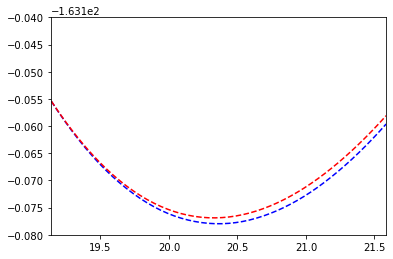

In [71]:
func_ref = interp_EvsV(dft_diamond['diamond_E_vs_V'])
func = interp_EvsV(np.array([df1['V'], df1['E']]).T.tolist())
mini = minimize(func_ref, dft_diamond['diamond_E_vs_V'][1][0])
V0 = mini.x[0]
x = np.linspace(0.94*V0, 1.06*V0)
plt.plot(x,func_ref(x),'--b')
plt.plot(x, func(x), '--r')
plt.xlim(0.94*V0, 1.06*V0)
plt.ylim(-163.18, -163.14)

(-163.18, -163.14)

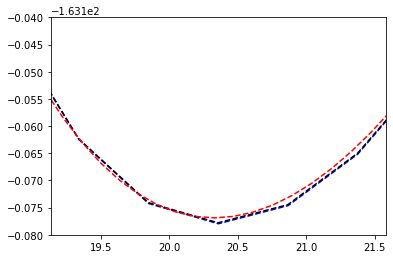

In [67]:
aa = np.array(dft_diamond['diamond_E_vs_V'])
bb = np.array(gap_diamond['diamond_E_vs_V'])
plt.plot(aa[:,0],aa[:,1],'--b')
plt.plot(bb[:,0],bb[:,1],'--k')
plt.plot(df1['V'], df1['E'], '--r')
plt.xlim(0.94*V0, 1.06*V0)
plt.ylim(-163.18, -163.14)

In [56]:
compute_delta(dft_diamond['diamond_E_vs_V'], np.array([df1['V'], df1['E']]).T.tolist())*1000

V0 20.360473097937966


1.1176225435793794

In [55]:
df = pd.read_json(PATH+'Si-sparcification-figure-E_vs_V.json')
df1 = df.query("lattice=='diamond' and n_feature==286 and n_sparse==2000")
df1['V']

2160    22.358820
2161    22.209499
2162    22.060844
2163    21.912854
2164    21.765527
2165    21.618862
2166    21.472857
2167    21.327512
2168    21.182823
2169    21.038791
2170    20.895413
2171    20.752688
2172    20.610614
2173    20.469190
2174    20.328414
2175    20.188286
2176    20.048803
2177    19.909964
2178    19.771767
2179    19.634211
2180    19.497295
2181    19.361017
2182    19.225375
2183    19.090368
2184    18.955995
2185    18.822254
2186    18.689143
2187    18.556662
2188    18.424808
2189    18.293580
Name: V, dtype: float64

In [39]:
df1['n_feature'].unique()

array([130])

In [75]:
data = pd.read_json(PATH+'Si-sparcification-figure-data-1.json')
# data.append(pd.read_json(PATH+'Si-sparcification-figure-data-2.json'))

data['RMSE_e'] = data['RMSE_e'] * 1000
data = data.rename(columns={'n_features':'$N_{feature}$',
                            'n_sparse':'$N_{sparse}$',
                            'RMSE_e':'formation energy RMSE [meV/atom]',
                            'RMSE_f':'force RMSE [eV/$\AA$]',
                            '$\Delta$ $\beta$-Sn': r'$\Delta\;\beta$-Sn'
                           })
data

$N_{feature}$  $N_{sparse}$     MAE_e  formation energy RMSE [meV/atom]  \
0              14           100  0.017611                         35.747944   
1              35           100  0.014222                         29.016436   
2              71           100  0.011545                         22.790397   
3             143           100  0.013472                         26.938145   
4             286           100  0.014787                         29.342528   
..            ...           ...       ...                               ...   
59            143          9000  0.002545                          5.695073   
60            286          9000  0.002232                          4.977628   
61            357          9000  0.002218                          4.938578   
62            500          9000  0.002448                          4.934173   
63            715          9000  0.002213                          4.982259   

       MAE_f  force RMSE [eV/$\AA$]  lambda_e  lambda_f  $\Delta$ diamond  \
0   0.368807               0.576853     0.001      0.50         14.324373   
1   0.328881               0.514368     0.001      0.50          4.494500   
2   0.227495               0.354094     0.001      0.50          8.929138   
3   0.270120               0.411834     0.001      0.50         13.936196   
4   0.278312               0.420811     0.001      0.50         14.276129   
..       ...                    ...       ...       ...               ...   
59  0.067228               0.110307     0.010      0.50          1.950692   
60  0.060543               0.100200     0.001      0.05          1.421174   
61  0.060122               0.099772     0.001      0.05          1.499965   
62  0.053928               0.089699     0.005      0.10          2.676153   
63  0.060226               0.099868     0.001      0.05          1.436181   

      $c_{11}$  ...  elatic unit  $\Delta$ unit  $V_0$ diamond $a_0$ diamond  \
0   167.980503  ...          GPa            meV     159.641192      5.424774   
1   170.203646  ...          GPa            meV     164.271458      5.476722   
2   173.881416  ...          GPa            meV     161.251720      5.442956   
3   161.122677  ...          GPa            meV     161.189477      5.442255   
4   179.542114  ...          GPa            meV     161.249121      5.442926   
..         ...  ...          ...            ...            ...           ...   
59  139.459927  ...          GPa            meV     162.518683      5.457174   
60  138.759625  ...          GPa            meV     162.684398      5.459028   
61  137.160045  ...          GPa            meV     162.657239      5.458724   
62  135.004798  ...          GPa            meV     162.540417      5.457417   
63  137.647896  ...          GPa            meV     162.687525      5.459063   

   $\Delta\;\beta$-Sn      B [%]  $c_{11}$ [%]  $c_{12}$ [%]  $c_{44}$ [%]  \
0            7.606929  52.588845      9.583535    111.186796    -27.154452   
1            5.399908  -0.336798     11.033822    -15.830118     20.775070   
2                 NaN   5.419655     13.433047     -5.499192     -7.052024   
3                 NaN  15.312204      5.109773     29.213778     -2.114455   
4                 NaN  15.410131     17.125853     13.072332    -13.418165   
..                ...        ...           ...           ...           ...   
59           8.873800  -2.597653     -9.022109      6.156149    -12.987082   
60           0.233466  -3.563182     -9.478958      4.497504    -13.470071   
61           0.391891  -2.728314    -10.522457      7.891789    -13.059109   
62           0.196184  -4.840879    -11.928451      4.816468    -10.653876   
63           0.197463  -3.205469    -10.204203      6.330829    -13.941491   

    $a_0$ diamond [%]  
0           -0.663749  
1            0.287503  
2           -0.330817  
3           -0.343643  
4           -0.331352  
..                ...  
59          -0.070462  
60          -0.036509  
61          -0.0

In [20]:
data = pd.read_json(PATH+'Si-sparcification-figure-data-2.json')
# data.append(pd.read_json(PATH+'Si-sparcification-figure-data-2.json'))

data['RMSE_e'] = data['RMSE_e'] * 1000
data = data.rename(columns={'n_features':'$N_{feature}$',
                            'n_sparse':'$N_{sparse}$',
                            'RMSE_e':'formation energy RMSE [meV/atom]',
                            'RMSE_f':'force RMSE [eV/$\AA$]',
                            '$\Delta$ $\beta$-Sn': r'$\Delta\;\beta$-Sn'
                           })
data

$N_{feature}$  $N_{sparse}$     MAE_e  formation energy RMSE [meV/atom]  \
0            130          1000  0.003747                          8.675342   
1            130          2000  0.002841                          6.692387   
2            130          5000  0.002598                          6.433445   

      MAE_f  force RMSE [eV/$\AA$]  lambda_e  lambda_f  $\Delta$ diamond  \
0  0.108387               0.174555     0.005       0.5          2.256472   
1  0.090831               0.147695     0.005       0.5          1.700988   
2  0.083282               0.134511     0.001       0.1          1.282033   

     $c_{11}$  ...  elatic unit  $\Delta$ unit  $V_0$ diamond $a_0$ diamond  \
0  137.959595  ...          GPa            meV     162.271665      5.454407   
1  141.865523  ...          GPa            meV     162.457965      5.456494   
2  139.988063  ...          GPa            meV     162.603997      5.458128   

  $\Delta\;\beta$-Sn     B [%]  $c_{11}$ [%]  $c_{12}$ [%]  $c_{44}$ [%]  \
0          13.619932  2.148023    -10.000864     18.701789    -19.796107   
1          14.147103  3.045593     -7.452798     17.350435    -18.965019   
2           3.136364 -0.554085     -8.677575     10.514779    -18.273713   

   $a_0$ diamond [%]  
0          -0.121117  
1          -0.082909  
2          -0.052979  

[3 rows x 23 columns]

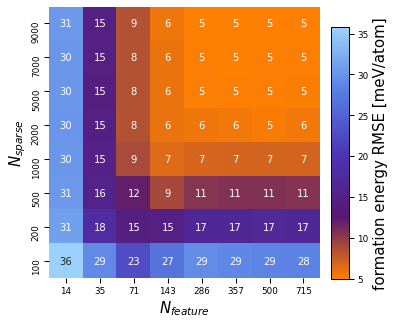

In [21]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='formation energy RMSE [meV/atom]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-rmse_e.png'
    #plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
n = 10
l = 13
sp = 1
(n*sp+1)*n*sp/2*l,(sp+1)*sp/2*l*n

(715.0, 130.0)

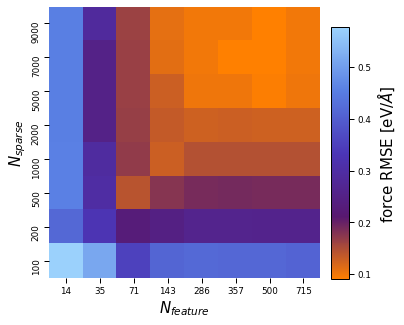

In [23]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour(data, x='$N_{feature}$', y='$N_{sparse}$', values='force RMSE [eV/$\AA$]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-rmse_f.png'
    #plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

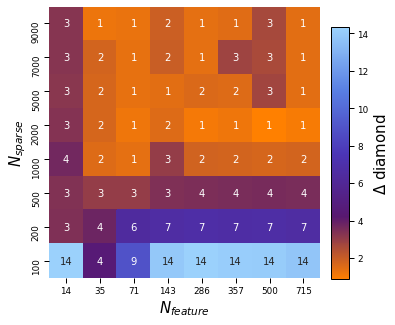

In [24]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$\Delta$ diamond' , 
                             row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-delta_diamond.png'
    #plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

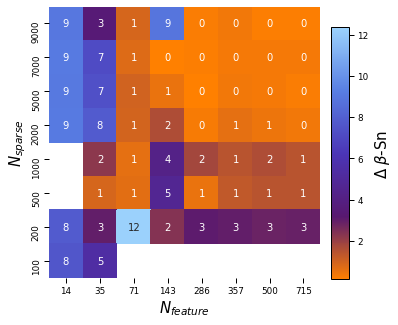

In [25]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values=r'$\Delta\;\beta$-Sn' , 
                             row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-delta_beta.png'
    #plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
data.query("`$N_{feature}$`==715 and `$N_{sparse}$`==9000")

$N_{feature}$  $N_{sparse}$     MAE_e  formation energy RMSE [meV/atom]  \
63            715          9000  0.002213                          4.982259   

       MAE_f  force RMSE [eV/$\AA$]  lambda_e  lambda_f  $\Delta$ diamond  \
63  0.060226               0.099868     0.001      0.05          1.436181   

      $c_{11}$  ...  elatic unit  $\Delta$ unit  $V_0$ diamond $a_0$ diamond  \
63  137.647896  ...          GPa            meV     162.687525      5.459063   

   $\Delta\;\beta$-Sn     B [%]  $c_{11}$ [%]  $c_{12}$ [%]  $c_{44}$ [%]  \
63           0.197463 -3.205469    -10.204203      6.330829    -13.941491   

    $a_0$ diamond [%]  
63          -0.035868  

[1 rows x 23 columns]

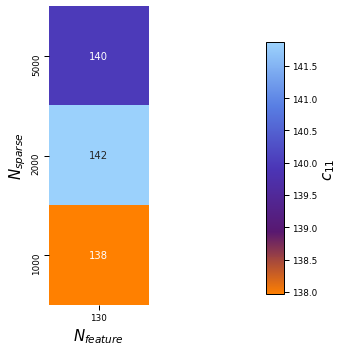

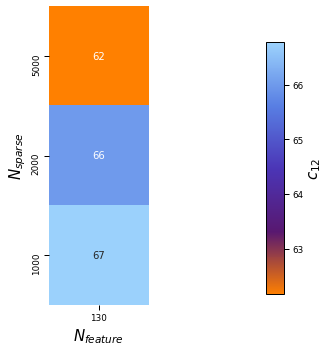

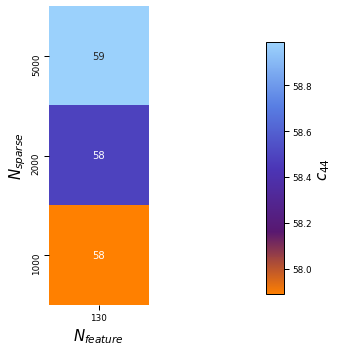

In [41]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{11}$' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
#     plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{12}$' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
#     plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{44}$' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
#     plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

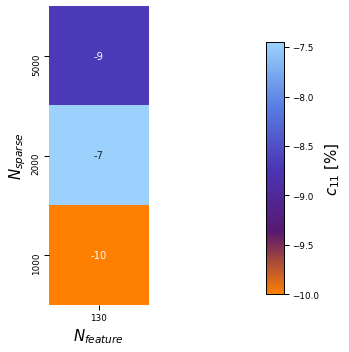

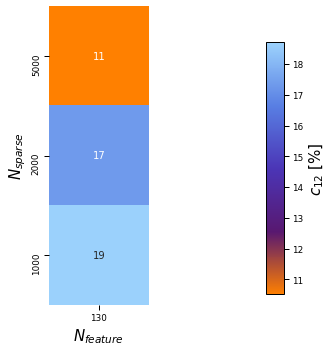

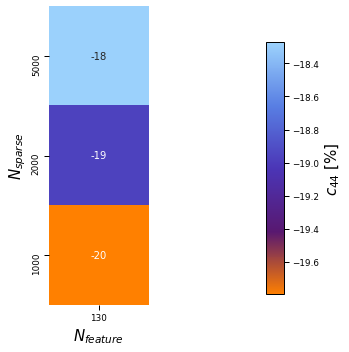

In [42]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{11}$ [%]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{12}$ [%]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='$c_{44}$ [%]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-c11.png'
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='B [%]' , row=None, col=None, **kwargs)
    fname = 'Si-sparse_vs_feat-bulk_modulus.png'
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

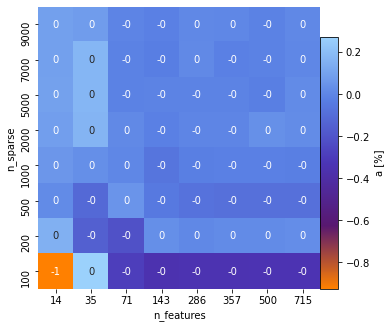

In [171]:
g = plot_contour(data, x='$N_{feature}$', y='$N_{sparse}$', values='a [%]' , row=None, col=None, **kwargs)

## try to get some better models 

In [22]:
frames = fromfile('structures/silicon_bulk.json')[1:]

In [34]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape((-1,1))   

In [36]:
cv = KFold(n_splits=4, shuffle=True, random_state=10)
scores = []
project = signac.get_project('./results/train_model/')
for job in tqdm(project.find_jobs()):
    n_features = job.sp.feature_subselection['Nselect']
    n_sparse = job.sp.sparse_point_subselection['Nselect']['14']
    # if n_sparse != 7000: continue 
    model = load_obj(job.fn('model.json'))
    kernel = model.kernel
    X_pseudo = model.X_train
    
    # print(name)
    kk = frompickle(job.fn('knm.pck'))
    for lamda_e in tqdm([1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4],leave=False):
        for lamda_f in tqdm([0.5,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4],leave=False):
            if lamda_e>lamda_f: continue
            for train, val in tqdm(cv.split(kk['energy']['y']), leave=False, total=cv.n_splits):
                score,yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, kk, self_contributions, 
                                 lambdas=[lamda_e,lamda_f], jitter=1e-7)
                en_score = get_score((yp.flatten()-y_baseline[val].flatten())/Natoms[val].flatten(), 
                                     yt.flatten()/Natoms[val].flatten())
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), ft.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f,
                             n_features=n_features, n_sparse=n_sparse)
                scores.append(score)
        
scores = pd.DataFrame(scores)

KeyboardInterrupt: 

In [ ]:
scores.to_json('si-cv_score.json')

In [ ]:
scores.groupby(['n_features','n_sparse','lambda_e','lambda_f']).mean().sort_values('MAE_e')